In [1]:
#Image Classification
import os
from urllib.request import urlretrieve
#from os.path import isfile, isdir
from tqdm import tqdm
import tarfile
import unittest
path = "C:\\Users\\HP\\Desktop\\Learning\\DataScience\\01Materials\\38. DEEP LEARNING 5 PROJECT-6 IMPLEMENTATION - IMAGE CLASSIFICATION\\Assignment"
os.chdir(path)
os.getcwd() 



'C:\\Users\\HP\\Desktop\\Learning\\DataScience\\01Materials\\38. DEEP LEARNING 5 PROJECT-6 IMPLEMENTATION - IMAGE CLASSIFICATION\\Assignment'

## Data analysis and preprocessing

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf

In [3]:
# Load labels from the dataset
def _load_label_names():
    """
    Load the label names from file
    """
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
# Defining a helper function for loading a batch of images
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    """
    Load a batch of the dataset
    """
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels

In [5]:
#Defining a function to show the stats for batch ans specific sample
def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    """
    Display Stats of the the dataset
    """
    batch_ids = list(range(1, 6))

    if batch_id not in batch_ids:
        print('Batch Id out of Range. Possible Batch Ids: {}'.format(batch_ids))
        return None

    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch {}:'.format(batch_id))
    print('Samples: {}'.format(len(features)))
    print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))
    print('First 20 Labels: {}'.format(labels[:20]))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    label_names = _load_label_names()

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)


Stats of batch 3:
Samples: 10000
Label Counts: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
First 20 Labels: [8, 5, 0, 6, 9, 2, 8, 3, 6, 2, 7, 4, 6, 9, 0, 0, 7, 3, 7, 2]

Example of Image 6:
Image - Min Value: 30 Max Value: 242
Image - Shape: (32, 32, 3)
Label - Label Id: 8 Name: ship


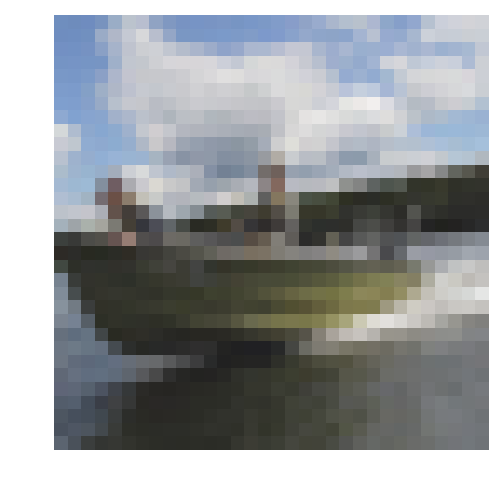

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

path = "C:\\Users\\HP\\Desktop\\Learning\\DataScience\\01Materials\\38. DEEP LEARNING 5 PROJECT-6 IMPLEMENTATION - IMAGE CLASSIFICATION\\Assignment\\cifar-10-batches-py\\"
os.chdir(path)


# Explore a specific batch and sample from the dataset
cifar10_dataset_folder_path = path
batch_id = 3
sample_id = 6
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)


Stats of batch 5:
Samples: 10000
Label Counts: {0: 1014, 1: 1014, 2: 952, 3: 1016, 4: 997, 5: 1025, 6: 980, 7: 977, 8: 1003, 9: 1022}
First 20 Labels: [1, 8, 5, 1, 5, 7, 4, 3, 8, 2, 7, 2, 0, 1, 5, 9, 6, 2, 0, 8]

Example of Image 10:
Image - Min Value: 16 Max Value: 227
Image - Shape: (32, 32, 3)
Label - Label Id: 7 Name: horse


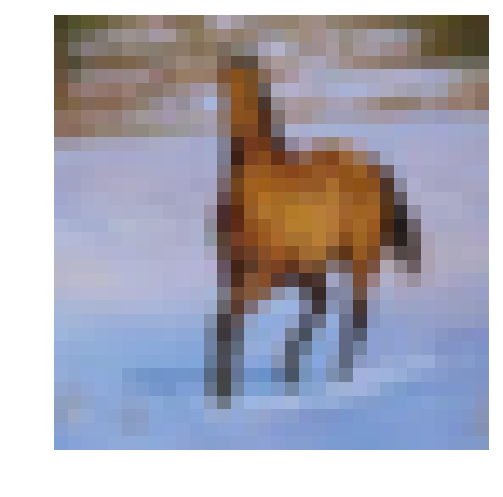

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

path = "C:\\Users\\HP\\Desktop\\Learning\\DataScience\\01Materials\\38. DEEP LEARNING 5 PROJECT-6 IMPLEMENTATION - IMAGE CLASSIFICATION\\Assignment\\cifar-10-batches-py\\"
os.chdir(path)


# Explore a specific batch and sample from the dataset
cifar10_dataset_folder_path = path
batch_id = 5
sample_id = 10
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

#### Apply normalization and 1-hot encoding to dataset

In [8]:
#Function used to normalize CIFAR-10 images to be in the range of [0,1]
def normalize(images):        
    # initial zero ndarray    
    normalized_images = np.zeros_like(images.astype(float))        
    
    # The first images index is number of images where the other indices indicates    
    # hieight, width and depth of the image    
    num_images = images.shape[0]        
    
    # Computing the minimum and maximum value of the input image to do the normalization based on them    
    maximum_value, minimum_value = images.max(), images.min()        
    
    # Normalize all the pixel values of the images to be from 0 to 1    
    for img in range(num_images):        
        normalized_images[img,...] = (images[img, ...] - float(minimum_value)) / float(maximum_value - minimum_value)    
    return normalized_images

In [9]:
# encoding the input images. Each image will be represented by a vector of zeros except for the class index of the image 
# that this vector represents. The length of this vector depends on number of classes that we have
# the dataset which is 10 in CIFAR-10

from sklearn.preprocessing import OneHotEncoder

def one_hot_encode(images):        
    num_classes = 10        
    
    #use sklearn helper function of OneHotEncoder() to do that     
    encoder = OneHotEncoder(num_classes)        
    
    #resize the input images to be 2D    
    input_images_resized_to_2d = np.array(images).reshape(-1,1)    
    one_hot_encoded_targets = encoder.fit_transform(input_images_resized_to_2d)
    
    return one_hot_encoded_targets.toarray()

In [10]:
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    """
    Preprocess data and save it to file
    """
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    """
    Preprocess Training and Validation Data
    """
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        validation_count = int(len(features) * 0.1)

        # Prprocess and save a batch of training data
        _preprocess_and_save(
            normalize,
            one_hot_encode,
            features[:-validation_count],
            labels[:-validation_count],
            'preprocess_batch_' + str(batch_i) + '.p')

        # Use a portion of training batch for validation
        valid_features.extend(features[-validation_count:])
        valid_labels.extend(labels[-validation_count:])

    # Preprocess and Save all validation data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(valid_features),
        np.array(valid_labels),
        'preprocess_validation.p')

    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # load the training data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all training data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(test_features),
        np.array(test_labels),
        'preprocess_test.p')

In [11]:
# Call function for preprocessing of the data
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:331: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)]'.
  warnings.warn(msg, DeprecationWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:331: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)]'.
  warnings.warn(msg, DeprecationWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:331: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)]'.
  warnings.warn(msg, DeprecationWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklear

In [12]:
# Load the Preprocessed Validation data
valid_input_features, valid_input_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Model Building

In [13]:
# Defining the model inputs
def images_input(img_shape): 
    return tf.placeholder(tf.float32, (None, ) + img_shape, name="input_images")

def target_input(num_classes):  
    target_input = tf.placeholder(tf.int32, (None, num_classes), name="input_images_target") 
    return target_input

#define a function for the dropout layer keep probability
def keep_prob_input(): 
    return tf.placeholder(tf.float32, name="keep_prob")

In [14]:
# Applying a convolution operation to the input tensor followed by max pooling
def conv2d_layer(input_tensor, conv_layer_num_outputs, conv_kernel_size, conv_layer_strides, pool_kernel_size, pool_layer_strides): 
    input_depth = input_tensor.get_shape()[3].value 
    weight_shape = conv_kernel_size + (input_depth, conv_layer_num_outputs,)   
    
    #Defining layer weights and biases 
    weights = tf.Variable(tf.random_normal(weight_shape)) 
    biases = tf.Variable(tf.random_normal((conv_layer_num_outputs,)))  
    
    #Considering the biase variable 
    conv_strides = (1,) + conv_layer_strides + (1,)
    
    conv_layer = tf.nn.conv2d(input_tensor, weights, strides=conv_strides, padding='SAME') 
    conv_layer = tf.nn.bias_add(conv_layer, biases) 
    
    conv_kernel_size = (1,) + conv_kernel_size + (1,) 
    
    pool_strides = (1,) + pool_layer_strides + (1,) 
    pool_layer = tf.nn.max_pool(conv_layer, ksize=conv_kernel_size, strides=pool_strides, padding='SAME') 
    
    return pool_layer

In [15]:
#Flatten the output of max pooling layer to be fing to the fully connected layer which only accepts the output
# to be in 2D
def flatten_layer(input_tensor):
    return tf.contrib.layers.flatten(input_tensor)

In [16]:
#Define the fully connected layer that will use the flattened output of the stacked convolution layers
#to do the actuall classification
def fully_connected_layer(input_tensor, num_outputs): 
    return tf.layers.dense(input_tensor, num_outputs)

In [17]:
#Defining the output function
def output_layer(input_tensor, num_outputs):    
    return  tf.layers.dense(input_tensor, num_outputs)

In [18]:
def build_convolution_net(image_data, keep_prob):  
    # Applying 3 convolution layers followed by max pooling layers 
    conv_layer_1 = conv2d_layer(image_data, 32, (3,3), (1,1), (3,3), (3,3))  
    conv_layer_2 = conv2d_layer(conv_layer_1, 64, (3,3), (1,1), (3,3), (3,3)) 
    conv_layer_3 = conv2d_layer(conv_layer_2, 128, (3,3), (1,1), (3,3), (3,3))
    
    # Flatten the output from 4D to 2D to be fed to the fully connected layer 
    flatten_output = flatten_layer(conv_layer_3)
    
    # Applying 2 fully connected layers with drop out 
    fully_connected_layer_1 = fully_connected_layer(flatten_output, 64) 
    fully_connected_layer_1 = tf.nn.dropout(fully_connected_layer_1, keep_prob) 
    fully_connected_layer_2 = fully_connected_layer(fully_connected_layer_1, 32) 
    fully_connected_layer_2 = tf.nn.dropout(fully_connected_layer_2, keep_prob)  
    
    #Applying the output layer while the output size will be the number of categories that we have 
    #in CIFAR-10 dataset 
    output_logits = output_layer(fully_connected_layer_2, 10)
    
    #returning output 
    return output_logits

In [19]:
def test_conv_net(conv_net):
    test_x = tf.placeholder(tf.float32, [None, 32, 32, 3])
    test_k = tf.placeholder(tf.float32)

    logits_out = conv_net(test_x, test_k)

    assert logits_out.get_shape().as_list() == [None, 10],\
        'Incorrect Model Output.  Found {}'.format(logits_out.get_shape().as_list())

    print('Neural Network Built!')

In [20]:
#Using the helper function above to build the network
#First off, let's remove all the previous inputs, weights, biases form the previous runs
tf.reset_default_graph()

# Defining the input placeholders to the convolution neural network
input_images = images_input((32, 32, 3))
input_images_target = target_input(10)
keep_prob = keep_prob_input()

# Building the models
logits_values = build_convolution_net(input_images, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits_values = tf.identity(logits_values, name='logits')

# defining the model loss
model_cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits_values, labels=input_images_target))

# Defining the model optimizer
model_optimizer = tf.train.AdamOptimizer().minimize(model_cost)

# Calculating and averaging the model accuracy
correct_prediction = tf.equal(tf.argmax(logits_values, 1), tf.argmax(input_images_target, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='model_accuracy')

Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [21]:
test_conv_net(build_convolution_net)

Neural Network Built!


## Training Model

In [22]:
#Define a helper function for kicking off the training process
def train(session, model_optimizer, keep_probability, in_feature_batch, target_batch):
    session.run(model_optimizer, feed_dict={input_images: in_feature_batch, input_images_target: target_batch, keep_prob: keep_probability})

In [23]:
#Defining a helper funcitno for print information about the model accuracy and it's validation accuracy as well
def print_model_stats(session, input_feature_batch, target_label_batch, model_cost, model_accuracy):        
    validation_loss = session.run(model_cost, feed_dict={input_images: input_feature_batch, input_images_target: target_label_batch, keep_prob: 1.0})    
    validation_accuracy = session.run(model_accuracy, feed_dict={input_images: input_feature_batch, input_images_target: target_label_batch, keep_prob: 1.0})        
    
    print("Valid Loss: %f" %(validation_loss))    
    print("Valid accuracy: %f" % (validation_accuracy))

In [24]:
# Model Hyperparameters
num_epochs = 100
batch_size = 128
keep_probability = 0.5

In [25]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]


def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)

In [26]:
print('Training on only a Single Batch from the CIFAR-10 Dataset...')
with tf.Session() as sess:  
    # Initializing the variables 
    sess.run(tf.global_variables_initializer())  
    # Training cycle 
    for epoch in range(num_epochs): 
        batch_ind = 1  
        for batch_features, batch_labels in load_preprocess_training_batch(batch_ind, batch_size): 
            train(sess, model_optimizer, keep_probability, batch_features, batch_labels)  
            
            print('Epoch number {:>2}, CIFAR-10 Batch Number {}: '.format(epoch + 1, batch_ind), end='') 
            print_model_stats(sess, batch_features, batch_labels, model_cost, accuracy)

Training on only a Single Batch from the CIFAR-10 Dataset...
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1485.227295
Valid accuracy: 0.156250
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1859.814087
Valid accuracy: 0.132812
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1900.041016
Valid accuracy: 0.070312
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1441.331787
Valid accuracy: 0.156250
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1110.040771
Valid accuracy: 0.125000
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 862.838196
Valid accuracy: 0.125000
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 851.215393
Valid accuracy: 0.109375
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1100.575195
Valid accuracy: 0.093750
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1231.975220
Valid accuracy: 0.054688
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 872.586182
Valid accuracy: 0.070312
Epoch number  1, CIFAR-10 Batch 

Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 144.005707
Valid accuracy: 0.281250
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 134.897278
Valid accuracy: 0.328125
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 113.746742
Valid accuracy: 0.406250
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 135.662247
Valid accuracy: 0.375000
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 121.730232
Valid accuracy: 0.375000
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 98.195686
Valid accuracy: 0.398438
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 130.229797
Valid accuracy: 0.375000
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 102.872688
Valid accuracy: 0.351562
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 126.313225
Valid accuracy: 0.382812
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 122.941902
Valid accuracy: 0.375000
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 106.416214
Valid accuracy: 0.359375
Epoch numbe

Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 50.986824
Valid accuracy: 0.421875
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 54.784843
Valid accuracy: 0.421875
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 60.974697
Valid accuracy: 0.453125
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 63.872665
Valid accuracy: 0.453125
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 59.721428
Valid accuracy: 0.414062
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 50.192169
Valid accuracy: 0.414062
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 67.097908
Valid accuracy: 0.398438
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 59.138031
Valid accuracy: 0.421875
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 52.462086
Valid accuracy: 0.437500
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 58.912872
Valid accuracy: 0.421875
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 60.833393
Valid accuracy: 0.375000
Epoch number  6, CIFA

Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 28.764114
Valid accuracy: 0.414062
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 30.566193
Valid accuracy: 0.468750
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 38.497601
Valid accuracy: 0.421875
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 19.156958
Valid accuracy: 0.539062
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 32.751862
Valid accuracy: 0.500000
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 34.672295
Valid accuracy: 0.406250
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 32.938934
Valid accuracy: 0.468750
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 30.633072
Valid accuracy: 0.445312
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 34.046127
Valid accuracy: 0.437500
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 30.618587
Valid accuracy: 0.398438
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 31.696287
Valid accuracy: 0.398438
Epoch number  8, CIFA

Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 17.069429
Valid accuracy: 0.476562
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 23.859100
Valid accuracy: 0.359375
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 17.312923
Valid accuracy: 0.445312
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 18.569820
Valid accuracy: 0.453125
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 20.606104
Valid accuracy: 0.375000
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 15.805906
Valid accuracy: 0.445312
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 18.947792
Valid accuracy: 0.445312
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 13.312357
Valid accuracy: 0.492188
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 22.194397
Valid accuracy: 0.375000
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 14.474254
Valid accuracy: 0.484375
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 19.266758
Valid accuracy: 0.414062
Epoch number 11, CIFA

Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 9.843638
Valid accuracy: 0.398438
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 8.652923
Valid accuracy: 0.531250
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 10.865040
Valid accuracy: 0.453125
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 9.706245
Valid accuracy: 0.484375
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 11.675369
Valid accuracy: 0.406250
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 13.037982
Valid accuracy: 0.390625
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 10.914892
Valid accuracy: 0.500000
Epoch number 14, CIFAR-10 Batch Number 1: Valid Loss: 12.547143
Valid accuracy: 0.523438
Epoch number 14, CIFAR-10 Batch Number 1: Valid Loss: 9.708024
Valid accuracy: 0.476562
Epoch number 14, CIFAR-10 Batch Number 1: Valid Loss: 9.097017
Valid accuracy: 0.500000
Epoch number 14, CIFAR-10 Batch Number 1: Valid Loss: 9.934832
Valid accuracy: 0.507812
Epoch number 14, CIFAR-10 B

Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 6.464899
Valid accuracy: 0.429688
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 8.520341
Valid accuracy: 0.414062
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 6.432810
Valid accuracy: 0.367188
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 3.939538
Valid accuracy: 0.382812
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 8.113182
Valid accuracy: 0.382812
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 6.220839
Valid accuracy: 0.453125
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 6.686498
Valid accuracy: 0.414062
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 5.687478
Valid accuracy: 0.468750
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 5.558461
Valid accuracy: 0.500000
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 6.148123
Valid accuracy: 0.390625
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 4.883883
Valid accuracy: 0.421875
Epoch number 16, CIFAR-10 Batch 

Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 3.734199
Valid accuracy: 0.390625
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 3.893447
Valid accuracy: 0.328125
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 3.056911
Valid accuracy: 0.421875
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 6.088017
Valid accuracy: 0.390625
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 4.945301
Valid accuracy: 0.320312
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 3.104834
Valid accuracy: 0.453125
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 5.882699
Valid accuracy: 0.398438
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 4.138332
Valid accuracy: 0.375000
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 4.152821
Valid accuracy: 0.359375
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 4.170860
Valid accuracy: 0.398438
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 3.928815
Valid accuracy: 0.359375
Epoch number 19, CIFAR-10 Batch 

Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 4.377036
Valid accuracy: 0.265625
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 2.512681
Valid accuracy: 0.367188
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 2.295981
Valid accuracy: 0.335938
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 3.517122
Valid accuracy: 0.382812
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 5.101283
Valid accuracy: 0.398438
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 3.280737
Valid accuracy: 0.421875
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 3.931486
Valid accuracy: 0.375000
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 2.827126
Valid accuracy: 0.328125
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 2.487670
Valid accuracy: 0.382812
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 3.791709
Valid accuracy: 0.398438
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 3.041461
Valid accuracy: 0.367188
Epoch number 21, CIFAR-10 Batch 

Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 2.983554
Valid accuracy: 0.250000
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 2.162429
Valid accuracy: 0.304688
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.947510
Valid accuracy: 0.375000
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 2.323538
Valid accuracy: 0.390625
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 2.419513
Valid accuracy: 0.359375
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 2.286396
Valid accuracy: 0.390625
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 2.496113
Valid accuracy: 0.375000
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 3.210858
Valid accuracy: 0.367188
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 2.072382
Valid accuracy: 0.421875
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 2.691603
Valid accuracy: 0.375000
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 2.764761
Valid accuracy: 0.335938
Epoch number 24, CIFAR-10 Batch 

Epoch number 26, CIFAR-10 Batch Number 1: Valid Loss: 1.848555
Valid accuracy: 0.325000
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 2.064481
Valid accuracy: 0.414062
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 1.994966
Valid accuracy: 0.429688
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 1.782564
Valid accuracy: 0.445312
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 1.858379
Valid accuracy: 0.398438
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 1.873888
Valid accuracy: 0.375000
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 1.962972
Valid accuracy: 0.398438
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 2.088943
Valid accuracy: 0.382812
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 1.647292
Valid accuracy: 0.437500
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 1.612406
Valid accuracy: 0.398438
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 1.635463
Valid accuracy: 0.390625
Epoch number 27, CIFAR-10 Batch 

Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.637390
Valid accuracy: 0.421875
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.609747
Valid accuracy: 0.445312
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.666639
Valid accuracy: 0.382812
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.630604
Valid accuracy: 0.382812
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.556170
Valid accuracy: 0.437500
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.623998
Valid accuracy: 0.437500
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.581330
Valid accuracy: 0.414062
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.600120
Valid accuracy: 0.453125
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.711983
Valid accuracy: 0.351562
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.652947
Valid accuracy: 0.460938
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.719060
Valid accuracy: 0.382812
Epoch number 29, CIFAR-10 Batch 

Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.570591
Valid accuracy: 0.437500
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.602206
Valid accuracy: 0.437500
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.668478
Valid accuracy: 0.367188
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.587878
Valid accuracy: 0.429688
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.626534
Valid accuracy: 0.351562
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.700738
Valid accuracy: 0.351562
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.564338
Valid accuracy: 0.507812
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.683902
Valid accuracy: 0.382812
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.661544
Valid accuracy: 0.375000
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.673403
Valid accuracy: 0.406250
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.703421
Valid accuracy: 0.437500
Epoch number 32, CIFAR-10 Batch 

Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.675042
Valid accuracy: 0.296875
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.654746
Valid accuracy: 0.343750
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.673248
Valid accuracy: 0.453125
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.605940
Valid accuracy: 0.421875
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.571525
Valid accuracy: 0.453125
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.566503
Valid accuracy: 0.460938
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.597009
Valid accuracy: 0.414062
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.573153
Valid accuracy: 0.437500
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.679406
Valid accuracy: 0.406250
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.640735
Valid accuracy: 0.421875
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.737387
Valid accuracy: 0.400000
Epoch number 35, CIFAR-10 Batch 

Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.578786
Valid accuracy: 0.421875
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.586203
Valid accuracy: 0.398438
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.628298
Valid accuracy: 0.398438
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.586041
Valid accuracy: 0.445312
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.693509
Valid accuracy: 0.429688
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.601022
Valid accuracy: 0.429688
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.624838
Valid accuracy: 0.351562
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.614427
Valid accuracy: 0.421875
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.524967
Valid accuracy: 0.515625
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.661898
Valid accuracy: 0.359375
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.606535
Valid accuracy: 0.437500
Epoch number 37, CIFAR-10 Batch 

Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.722500
Valid accuracy: 0.382812
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.537848
Valid accuracy: 0.421875
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.516106
Valid accuracy: 0.500000
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.594341
Valid accuracy: 0.390625
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.658969
Valid accuracy: 0.359375
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.580318
Valid accuracy: 0.421875
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.607394
Valid accuracy: 0.429688
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.622652
Valid accuracy: 0.367188
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.578300
Valid accuracy: 0.414062
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.725068
Valid accuracy: 0.367188
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.570963
Valid accuracy: 0.429688
Epoch number 40, CIFAR-10 Batch 

Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.571877
Valid accuracy: 0.429688
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.720289
Valid accuracy: 0.398438
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.540161
Valid accuracy: 0.507812
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.632024
Valid accuracy: 0.398438
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.563867
Valid accuracy: 0.421875
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.587831
Valid accuracy: 0.437500
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.608549
Valid accuracy: 0.406250
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.703579
Valid accuracy: 0.375000
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.611837
Valid accuracy: 0.398438
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.672789
Valid accuracy: 0.398438
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.663169
Valid accuracy: 0.359375
Epoch number 42, CIFAR-10 Batch 

Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.711657
Valid accuracy: 0.359375
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.639220
Valid accuracy: 0.398438
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.624489
Valid accuracy: 0.453125
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.691291
Valid accuracy: 0.406250
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.645961
Valid accuracy: 0.359375
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.579182
Valid accuracy: 0.492188
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.542672
Valid accuracy: 0.445312
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.606216
Valid accuracy: 0.390625
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.543148
Valid accuracy: 0.453125
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.628124
Valid accuracy: 0.390625
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.614822
Valid accuracy: 0.390625
Epoch number 45, CIFAR-10 Batch 

Epoch number 47, CIFAR-10 Batch Number 1: Valid Loss: 1.579323
Valid accuracy: 0.445312
Epoch number 47, CIFAR-10 Batch Number 1: Valid Loss: 1.616017
Valid accuracy: 0.406250
Epoch number 47, CIFAR-10 Batch Number 1: Valid Loss: 1.581133
Valid accuracy: 0.429688
Epoch number 47, CIFAR-10 Batch Number 1: Valid Loss: 1.699314
Valid accuracy: 0.475000
Epoch number 48, CIFAR-10 Batch Number 1: Valid Loss: 1.613216
Valid accuracy: 0.398438
Epoch number 48, CIFAR-10 Batch Number 1: Valid Loss: 1.512628
Valid accuracy: 0.429688
Epoch number 48, CIFAR-10 Batch Number 1: Valid Loss: 1.500323
Valid accuracy: 0.429688
Epoch number 48, CIFAR-10 Batch Number 1: Valid Loss: 1.604530
Valid accuracy: 0.421875
Epoch number 48, CIFAR-10 Batch Number 1: Valid Loss: 1.574457
Valid accuracy: 0.468750
Epoch number 48, CIFAR-10 Batch Number 1: Valid Loss: 1.677362
Valid accuracy: 0.367188
Epoch number 48, CIFAR-10 Batch Number 1: Valid Loss: 1.689893
Valid accuracy: 0.406250
Epoch number 48, CIFAR-10 Batch 

Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.588888
Valid accuracy: 0.460938
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.592830
Valid accuracy: 0.437500
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.632138
Valid accuracy: 0.382812
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.606185
Valid accuracy: 0.406250
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.565972
Valid accuracy: 0.429688
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.600852
Valid accuracy: 0.421875
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.586805
Valid accuracy: 0.429688
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.567471
Valid accuracy: 0.429688
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.555189
Valid accuracy: 0.460938
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.499146
Valid accuracy: 0.468750
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.484679
Valid accuracy: 0.476562
Epoch number 50, CIFAR-10 Batch 

Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.589206
Valid accuracy: 0.375000
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.523419
Valid accuracy: 0.468750
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.698249
Valid accuracy: 0.343750
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.551375
Valid accuracy: 0.453125
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.564503
Valid accuracy: 0.460938
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.589241
Valid accuracy: 0.460938
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.533514
Valid accuracy: 0.406250
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.589426
Valid accuracy: 0.406250
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.656243
Valid accuracy: 0.421875
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.531421
Valid accuracy: 0.437500
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.684984
Valid accuracy: 0.429688
Epoch number 53, CIFAR-10 Batch 

Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.572054
Valid accuracy: 0.367188
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.513134
Valid accuracy: 0.445312
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.611869
Valid accuracy: 0.390625
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.586520
Valid accuracy: 0.375000
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.587051
Valid accuracy: 0.421875
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.659892
Valid accuracy: 0.359375
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.582450
Valid accuracy: 0.421875
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.603655
Valid accuracy: 0.398438
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.548686
Valid accuracy: 0.437500
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.556740
Valid accuracy: 0.406250
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.610888
Valid accuracy: 0.414062
Epoch number 55, CIFAR-10 Batch 

Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.589141
Valid accuracy: 0.406250
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.556004
Valid accuracy: 0.414062
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.650735
Valid accuracy: 0.351562
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.603885
Valid accuracy: 0.445312
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.454799
Valid accuracy: 0.484375
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.521734
Valid accuracy: 0.468750
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.541364
Valid accuracy: 0.460938
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.629796
Valid accuracy: 0.414062
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.548707
Valid accuracy: 0.484375
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.575802
Valid accuracy: 0.406250
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.563961
Valid accuracy: 0.421875
Epoch number 58, CIFAR-10 Batch 

Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.674918
Valid accuracy: 0.328125
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.586220
Valid accuracy: 0.406250
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.578753
Valid accuracy: 0.414062
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.756520
Valid accuracy: 0.343750
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.480570
Valid accuracy: 0.453125
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.412722
Valid accuracy: 0.531250
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.448694
Valid accuracy: 0.500000
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.595214
Valid accuracy: 0.382812
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.556579
Valid accuracy: 0.460938
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.597476
Valid accuracy: 0.437500
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.569285
Valid accuracy: 0.351562
Epoch number 61, CIFAR-10 Batch 

Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.510235
Valid accuracy: 0.429688
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.588946
Valid accuracy: 0.437500
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.479836
Valid accuracy: 0.492188
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.502553
Valid accuracy: 0.492188
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.627477
Valid accuracy: 0.437500
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.510308
Valid accuracy: 0.460938
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.569618
Valid accuracy: 0.429688
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.452868
Valid accuracy: 0.492188
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.604374
Valid accuracy: 0.382812
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.520609
Valid accuracy: 0.421875
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.545022
Valid accuracy: 0.359375
Epoch number 63, CIFAR-10 Batch 

Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.526489
Valid accuracy: 0.429688
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.597854
Valid accuracy: 0.445312
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.541377
Valid accuracy: 0.437500
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.633566
Valid accuracy: 0.406250
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.529141
Valid accuracy: 0.453125
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.547516
Valid accuracy: 0.414062
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.608377
Valid accuracy: 0.382812
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.556139
Valid accuracy: 0.312500
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.429571
Valid accuracy: 0.523438
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.411088
Valid accuracy: 0.460938
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.579562
Valid accuracy: 0.398438
Epoch number 66, CIFAR-10 Batch 

Epoch number 68, CIFAR-10 Batch Number 1: Valid Loss: 1.498272
Valid accuracy: 0.406250
Epoch number 68, CIFAR-10 Batch Number 1: Valid Loss: 1.422012
Valid accuracy: 0.460938
Epoch number 68, CIFAR-10 Batch Number 1: Valid Loss: 1.475030
Valid accuracy: 0.429688
Epoch number 68, CIFAR-10 Batch Number 1: Valid Loss: 1.523334
Valid accuracy: 0.445312
Epoch number 68, CIFAR-10 Batch Number 1: Valid Loss: 1.566706
Valid accuracy: 0.421875
Epoch number 68, CIFAR-10 Batch Number 1: Valid Loss: 1.611167
Valid accuracy: 0.328125
Epoch number 68, CIFAR-10 Batch Number 1: Valid Loss: 1.537816
Valid accuracy: 0.525000
Epoch number 69, CIFAR-10 Batch Number 1: Valid Loss: 1.613502
Valid accuracy: 0.421875
Epoch number 69, CIFAR-10 Batch Number 1: Valid Loss: 1.417718
Valid accuracy: 0.476562
Epoch number 69, CIFAR-10 Batch Number 1: Valid Loss: 1.414693
Valid accuracy: 0.460938
Epoch number 69, CIFAR-10 Batch Number 1: Valid Loss: 1.537230
Valid accuracy: 0.375000
Epoch number 69, CIFAR-10 Batch 

Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.583771
Valid accuracy: 0.390625
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.509625
Valid accuracy: 0.437500
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.585140
Valid accuracy: 0.398438
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.586687
Valid accuracy: 0.453125
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.513701
Valid accuracy: 0.476562
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.559060
Valid accuracy: 0.382812
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.504541
Valid accuracy: 0.445312
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.479617
Valid accuracy: 0.460938
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.563359
Valid accuracy: 0.390625
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.542490
Valid accuracy: 0.453125
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.491436
Valid accuracy: 0.414062
Epoch number 71, CIFAR-10 Batch 

Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.507788
Valid accuracy: 0.421875
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.590755
Valid accuracy: 0.406250
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.562329
Valid accuracy: 0.492188
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.550047
Valid accuracy: 0.421875
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.517635
Valid accuracy: 0.414062
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.611479
Valid accuracy: 0.398438
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.395318
Valid accuracy: 0.500000
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.421775
Valid accuracy: 0.492188
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.515358
Valid accuracy: 0.398438
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.484598
Valid accuracy: 0.406250
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.501042
Valid accuracy: 0.453125
Epoch number 74, CIFAR-10 Batch 

Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.422995
Valid accuracy: 0.554688
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.550120
Valid accuracy: 0.429688
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.433940
Valid accuracy: 0.468750
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.540908
Valid accuracy: 0.445312
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.481622
Valid accuracy: 0.468750
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.582980
Valid accuracy: 0.414062
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.533821
Valid accuracy: 0.390625
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.510873
Valid accuracy: 0.421875
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.517215
Valid accuracy: 0.421875
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.483988
Valid accuracy: 0.421875
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.484661
Valid accuracy: 0.445312
Epoch number 76, CIFAR-10 Batch 

Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.495267
Valid accuracy: 0.421875
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.460049
Valid accuracy: 0.507812
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.387900
Valid accuracy: 0.476562
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.557740
Valid accuracy: 0.421875
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.446946
Valid accuracy: 0.453125
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.572322
Valid accuracy: 0.390625
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.469204
Valid accuracy: 0.460938
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.361102
Valid accuracy: 0.492188
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.425726
Valid accuracy: 0.476562
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.354219
Valid accuracy: 0.507812
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.596054
Valid accuracy: 0.460938
Epoch number 79, CIFAR-10 Batch 

Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.480206
Valid accuracy: 0.460938
Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.366490
Valid accuracy: 0.500000
Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.350748
Valid accuracy: 0.531250
Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.560654
Valid accuracy: 0.351562
Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.454281
Valid accuracy: 0.500000
Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.628924
Valid accuracy: 0.320312
Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.657904
Valid accuracy: 0.390625
Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.409388
Valid accuracy: 0.468750
Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.385087
Valid accuracy: 0.515625
Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.353383
Valid accuracy: 0.492188
Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.466547
Valid accuracy: 0.421875
Epoch number 82, CIFAR-10 Batch 

Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.455707
Valid accuracy: 0.476562
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.447531
Valid accuracy: 0.515625
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.393254
Valid accuracy: 0.507812
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.489414
Valid accuracy: 0.460938
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.409587
Valid accuracy: 0.476562
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.399604
Valid accuracy: 0.570312
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.344075
Valid accuracy: 0.546875
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.559340
Valid accuracy: 0.406250
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.381645
Valid accuracy: 0.515625
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.505990
Valid accuracy: 0.500000
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.335364
Valid accuracy: 0.562500
Epoch number 84, CIFAR-10 Batch 

Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.418924
Valid accuracy: 0.484375
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.442480
Valid accuracy: 0.468750
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.397372
Valid accuracy: 0.468750
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.416672
Valid accuracy: 0.476562
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.576314
Valid accuracy: 0.414062
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.419568
Valid accuracy: 0.507812
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.600168
Valid accuracy: 0.382812
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.464673
Valid accuracy: 0.460938
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.500116
Valid accuracy: 0.421875
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.542616
Valid accuracy: 0.437500
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.440670
Valid accuracy: 0.429688
Epoch number 87, CIFAR-10 Batch 

Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.489552
Valid accuracy: 0.445312
Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.444249
Valid accuracy: 0.507812
Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.414968
Valid accuracy: 0.515625
Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.437178
Valid accuracy: 0.460938
Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.443437
Valid accuracy: 0.398438
Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.455850
Valid accuracy: 0.453125
Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.462044
Valid accuracy: 0.523438
Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.575883
Valid accuracy: 0.429688
Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.497348
Valid accuracy: 0.468750
Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.483513
Valid accuracy: 0.600000
Epoch number 90, CIFAR-10 Batch Number 1: Valid Loss: 1.526840
Valid accuracy: 0.453125
Epoch number 90, CIFAR-10 Batch 

Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.261294
Valid accuracy: 0.515625
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.389203
Valid accuracy: 0.468750
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.370742
Valid accuracy: 0.500000
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.555547
Valid accuracy: 0.453125
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.446755
Valid accuracy: 0.500000
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.443247
Valid accuracy: 0.453125
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.526760
Valid accuracy: 0.500000
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.379677
Valid accuracy: 0.515625
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.495277
Valid accuracy: 0.406250
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.420482
Valid accuracy: 0.500000
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.442367
Valid accuracy: 0.476562
Epoch number 92, CIFAR-10 Batch 

Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.376824
Valid accuracy: 0.531250
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.342758
Valid accuracy: 0.507812
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.345006
Valid accuracy: 0.523438
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.447242
Valid accuracy: 0.460938
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.512578
Valid accuracy: 0.445312
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.476078
Valid accuracy: 0.492188
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.455709
Valid accuracy: 0.476562
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.356614
Valid accuracy: 0.523438
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.571766
Valid accuracy: 0.453125
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.358269
Valid accuracy: 0.507812
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.369659
Valid accuracy: 0.507812
Epoch number 95, CIFAR-10 Batch 

Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.467721
Valid accuracy: 0.500000
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.414192
Valid accuracy: 0.476562
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.519359
Valid accuracy: 0.429688
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.286869
Valid accuracy: 0.609375
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.456110
Valid accuracy: 0.460938
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.406603
Valid accuracy: 0.460938
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.496388
Valid accuracy: 0.468750
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.372356
Valid accuracy: 0.507812
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.477169
Valid accuracy: 0.453125
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.523997
Valid accuracy: 0.406250
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.507516
Valid accuracy: 0.429688
Epoch number 97, CIFAR-10 Batch 

Valid accuracy: 0.453125
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.355066
Valid accuracy: 0.515625
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.395208
Valid accuracy: 0.484375
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.509898
Valid accuracy: 0.468750
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.321773
Valid accuracy: 0.523438
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.361039
Valid accuracy: 0.476562
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.315365
Valid accuracy: 0.546875
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.488211
Valid accuracy: 0.390625
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.365410
Valid accuracy: 0.492188
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.460129
Valid accuracy: 0.414062
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.329741
Valid accuracy: 0.523438
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.167364
Valid accuracy: 0.593

In [27]:
model_save_path = './cifar-10_classification'

with tf.Session() as sess: 
    # Initializing the variables 
    sess.run(tf.global_variables_initializer())  
    
    # Training cycle 
    for epoch in range(num_epochs):  
        # iterate through the batches 
        num_batches = 5  
        for batch_ind in range(1, num_batches + 1): 
            for batch_features, batch_labels in load_preprocess_training_batch(batch_ind, batch_size): 
                train(sess, model_optimizer, keep_probability, batch_features, batch_labels)  
                print('Epoch number{:>2}, CIFAR-10 Batch Number {}: '.format(epoch + 1, batch_ind), end='') 
                print_model_stats(sess, batch_features, batch_labels, model_cost, accuracy)  
                
    # Save the trained Model 
    saver = tf.train.Saver() 
    save_path = saver.save(sess, model_save_path)

Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 813.781677
Valid accuracy: 0.085938
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 1011.368774
Valid accuracy: 0.109375
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 1191.873779
Valid accuracy: 0.109375
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 821.634338
Valid accuracy: 0.125000
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 686.194946
Valid accuracy: 0.117188
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 655.889709
Valid accuracy: 0.148438
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 793.174866
Valid accuracy: 0.148438
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 636.270447
Valid accuracy: 0.179688
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 625.061279
Valid accuracy: 0.132812
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 600.384155
Valid accuracy: 0.156250
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 616.345581
Valid accuracy: 0.289062
Epoch number 1, CIF

Epoch number 1, CIFAR-10 Batch Number 3: Valid Loss: 123.570236
Valid accuracy: 0.375000
Epoch number 1, CIFAR-10 Batch Number 3: Valid Loss: 89.310646
Valid accuracy: 0.375000
Epoch number 1, CIFAR-10 Batch Number 3: Valid Loss: 112.277496
Valid accuracy: 0.335938
Epoch number 1, CIFAR-10 Batch Number 3: Valid Loss: 118.849510
Valid accuracy: 0.359375
Epoch number 1, CIFAR-10 Batch Number 3: Valid Loss: 99.828918
Valid accuracy: 0.390625
Epoch number 1, CIFAR-10 Batch Number 3: Valid Loss: 100.033569
Valid accuracy: 0.328125
Epoch number 1, CIFAR-10 Batch Number 3: Valid Loss: 108.122780
Valid accuracy: 0.367188
Epoch number 1, CIFAR-10 Batch Number 3: Valid Loss: 104.998077
Valid accuracy: 0.429688
Epoch number 1, CIFAR-10 Batch Number 3: Valid Loss: 94.525513
Valid accuracy: 0.375000
Epoch number 1, CIFAR-10 Batch Number 3: Valid Loss: 126.386993
Valid accuracy: 0.328125
Epoch number 1, CIFAR-10 Batch Number 3: Valid Loss: 109.830475
Valid accuracy: 0.367188
Epoch number 1, CIFAR-10

Valid accuracy: 0.421875
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 52.058979
Valid accuracy: 0.343750
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 39.591301
Valid accuracy: 0.421875
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 35.321648
Valid accuracy: 0.492188
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 47.364960
Valid accuracy: 0.414062
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 46.748692
Valid accuracy: 0.382812
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 36.769176
Valid accuracy: 0.484375
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 42.567616
Valid accuracy: 0.382812
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 34.707809
Valid accuracy: 0.484375
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 43.530460
Valid accuracy: 0.375000
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 43.203735
Valid accuracy: 0.429688
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 44.731499
Valid accuracy: 0.398438
Epoch n

Valid accuracy: 0.367188
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 20.706310
Valid accuracy: 0.476562
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 25.392790
Valid accuracy: 0.414062
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 26.732635
Valid accuracy: 0.437500
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 22.066458
Valid accuracy: 0.507812
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 23.533348
Valid accuracy: 0.414062
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 18.214268
Valid accuracy: 0.476562
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 21.722950
Valid accuracy: 0.453125
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 21.119310
Valid accuracy: 0.453125
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 19.624454
Valid accuracy: 0.414062
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 23.685875
Valid accuracy: 0.390625
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 18.921341
Valid accuracy: 0.500000
Epoch n

Valid accuracy: 0.484375
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 10.564280
Valid accuracy: 0.421875
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 13.794399
Valid accuracy: 0.398438
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 10.104443
Valid accuracy: 0.445312
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 12.659527
Valid accuracy: 0.429688
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 14.308743
Valid accuracy: 0.500000
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 16.186012
Valid accuracy: 0.421875
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 12.733661
Valid accuracy: 0.453125
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 12.224815
Valid accuracy: 0.406250
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 11.752684
Valid accuracy: 0.406250
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 12.383848
Valid accuracy: 0.437500
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 11.515172
Valid accuracy: 0.429688
Epoch n

Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 8.491096
Valid accuracy: 0.367188
Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 5.671228
Valid accuracy: 0.437500
Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 5.265424
Valid accuracy: 0.437500
Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 6.603776
Valid accuracy: 0.406250
Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 6.090197
Valid accuracy: 0.468750
Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 6.573804
Valid accuracy: 0.406250
Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 6.083505
Valid accuracy: 0.492188
Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 6.708417
Valid accuracy: 0.406250
Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 6.688213
Valid accuracy: 0.351562
Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 6.773798
Valid accuracy: 0.453125
Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 5.247324
Valid accuracy: 0.414062
Epoch number 3, CIFAR-10 Batch Number 4: Va

Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 3.674293
Valid accuracy: 0.367188
Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 3.635780
Valid accuracy: 0.359375
Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 2.642936
Valid accuracy: 0.484375
Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 2.971070
Valid accuracy: 0.390625
Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 2.562228
Valid accuracy: 0.359375
Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 3.720162
Valid accuracy: 0.265625
Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 3.537222
Valid accuracy: 0.476562
Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 3.906289
Valid accuracy: 0.437500
Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 2.295410
Valid accuracy: 0.367188
Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 2.642297
Valid accuracy: 0.429688
Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 3.510898
Valid accuracy: 0.335938
Epoch number 4, CIFAR-10 Batch Number 1: Va

Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 2.142136
Valid accuracy: 0.414062
Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 1.828444
Valid accuracy: 0.367188
Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 1.797020
Valid accuracy: 0.367188
Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 1.759407
Valid accuracy: 0.304688
Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 2.109418
Valid accuracy: 0.335938
Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 1.741587
Valid accuracy: 0.390625
Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 1.947655
Valid accuracy: 0.335938
Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 1.885025
Valid accuracy: 0.335938
Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 1.942110
Valid accuracy: 0.382812
Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 1.871894
Valid accuracy: 0.406250
Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 1.864343
Valid accuracy: 0.359375
Epoch number 4, CIFAR-10 Batch Number 4: Va

Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 1.671399
Valid accuracy: 0.460938
Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 1.768002
Valid accuracy: 0.351562
Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 1.685001
Valid accuracy: 0.406250
Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 1.684064
Valid accuracy: 0.390625
Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 1.732785
Valid accuracy: 0.359375
Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 1.663844
Valid accuracy: 0.390625
Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 1.727895
Valid accuracy: 0.390625
Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 1.712821
Valid accuracy: 0.375000
Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 1.694705
Valid accuracy: 0.367188
Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 1.703621
Valid accuracy: 0.367188
Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 1.694019
Valid accuracy: 0.390625
Epoch number 5, CIFAR-10 Batch Number 2: Va

Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 1.767496
Valid accuracy: 0.328125
Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 1.628784
Valid accuracy: 0.453125
Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 1.694834
Valid accuracy: 0.367188
Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 1.652472
Valid accuracy: 0.406250
Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 1.658347
Valid accuracy: 0.390625
Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 1.629694
Valid accuracy: 0.429688
Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 1.754983
Valid accuracy: 0.382812
Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 1.699336
Valid accuracy: 0.328125
Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 1.722669
Valid accuracy: 0.429688
Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 1.731515
Valid accuracy: 0.335938
Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 1.652503
Valid accuracy: 0.390625
Epoch number 5, CIFAR-10 Batch Number 4: Va

Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.641864
Valid accuracy: 0.429688
Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.595786
Valid accuracy: 0.414062
Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.693087
Valid accuracy: 0.359375
Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.751812
Valid accuracy: 0.335938
Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.629747
Valid accuracy: 0.414062
Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.714406
Valid accuracy: 0.359375
Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.715575
Valid accuracy: 0.328125
Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.675080
Valid accuracy: 0.359375
Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.696821
Valid accuracy: 0.359375
Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.672627
Valid accuracy: 0.406250
Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.806007
Valid accuracy: 0.281250
Epoch number 6, CIFAR-10 Batch Number 2: Va

Epoch number 6, CIFAR-10 Batch Number 4: Valid Loss: 1.671377
Valid accuracy: 0.390625
Epoch number 6, CIFAR-10 Batch Number 4: Valid Loss: 1.563993
Valid accuracy: 0.425000
Epoch number 6, CIFAR-10 Batch Number 5: Valid Loss: 1.622256
Valid accuracy: 0.375000
Epoch number 6, CIFAR-10 Batch Number 5: Valid Loss: 1.814740
Valid accuracy: 0.304688
Epoch number 6, CIFAR-10 Batch Number 5: Valid Loss: 1.688209
Valid accuracy: 0.273438
Epoch number 6, CIFAR-10 Batch Number 5: Valid Loss: 1.692935
Valid accuracy: 0.421875
Epoch number 6, CIFAR-10 Batch Number 5: Valid Loss: 1.704597
Valid accuracy: 0.367188
Epoch number 6, CIFAR-10 Batch Number 5: Valid Loss: 1.675713
Valid accuracy: 0.414062
Epoch number 6, CIFAR-10 Batch Number 5: Valid Loss: 1.751420
Valid accuracy: 0.359375
Epoch number 6, CIFAR-10 Batch Number 5: Valid Loss: 1.778549
Valid accuracy: 0.312500
Epoch number 6, CIFAR-10 Batch Number 5: Valid Loss: 1.695119
Valid accuracy: 0.359375
Epoch number 6, CIFAR-10 Batch Number 5: Va

Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.679620
Valid accuracy: 0.398438
Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.746488
Valid accuracy: 0.343750
Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.864016
Valid accuracy: 0.312500
Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.695752
Valid accuracy: 0.359375
Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.716475
Valid accuracy: 0.375000
Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.683920
Valid accuracy: 0.375000
Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.648561
Valid accuracy: 0.453125
Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.799717
Valid accuracy: 0.343750
Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.745279
Valid accuracy: 0.312500
Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.732920
Valid accuracy: 0.312500
Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.560556
Valid accuracy: 0.429688
Epoch number 7, CIFAR-10 Batch Number 2: Va

Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.760549
Valid accuracy: 0.343750
Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.775597
Valid accuracy: 0.359375
Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.801395
Valid accuracy: 0.343750
Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.694010
Valid accuracy: 0.359375
Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.672130
Valid accuracy: 0.367188
Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.703499
Valid accuracy: 0.414062
Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.732805
Valid accuracy: 0.382812
Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.697489
Valid accuracy: 0.382812
Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.793058
Valid accuracy: 0.335938
Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.574057
Valid accuracy: 0.453125
Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.711053
Valid accuracy: 0.312500
Epoch number 7, CIFAR-10 Batch Number 5: Va

Epoch number 8, CIFAR-10 Batch Number 2: Valid Loss: 1.631390
Valid accuracy: 0.429688
Epoch number 8, CIFAR-10 Batch Number 2: Valid Loss: 1.727948
Valid accuracy: 0.398438
Epoch number 8, CIFAR-10 Batch Number 2: Valid Loss: 1.565424
Valid accuracy: 0.421875
Epoch number 8, CIFAR-10 Batch Number 2: Valid Loss: 1.586706
Valid accuracy: 0.476562
Epoch number 8, CIFAR-10 Batch Number 2: Valid Loss: 1.711655
Valid accuracy: 0.421875
Epoch number 8, CIFAR-10 Batch Number 2: Valid Loss: 1.709446
Valid accuracy: 0.350000
Epoch number 8, CIFAR-10 Batch Number 3: Valid Loss: 1.796865
Valid accuracy: 0.335938
Epoch number 8, CIFAR-10 Batch Number 3: Valid Loss: 1.729442
Valid accuracy: 0.335938
Epoch number 8, CIFAR-10 Batch Number 3: Valid Loss: 1.708652
Valid accuracy: 0.289062
Epoch number 8, CIFAR-10 Batch Number 3: Valid Loss: 1.690526
Valid accuracy: 0.382812
Epoch number 8, CIFAR-10 Batch Number 3: Valid Loss: 1.776472
Valid accuracy: 0.351562
Epoch number 8, CIFAR-10 Batch Number 3: Va

Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.671247
Valid accuracy: 0.328125
Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.663167
Valid accuracy: 0.375000
Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.677481
Valid accuracy: 0.359375
Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.653252
Valid accuracy: 0.367188
Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.654664
Valid accuracy: 0.367188
Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.685210
Valid accuracy: 0.398438
Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.730747
Valid accuracy: 0.367188
Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.589796
Valid accuracy: 0.429688
Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.591789
Valid accuracy: 0.382812
Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.722018
Valid accuracy: 0.367188
Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.650605
Valid accuracy: 0.406250
Epoch number 8, CIFAR-10 Batch Number 5: Va

Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.618850
Valid accuracy: 0.335938
Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.538011
Valid accuracy: 0.390625
Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.654263
Valid accuracy: 0.375000
Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.625758
Valid accuracy: 0.328125
Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.587282
Valid accuracy: 0.359375
Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.613611
Valid accuracy: 0.429688
Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.642509
Valid accuracy: 0.343750
Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.643920
Valid accuracy: 0.398438
Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.627518
Valid accuracy: 0.382812
Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.520353
Valid accuracy: 0.382812
Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.695638
Valid accuracy: 0.312500
Epoch number 9, CIFAR-10 Batch Number 3: Va

Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.794904
Valid accuracy: 0.335938
Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.653055
Valid accuracy: 0.335938
Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.631180
Valid accuracy: 0.398438
Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.615310
Valid accuracy: 0.414062
Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.589357
Valid accuracy: 0.421875
Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.710440
Valid accuracy: 0.351562
Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.644908
Valid accuracy: 0.437500
Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.675179
Valid accuracy: 0.390625
Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.646296
Valid accuracy: 0.398438
Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.736558
Valid accuracy: 0.325000
Epoch number10, CIFAR-10 Batch Number 1: Valid Loss: 1.661852
Valid accuracy: 0.421875
Epoch number10, CIFAR-10 Batch Number 1: Va

Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.520247
Valid accuracy: 0.406250
Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.667980
Valid accuracy: 0.390625
Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.545655
Valid accuracy: 0.460938
Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.532253
Valid accuracy: 0.484375
Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.470214
Valid accuracy: 0.484375
Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.598926
Valid accuracy: 0.406250
Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.774365
Valid accuracy: 0.359375
Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.487034
Valid accuracy: 0.453125
Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.636704
Valid accuracy: 0.351562
Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.713465
Valid accuracy: 0.429688
Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.518991
Valid accuracy: 0.390625
Epoch number10, CIFAR-10 Batch Number 3: Va

Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.687397
Valid accuracy: 0.304688
Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.548509
Valid accuracy: 0.445312
Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.595795
Valid accuracy: 0.359375
Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.601282
Valid accuracy: 0.429688
Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.747011
Valid accuracy: 0.335938
Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.591345
Valid accuracy: 0.382812
Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.571767
Valid accuracy: 0.437500
Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.693119
Valid accuracy: 0.375000
Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.637811
Valid accuracy: 0.390625
Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.554362
Valid accuracy: 0.453125
Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.622947
Valid accuracy: 0.375000
Epoch number11, CIFAR-10 Batch Number 1: Va

Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.635608
Valid accuracy: 0.414062
Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.657294
Valid accuracy: 0.351562
Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.518682
Valid accuracy: 0.437500
Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.583334
Valid accuracy: 0.382812
Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.680762
Valid accuracy: 0.382812
Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.510637
Valid accuracy: 0.523438
Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.680828
Valid accuracy: 0.406250
Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.562370
Valid accuracy: 0.437500
Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.581305
Valid accuracy: 0.500000
Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.543600
Valid accuracy: 0.460938
Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.584688
Valid accuracy: 0.375000
Epoch number11, CIFAR-10 Batch Number 3: Va

Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.574757
Valid accuracy: 0.429688
Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.673531
Valid accuracy: 0.335938
Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.437285
Valid accuracy: 0.468750
Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.591162
Valid accuracy: 0.453125
Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.540040
Valid accuracy: 0.460938
Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.599074
Valid accuracy: 0.445312
Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.670667
Valid accuracy: 0.343750
Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.675615
Valid accuracy: 0.390625
Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.642895
Valid accuracy: 0.328125
Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.534201
Valid accuracy: 0.500000
Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.647658
Valid accuracy: 0.406250
Epoch number12, CIFAR-10 Batch Number 1: Va

Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.585525
Valid accuracy: 0.375000
Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.556750
Valid accuracy: 0.421875
Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.632737
Valid accuracy: 0.406250
Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.664279
Valid accuracy: 0.390625
Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.676452
Valid accuracy: 0.367188
Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.486359
Valid accuracy: 0.429688
Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.677030
Valid accuracy: 0.375000
Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.696008
Valid accuracy: 0.359375
Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.562182
Valid accuracy: 0.382812
Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.626495
Valid accuracy: 0.421875
Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.603986
Valid accuracy: 0.406250
Epoch number12, CIFAR-10 Batch Number 4: Va

Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.624948
Valid accuracy: 0.390625
Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.484249
Valid accuracy: 0.429688
Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.581235
Valid accuracy: 0.414062
Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.582119
Valid accuracy: 0.406250
Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.618232
Valid accuracy: 0.390625
Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.570153
Valid accuracy: 0.421875
Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.675221
Valid accuracy: 0.429688
Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.622216
Valid accuracy: 0.367188
Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.579408
Valid accuracy: 0.414062
Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.647492
Valid accuracy: 0.390625
Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.613746
Valid accuracy: 0.382812
Epoch number13, CIFAR-10 Batch Number 1: Va

Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.670770
Valid accuracy: 0.335938
Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.509178
Valid accuracy: 0.390625
Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.589044
Valid accuracy: 0.429688
Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.637773
Valid accuracy: 0.437500
Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.477001
Valid accuracy: 0.500000
Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.567914
Valid accuracy: 0.421875
Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.538532
Valid accuracy: 0.453125
Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.612007
Valid accuracy: 0.398438
Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.481499
Valid accuracy: 0.437500
Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.508658
Valid accuracy: 0.453125
Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.632983
Valid accuracy: 0.304688
Epoch number13, CIFAR-10 Batch Number 4: Va

Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.689837
Valid accuracy: 0.382812
Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.565806
Valid accuracy: 0.460938
Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.534911
Valid accuracy: 0.421875
Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.546844
Valid accuracy: 0.437500
Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.588176
Valid accuracy: 0.367188
Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.644681
Valid accuracy: 0.437500
Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.609065
Valid accuracy: 0.390625
Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.526627
Valid accuracy: 0.445312
Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.520291
Valid accuracy: 0.484375
Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.605280
Valid accuracy: 0.414062
Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.511468
Valid accuracy: 0.500000
Epoch number14, CIFAR-10 Batch Number 2: Va

Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.509403
Valid accuracy: 0.453125
Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.651581
Valid accuracy: 0.328125
Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.532238
Valid accuracy: 0.453125
Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.543311
Valid accuracy: 0.414062
Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.488824
Valid accuracy: 0.484375
Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.641478
Valid accuracy: 0.414062
Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.602263
Valid accuracy: 0.390625
Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.629661
Valid accuracy: 0.343750
Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.688077
Valid accuracy: 0.320312
Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.559478
Valid accuracy: 0.421875
Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.564173
Valid accuracy: 0.406250
Epoch number14, CIFAR-10 Batch Number 4: Va

Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.509587
Valid accuracy: 0.437500
Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.638526
Valid accuracy: 0.382812
Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.626921
Valid accuracy: 0.421875
Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.478853
Valid accuracy: 0.468750
Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.576566
Valid accuracy: 0.445312
Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.634813
Valid accuracy: 0.343750
Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.611247
Valid accuracy: 0.343750
Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.628661
Valid accuracy: 0.335938
Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.566094
Valid accuracy: 0.398438
Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.651016
Valid accuracy: 0.390625
Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.589781
Valid accuracy: 0.398438
Epoch number15, CIFAR-10 Batch Number 2: Va

Epoch number15, CIFAR-10 Batch Number 4: Valid Loss: 1.488749
Valid accuracy: 0.425000
Epoch number15, CIFAR-10 Batch Number 5: Valid Loss: 1.437540
Valid accuracy: 0.429688
Epoch number15, CIFAR-10 Batch Number 5: Valid Loss: 1.693111
Valid accuracy: 0.382812
Epoch number15, CIFAR-10 Batch Number 5: Valid Loss: 1.529460
Valid accuracy: 0.406250
Epoch number15, CIFAR-10 Batch Number 5: Valid Loss: 1.566821
Valid accuracy: 0.421875
Epoch number15, CIFAR-10 Batch Number 5: Valid Loss: 1.493450
Valid accuracy: 0.523438
Epoch number15, CIFAR-10 Batch Number 5: Valid Loss: 1.421946
Valid accuracy: 0.468750
Epoch number15, CIFAR-10 Batch Number 5: Valid Loss: 1.571226
Valid accuracy: 0.375000
Epoch number15, CIFAR-10 Batch Number 5: Valid Loss: 1.699269
Valid accuracy: 0.320312
Epoch number15, CIFAR-10 Batch Number 5: Valid Loss: 1.551115
Valid accuracy: 0.382812
Epoch number15, CIFAR-10 Batch Number 5: Valid Loss: 1.453941
Valid accuracy: 0.460938
Epoch number15, CIFAR-10 Batch Number 5: Va

Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.586654
Valid accuracy: 0.453125
Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.746767
Valid accuracy: 0.359375
Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.573243
Valid accuracy: 0.406250
Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.645017
Valid accuracy: 0.398438
Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.607499
Valid accuracy: 0.343750
Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.569643
Valid accuracy: 0.390625
Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.731597
Valid accuracy: 0.328125
Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.604341
Valid accuracy: 0.398438
Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.667822
Valid accuracy: 0.390625
Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.423820
Valid accuracy: 0.421875
Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.674043
Valid accuracy: 0.437500
Epoch number16, CIFAR-10 Batch Number 2: Va

Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.649438
Valid accuracy: 0.382812
Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.683801
Valid accuracy: 0.335938
Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.544631
Valid accuracy: 0.460938
Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.473660
Valid accuracy: 0.414062
Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.594275
Valid accuracy: 0.351562
Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.600905
Valid accuracy: 0.351562
Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.505623
Valid accuracy: 0.445312
Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.591895
Valid accuracy: 0.445312
Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.443249
Valid accuracy: 0.437500
Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.651651
Valid accuracy: 0.359375
Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.569384
Valid accuracy: 0.437500
Epoch number16, CIFAR-10 Batch Number 5: Va

Epoch number17, CIFAR-10 Batch Number 2: Valid Loss: 1.596414
Valid accuracy: 0.390625
Epoch number17, CIFAR-10 Batch Number 2: Valid Loss: 1.414169
Valid accuracy: 0.476562
Epoch number17, CIFAR-10 Batch Number 2: Valid Loss: 1.465536
Valid accuracy: 0.453125
Epoch number17, CIFAR-10 Batch Number 2: Valid Loss: 1.553357
Valid accuracy: 0.414062
Epoch number17, CIFAR-10 Batch Number 2: Valid Loss: 1.578712
Valid accuracy: 0.425000
Epoch number17, CIFAR-10 Batch Number 3: Valid Loss: 1.634807
Valid accuracy: 0.421875
Epoch number17, CIFAR-10 Batch Number 3: Valid Loss: 1.578300
Valid accuracy: 0.421875
Epoch number17, CIFAR-10 Batch Number 3: Valid Loss: 1.618114
Valid accuracy: 0.351562
Epoch number17, CIFAR-10 Batch Number 3: Valid Loss: 1.536656
Valid accuracy: 0.476562
Epoch number17, CIFAR-10 Batch Number 3: Valid Loss: 1.676374
Valid accuracy: 0.437500
Epoch number17, CIFAR-10 Batch Number 3: Valid Loss: 1.636649
Valid accuracy: 0.375000
Epoch number17, CIFAR-10 Batch Number 3: Va

Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.485621
Valid accuracy: 0.492188
Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.532216
Valid accuracy: 0.421875
Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.512280
Valid accuracy: 0.382812
Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.435999
Valid accuracy: 0.500000
Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.528294
Valid accuracy: 0.414062
Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.568112
Valid accuracy: 0.437500
Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.428628
Valid accuracy: 0.507812
Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.407687
Valid accuracy: 0.453125
Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.651638
Valid accuracy: 0.406250
Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.472122
Valid accuracy: 0.414062
Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.548118
Valid accuracy: 0.421875
Epoch number17, CIFAR-10 Batch Number 5: Va

Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.407772
Valid accuracy: 0.429688
Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.551647
Valid accuracy: 0.476562
Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.448242
Valid accuracy: 0.523438
Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.527741
Valid accuracy: 0.421875
Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.510271
Valid accuracy: 0.437500
Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.568900
Valid accuracy: 0.429688
Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.469536
Valid accuracy: 0.476562
Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.500827
Valid accuracy: 0.453125
Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.434912
Valid accuracy: 0.453125
Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.536204
Valid accuracy: 0.437500
Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.418285
Valid accuracy: 0.453125
Epoch number18, CIFAR-10 Batch Number 3: Va

Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.523221
Valid accuracy: 0.406250
Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.489870
Valid accuracy: 0.468750
Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.435775
Valid accuracy: 0.492188
Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.455060
Valid accuracy: 0.414062
Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.518913
Valid accuracy: 0.468750
Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.444579
Valid accuracy: 0.460938
Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.490686
Valid accuracy: 0.421875
Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.377483
Valid accuracy: 0.515625
Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.509304
Valid accuracy: 0.425000
Epoch number19, CIFAR-10 Batch Number 1: Valid Loss: 1.470384
Valid accuracy: 0.460938
Epoch number19, CIFAR-10 Batch Number 1: Valid Loss: 1.410446
Valid accuracy: 0.539062
Epoch number19, CIFAR-10 Batch Number 1: Va

Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.558744
Valid accuracy: 0.453125
Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.367435
Valid accuracy: 0.523438
Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.375723
Valid accuracy: 0.570312
Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.352797
Valid accuracy: 0.492188
Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.518008
Valid accuracy: 0.429688
Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.605934
Valid accuracy: 0.406250
Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.267685
Valid accuracy: 0.554688
Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.408015
Valid accuracy: 0.445312
Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.537706
Valid accuracy: 0.468750
Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.478193
Valid accuracy: 0.437500
Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.453861
Valid accuracy: 0.445312
Epoch number19, CIFAR-10 Batch Number 3: Va

Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.393734
Valid accuracy: 0.523438
Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.460271
Valid accuracy: 0.406250
Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.454775
Valid accuracy: 0.484375
Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.627444
Valid accuracy: 0.375000
Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.456042
Valid accuracy: 0.500000
Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.449398
Valid accuracy: 0.507812
Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.485767
Valid accuracy: 0.468750
Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.452528
Valid accuracy: 0.476562
Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.429422
Valid accuracy: 0.484375
Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.506162
Valid accuracy: 0.445312
Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.459928
Valid accuracy: 0.476562
Epoch number20, CIFAR-10 Batch Number 1: Va

Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.438807
Valid accuracy: 0.406250
Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.340404
Valid accuracy: 0.531250
Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.419347
Valid accuracy: 0.500000
Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.531919
Valid accuracy: 0.500000
Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.337802
Valid accuracy: 0.554688
Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.520900
Valid accuracy: 0.390625
Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.375709
Valid accuracy: 0.476562
Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.412167
Valid accuracy: 0.460938
Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.389215
Valid accuracy: 0.539062
Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.428170
Valid accuracy: 0.476562
Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.426651
Valid accuracy: 0.468750
Epoch number20, CIFAR-10 Batch Number 3: Va

Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.501016
Valid accuracy: 0.398438
Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.248284
Valid accuracy: 0.578125
Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.412791
Valid accuracy: 0.460938
Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.398417
Valid accuracy: 0.523438
Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.493821
Valid accuracy: 0.492188
Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.541661
Valid accuracy: 0.437500
Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.564257
Valid accuracy: 0.445312
Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.505530
Valid accuracy: 0.476562
Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.340426
Valid accuracy: 0.523438
Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.480253
Valid accuracy: 0.492188
Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.381136
Valid accuracy: 0.460938
Epoch number21, CIFAR-10 Batch Number 1: Va

Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.388400
Valid accuracy: 0.460938
Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.502534
Valid accuracy: 0.476562
Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.490540
Valid accuracy: 0.468750
Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.454511
Valid accuracy: 0.531250
Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.364277
Valid accuracy: 0.523438
Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.487160
Valid accuracy: 0.445312
Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.508373
Valid accuracy: 0.453125
Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.454929
Valid accuracy: 0.445312
Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.500645
Valid accuracy: 0.382812
Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.424464
Valid accuracy: 0.523438
Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.619799
Valid accuracy: 0.414062
Epoch number21, CIFAR-10 Batch Number 4: Va

Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.291064
Valid accuracy: 0.500000
Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.407251
Valid accuracy: 0.492188
Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.327710
Valid accuracy: 0.453125
Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.491532
Valid accuracy: 0.460938
Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.432201
Valid accuracy: 0.492188
Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.495973
Valid accuracy: 0.453125
Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.452500
Valid accuracy: 0.429688
Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.440573
Valid accuracy: 0.460938
Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.471835
Valid accuracy: 0.492188
Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.440147
Valid accuracy: 0.492188
Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.381136
Valid accuracy: 0.468750
Epoch number22, CIFAR-10 Batch Number 1: Va

Epoch number22, CIFAR-10 Batch Number 4: Valid Loss: 1.368162
Valid accuracy: 0.507812
Epoch number22, CIFAR-10 Batch Number 4: Valid Loss: 1.473552
Valid accuracy: 0.414062
Epoch number22, CIFAR-10 Batch Number 4: Valid Loss: 1.516351
Valid accuracy: 0.406250
Epoch number22, CIFAR-10 Batch Number 4: Valid Loss: 1.371799
Valid accuracy: 0.578125
Epoch number22, CIFAR-10 Batch Number 4: Valid Loss: 1.383284
Valid accuracy: 0.476562
Epoch number22, CIFAR-10 Batch Number 4: Valid Loss: 1.391881
Valid accuracy: 0.492188
Epoch number22, CIFAR-10 Batch Number 4: Valid Loss: 1.424633
Valid accuracy: 0.507812
Epoch number22, CIFAR-10 Batch Number 4: Valid Loss: 1.356112
Valid accuracy: 0.539062
Epoch number22, CIFAR-10 Batch Number 4: Valid Loss: 1.353304
Valid accuracy: 0.531250
Epoch number22, CIFAR-10 Batch Number 4: Valid Loss: 1.407007
Valid accuracy: 0.460938
Epoch number22, CIFAR-10 Batch Number 4: Valid Loss: 1.353468
Valid accuracy: 0.500000
Epoch number22, CIFAR-10 Batch Number 4: Va

Epoch number23, CIFAR-10 Batch Number 2: Valid Loss: 1.346832
Valid accuracy: 0.515625
Epoch number23, CIFAR-10 Batch Number 2: Valid Loss: 1.311348
Valid accuracy: 0.531250
Epoch number23, CIFAR-10 Batch Number 2: Valid Loss: 1.359485
Valid accuracy: 0.523438
Epoch number23, CIFAR-10 Batch Number 2: Valid Loss: 1.445999
Valid accuracy: 0.429688
Epoch number23, CIFAR-10 Batch Number 2: Valid Loss: 1.528549
Valid accuracy: 0.460938
Epoch number23, CIFAR-10 Batch Number 2: Valid Loss: 1.447294
Valid accuracy: 0.492188
Epoch number23, CIFAR-10 Batch Number 2: Valid Loss: 1.368111
Valid accuracy: 0.468750
Epoch number23, CIFAR-10 Batch Number 2: Valid Loss: 1.424433
Valid accuracy: 0.453125
Epoch number23, CIFAR-10 Batch Number 2: Valid Loss: 1.347841
Valid accuracy: 0.484375
Epoch number23, CIFAR-10 Batch Number 2: Valid Loss: 1.444093
Valid accuracy: 0.476562
Epoch number23, CIFAR-10 Batch Number 2: Valid Loss: 1.367461
Valid accuracy: 0.531250
Epoch number23, CIFAR-10 Batch Number 2: Va

Epoch number23, CIFAR-10 Batch Number 4: Valid Loss: 1.379218
Valid accuracy: 0.484375
Epoch number23, CIFAR-10 Batch Number 4: Valid Loss: 1.316678
Valid accuracy: 0.515625
Epoch number23, CIFAR-10 Batch Number 4: Valid Loss: 1.371776
Valid accuracy: 0.484375
Epoch number23, CIFAR-10 Batch Number 4: Valid Loss: 1.290833
Valid accuracy: 0.562500
Epoch number23, CIFAR-10 Batch Number 4: Valid Loss: 1.474525
Valid accuracy: 0.468750
Epoch number23, CIFAR-10 Batch Number 4: Valid Loss: 1.400985
Valid accuracy: 0.492188
Epoch number23, CIFAR-10 Batch Number 4: Valid Loss: 1.361066
Valid accuracy: 0.476562
Epoch number23, CIFAR-10 Batch Number 4: Valid Loss: 1.508979
Valid accuracy: 0.414062
Epoch number23, CIFAR-10 Batch Number 4: Valid Loss: 1.334967
Valid accuracy: 0.460938
Epoch number23, CIFAR-10 Batch Number 4: Valid Loss: 1.406204
Valid accuracy: 0.468750
Epoch number23, CIFAR-10 Batch Number 4: Valid Loss: 1.300034
Valid accuracy: 0.546875
Epoch number23, CIFAR-10 Batch Number 4: Va

Epoch number24, CIFAR-10 Batch Number 2: Valid Loss: 1.365472
Valid accuracy: 0.523438
Epoch number24, CIFAR-10 Batch Number 2: Valid Loss: 1.466003
Valid accuracy: 0.468750
Epoch number24, CIFAR-10 Batch Number 2: Valid Loss: 1.329293
Valid accuracy: 0.500000
Epoch number24, CIFAR-10 Batch Number 2: Valid Loss: 1.464373
Valid accuracy: 0.437500
Epoch number24, CIFAR-10 Batch Number 2: Valid Loss: 1.482047
Valid accuracy: 0.453125
Epoch number24, CIFAR-10 Batch Number 2: Valid Loss: 1.382524
Valid accuracy: 0.460938
Epoch number24, CIFAR-10 Batch Number 2: Valid Loss: 1.472124
Valid accuracy: 0.343750
Epoch number24, CIFAR-10 Batch Number 2: Valid Loss: 1.342461
Valid accuracy: 0.507812
Epoch number24, CIFAR-10 Batch Number 2: Valid Loss: 1.451821
Valid accuracy: 0.515625
Epoch number24, CIFAR-10 Batch Number 2: Valid Loss: 1.435007
Valid accuracy: 0.523438
Epoch number24, CIFAR-10 Batch Number 2: Valid Loss: 1.293753
Valid accuracy: 0.507812
Epoch number24, CIFAR-10 Batch Number 2: Va

Epoch number24, CIFAR-10 Batch Number 5: Valid Loss: 1.263781
Valid accuracy: 0.531250
Epoch number24, CIFAR-10 Batch Number 5: Valid Loss: 1.507525
Valid accuracy: 0.484375
Epoch number24, CIFAR-10 Batch Number 5: Valid Loss: 1.364092
Valid accuracy: 0.421875
Epoch number24, CIFAR-10 Batch Number 5: Valid Loss: 1.462469
Valid accuracy: 0.531250
Epoch number24, CIFAR-10 Batch Number 5: Valid Loss: 1.364737
Valid accuracy: 0.546875
Epoch number24, CIFAR-10 Batch Number 5: Valid Loss: 1.276108
Valid accuracy: 0.500000
Epoch number24, CIFAR-10 Batch Number 5: Valid Loss: 1.410973
Valid accuracy: 0.468750
Epoch number24, CIFAR-10 Batch Number 5: Valid Loss: 1.479781
Valid accuracy: 0.382812
Epoch number24, CIFAR-10 Batch Number 5: Valid Loss: 1.423839
Valid accuracy: 0.429688
Epoch number24, CIFAR-10 Batch Number 5: Valid Loss: 1.334573
Valid accuracy: 0.515625
Epoch number24, CIFAR-10 Batch Number 5: Valid Loss: 1.390843
Valid accuracy: 0.468750
Epoch number24, CIFAR-10 Batch Number 5: Va

Epoch number25, CIFAR-10 Batch Number 2: Valid Loss: 1.527797
Valid accuracy: 0.429688
Epoch number25, CIFAR-10 Batch Number 2: Valid Loss: 1.318803
Valid accuracy: 0.578125
Epoch number25, CIFAR-10 Batch Number 2: Valid Loss: 1.413290
Valid accuracy: 0.468750
Epoch number25, CIFAR-10 Batch Number 2: Valid Loss: 1.342919
Valid accuracy: 0.523438
Epoch number25, CIFAR-10 Batch Number 2: Valid Loss: 1.294826
Valid accuracy: 0.531250
Epoch number25, CIFAR-10 Batch Number 2: Valid Loss: 1.454671
Valid accuracy: 0.476562
Epoch number25, CIFAR-10 Batch Number 2: Valid Loss: 1.341295
Valid accuracy: 0.500000
Epoch number25, CIFAR-10 Batch Number 2: Valid Loss: 1.409027
Valid accuracy: 0.523438
Epoch number25, CIFAR-10 Batch Number 2: Valid Loss: 1.147511
Valid accuracy: 0.585938
Epoch number25, CIFAR-10 Batch Number 2: Valid Loss: 1.398617
Valid accuracy: 0.539062
Epoch number25, CIFAR-10 Batch Number 2: Valid Loss: 1.342252
Valid accuracy: 0.578125
Epoch number25, CIFAR-10 Batch Number 2: Va

Epoch number25, CIFAR-10 Batch Number 5: Valid Loss: 1.471271
Valid accuracy: 0.429688
Epoch number25, CIFAR-10 Batch Number 5: Valid Loss: 1.360407
Valid accuracy: 0.484375
Epoch number25, CIFAR-10 Batch Number 5: Valid Loss: 1.272031
Valid accuracy: 0.507812
Epoch number25, CIFAR-10 Batch Number 5: Valid Loss: 1.425199
Valid accuracy: 0.500000
Epoch number25, CIFAR-10 Batch Number 5: Valid Loss: 1.455062
Valid accuracy: 0.453125
Epoch number25, CIFAR-10 Batch Number 5: Valid Loss: 1.267071
Valid accuracy: 0.562500
Epoch number25, CIFAR-10 Batch Number 5: Valid Loss: 1.462533
Valid accuracy: 0.468750
Epoch number25, CIFAR-10 Batch Number 5: Valid Loss: 1.206304
Valid accuracy: 0.570312
Epoch number25, CIFAR-10 Batch Number 5: Valid Loss: 1.476616
Valid accuracy: 0.406250
Epoch number25, CIFAR-10 Batch Number 5: Valid Loss: 1.399583
Valid accuracy: 0.539062
Epoch number25, CIFAR-10 Batch Number 5: Valid Loss: 1.294981
Valid accuracy: 0.554688
Epoch number25, CIFAR-10 Batch Number 5: Va

Epoch number26, CIFAR-10 Batch Number 2: Valid Loss: 1.255556
Valid accuracy: 0.507812
Epoch number26, CIFAR-10 Batch Number 2: Valid Loss: 1.253911
Valid accuracy: 0.554688
Epoch number26, CIFAR-10 Batch Number 2: Valid Loss: 1.370409
Valid accuracy: 0.531250
Epoch number26, CIFAR-10 Batch Number 2: Valid Loss: 1.391617
Valid accuracy: 0.500000
Epoch number26, CIFAR-10 Batch Number 3: Valid Loss: 1.385228
Valid accuracy: 0.484375
Epoch number26, CIFAR-10 Batch Number 3: Valid Loss: 1.338927
Valid accuracy: 0.507812
Epoch number26, CIFAR-10 Batch Number 3: Valid Loss: 1.405051
Valid accuracy: 0.453125
Epoch number26, CIFAR-10 Batch Number 3: Valid Loss: 1.354384
Valid accuracy: 0.484375
Epoch number26, CIFAR-10 Batch Number 3: Valid Loss: 1.362895
Valid accuracy: 0.507812
Epoch number26, CIFAR-10 Batch Number 3: Valid Loss: 1.312953
Valid accuracy: 0.593750
Epoch number26, CIFAR-10 Batch Number 3: Valid Loss: 1.247993
Valid accuracy: 0.562500
Epoch number26, CIFAR-10 Batch Number 3: Va

Epoch number26, CIFAR-10 Batch Number 5: Valid Loss: 1.259602
Valid accuracy: 0.554688
Epoch number26, CIFAR-10 Batch Number 5: Valid Loss: 1.252292
Valid accuracy: 0.570312
Epoch number26, CIFAR-10 Batch Number 5: Valid Loss: 1.237177
Valid accuracy: 0.531250
Epoch number26, CIFAR-10 Batch Number 5: Valid Loss: 1.274014
Valid accuracy: 0.507812
Epoch number26, CIFAR-10 Batch Number 5: Valid Loss: 1.353554
Valid accuracy: 0.523438
Epoch number26, CIFAR-10 Batch Number 5: Valid Loss: 1.236394
Valid accuracy: 0.562500
Epoch number26, CIFAR-10 Batch Number 5: Valid Loss: 1.168339
Valid accuracy: 0.609375
Epoch number26, CIFAR-10 Batch Number 5: Valid Loss: 1.539385
Valid accuracy: 0.484375
Epoch number26, CIFAR-10 Batch Number 5: Valid Loss: 1.300795
Valid accuracy: 0.492188
Epoch number26, CIFAR-10 Batch Number 5: Valid Loss: 1.428766
Valid accuracy: 0.484375
Epoch number26, CIFAR-10 Batch Number 5: Valid Loss: 1.219198
Valid accuracy: 0.492188
Epoch number26, CIFAR-10 Batch Number 5: Va

Epoch number27, CIFAR-10 Batch Number 3: Valid Loss: 1.336344
Valid accuracy: 0.523438
Epoch number27, CIFAR-10 Batch Number 3: Valid Loss: 1.351599
Valid accuracy: 0.531250
Epoch number27, CIFAR-10 Batch Number 3: Valid Loss: 1.334132
Valid accuracy: 0.492188
Epoch number27, CIFAR-10 Batch Number 3: Valid Loss: 1.318170
Valid accuracy: 0.437500
Epoch number27, CIFAR-10 Batch Number 3: Valid Loss: 1.365159
Valid accuracy: 0.554688
Epoch number27, CIFAR-10 Batch Number 3: Valid Loss: 1.316598
Valid accuracy: 0.500000
Epoch number27, CIFAR-10 Batch Number 3: Valid Loss: 1.303602
Valid accuracy: 0.523438
Epoch number27, CIFAR-10 Batch Number 3: Valid Loss: 1.267702
Valid accuracy: 0.546875
Epoch number27, CIFAR-10 Batch Number 3: Valid Loss: 1.342703
Valid accuracy: 0.500000
Epoch number27, CIFAR-10 Batch Number 3: Valid Loss: 1.254626
Valid accuracy: 0.539062
Epoch number27, CIFAR-10 Batch Number 3: Valid Loss: 1.279864
Valid accuracy: 0.578125
Epoch number27, CIFAR-10 Batch Number 3: Va

Epoch number27, CIFAR-10 Batch Number 5: Valid Loss: 1.226115
Valid accuracy: 0.554688
Epoch number27, CIFAR-10 Batch Number 5: Valid Loss: 1.292949
Valid accuracy: 0.523438
Epoch number27, CIFAR-10 Batch Number 5: Valid Loss: 1.223350
Valid accuracy: 0.570312
Epoch number27, CIFAR-10 Batch Number 5: Valid Loss: 1.311327
Valid accuracy: 0.523438
Epoch number27, CIFAR-10 Batch Number 5: Valid Loss: 1.282674
Valid accuracy: 0.562500
Epoch number27, CIFAR-10 Batch Number 5: Valid Loss: 1.345045
Valid accuracy: 0.531250
Epoch number27, CIFAR-10 Batch Number 5: Valid Loss: 1.215089
Valid accuracy: 0.585938
Epoch number27, CIFAR-10 Batch Number 5: Valid Loss: 1.278331
Valid accuracy: 0.525000
Epoch number28, CIFAR-10 Batch Number 1: Valid Loss: 1.281363
Valid accuracy: 0.515625
Epoch number28, CIFAR-10 Batch Number 1: Valid Loss: 1.278340
Valid accuracy: 0.539062
Epoch number28, CIFAR-10 Batch Number 1: Valid Loss: 1.250999
Valid accuracy: 0.523438
Epoch number28, CIFAR-10 Batch Number 1: Va

Epoch number28, CIFAR-10 Batch Number 3: Valid Loss: 1.114224
Valid accuracy: 0.601562
Epoch number28, CIFAR-10 Batch Number 3: Valid Loss: 1.054310
Valid accuracy: 0.656250
Epoch number28, CIFAR-10 Batch Number 3: Valid Loss: 1.217281
Valid accuracy: 0.593750
Epoch number28, CIFAR-10 Batch Number 3: Valid Loss: 1.341100
Valid accuracy: 0.507812
Epoch number28, CIFAR-10 Batch Number 3: Valid Loss: 1.362317
Valid accuracy: 0.484375
Epoch number28, CIFAR-10 Batch Number 3: Valid Loss: 1.101889
Valid accuracy: 0.562500
Epoch number28, CIFAR-10 Batch Number 3: Valid Loss: 1.248605
Valid accuracy: 0.531250
Epoch number28, CIFAR-10 Batch Number 3: Valid Loss: 1.333586
Valid accuracy: 0.531250
Epoch number28, CIFAR-10 Batch Number 3: Valid Loss: 1.223254
Valid accuracy: 0.484375
Epoch number28, CIFAR-10 Batch Number 3: Valid Loss: 1.247514
Valid accuracy: 0.523438
Epoch number28, CIFAR-10 Batch Number 3: Valid Loss: 1.234776
Valid accuracy: 0.570312
Epoch number28, CIFAR-10 Batch Number 3: Va

Epoch number29, CIFAR-10 Batch Number 1: Valid Loss: 1.278388
Valid accuracy: 0.539062
Epoch number29, CIFAR-10 Batch Number 1: Valid Loss: 1.240972
Valid accuracy: 0.617188
Epoch number29, CIFAR-10 Batch Number 1: Valid Loss: 1.396963
Valid accuracy: 0.546875
Epoch number29, CIFAR-10 Batch Number 1: Valid Loss: 1.213929
Valid accuracy: 0.554688
Epoch number29, CIFAR-10 Batch Number 1: Valid Loss: 1.174789
Valid accuracy: 0.585938
Epoch number29, CIFAR-10 Batch Number 1: Valid Loss: 1.334662
Valid accuracy: 0.539062
Epoch number29, CIFAR-10 Batch Number 1: Valid Loss: 1.286150
Valid accuracy: 0.539062
Epoch number29, CIFAR-10 Batch Number 1: Valid Loss: 1.175965
Valid accuracy: 0.617188
Epoch number29, CIFAR-10 Batch Number 1: Valid Loss: 1.314651
Valid accuracy: 0.539062
Epoch number29, CIFAR-10 Batch Number 1: Valid Loss: 1.234525
Valid accuracy: 0.546875
Epoch number29, CIFAR-10 Batch Number 1: Valid Loss: 1.384905
Valid accuracy: 0.500000
Epoch number29, CIFAR-10 Batch Number 1: Va

Epoch number29, CIFAR-10 Batch Number 3: Valid Loss: 1.205568
Valid accuracy: 0.562500
Epoch number29, CIFAR-10 Batch Number 3: Valid Loss: 1.269997
Valid accuracy: 0.593750
Epoch number29, CIFAR-10 Batch Number 3: Valid Loss: 1.366466
Valid accuracy: 0.562500
Epoch number29, CIFAR-10 Batch Number 3: Valid Loss: 1.212633
Valid accuracy: 0.585938
Epoch number29, CIFAR-10 Batch Number 3: Valid Loss: 1.336844
Valid accuracy: 0.500000
Epoch number29, CIFAR-10 Batch Number 3: Valid Loss: 1.179363
Valid accuracy: 0.593750
Epoch number29, CIFAR-10 Batch Number 3: Valid Loss: 1.189951
Valid accuracy: 0.609375
Epoch number29, CIFAR-10 Batch Number 3: Valid Loss: 1.275718
Valid accuracy: 0.492188
Epoch number29, CIFAR-10 Batch Number 3: Valid Loss: 1.275334
Valid accuracy: 0.484375
Epoch number29, CIFAR-10 Batch Number 3: Valid Loss: 1.208664
Valid accuracy: 0.539062
Epoch number29, CIFAR-10 Batch Number 3: Valid Loss: 1.092809
Valid accuracy: 0.648438
Epoch number29, CIFAR-10 Batch Number 3: Va

Epoch number30, CIFAR-10 Batch Number 1: Valid Loss: 1.101192
Valid accuracy: 0.562500
Epoch number30, CIFAR-10 Batch Number 1: Valid Loss: 1.251224
Valid accuracy: 0.500000
Epoch number30, CIFAR-10 Batch Number 1: Valid Loss: 1.203572
Valid accuracy: 0.562500
Epoch number30, CIFAR-10 Batch Number 1: Valid Loss: 1.314576
Valid accuracy: 0.562500
Epoch number30, CIFAR-10 Batch Number 1: Valid Loss: 1.295685
Valid accuracy: 0.546875
Epoch number30, CIFAR-10 Batch Number 1: Valid Loss: 1.405024
Valid accuracy: 0.468750
Epoch number30, CIFAR-10 Batch Number 1: Valid Loss: 1.385406
Valid accuracy: 0.500000
Epoch number30, CIFAR-10 Batch Number 1: Valid Loss: 1.212390
Valid accuracy: 0.617188
Epoch number30, CIFAR-10 Batch Number 1: Valid Loss: 1.314449
Valid accuracy: 0.570312
Epoch number30, CIFAR-10 Batch Number 1: Valid Loss: 1.178219
Valid accuracy: 0.546875
Epoch number30, CIFAR-10 Batch Number 1: Valid Loss: 1.179590
Valid accuracy: 0.523438
Epoch number30, CIFAR-10 Batch Number 1: Va

Epoch number30, CIFAR-10 Batch Number 4: Valid Loss: 1.225063
Valid accuracy: 0.562500
Epoch number30, CIFAR-10 Batch Number 4: Valid Loss: 1.261526
Valid accuracy: 0.601562
Epoch number30, CIFAR-10 Batch Number 4: Valid Loss: 1.267216
Valid accuracy: 0.578125
Epoch number30, CIFAR-10 Batch Number 4: Valid Loss: 1.161590
Valid accuracy: 0.562500
Epoch number30, CIFAR-10 Batch Number 4: Valid Loss: 1.302465
Valid accuracy: 0.507812
Epoch number30, CIFAR-10 Batch Number 4: Valid Loss: 1.341547
Valid accuracy: 0.531250
Epoch number30, CIFAR-10 Batch Number 4: Valid Loss: 1.270176
Valid accuracy: 0.500000
Epoch number30, CIFAR-10 Batch Number 4: Valid Loss: 1.286822
Valid accuracy: 0.492188
Epoch number30, CIFAR-10 Batch Number 4: Valid Loss: 1.324401
Valid accuracy: 0.507812
Epoch number30, CIFAR-10 Batch Number 4: Valid Loss: 1.397319
Valid accuracy: 0.500000
Epoch number30, CIFAR-10 Batch Number 4: Valid Loss: 1.270281
Valid accuracy: 0.570312
Epoch number30, CIFAR-10 Batch Number 4: Va

Epoch number31, CIFAR-10 Batch Number 1: Valid Loss: 1.243888
Valid accuracy: 0.578125
Epoch number31, CIFAR-10 Batch Number 1: Valid Loss: 1.099818
Valid accuracy: 0.570312
Epoch number31, CIFAR-10 Batch Number 1: Valid Loss: 1.282908
Valid accuracy: 0.593750
Epoch number31, CIFAR-10 Batch Number 1: Valid Loss: 1.231188
Valid accuracy: 0.601562
Epoch number31, CIFAR-10 Batch Number 1: Valid Loss: 1.302482
Valid accuracy: 0.492188
Epoch number31, CIFAR-10 Batch Number 1: Valid Loss: 1.243135
Valid accuracy: 0.531250
Epoch number31, CIFAR-10 Batch Number 1: Valid Loss: 1.281597
Valid accuracy: 0.578125
Epoch number31, CIFAR-10 Batch Number 1: Valid Loss: 1.303672
Valid accuracy: 0.546875
Epoch number31, CIFAR-10 Batch Number 1: Valid Loss: 1.162039
Valid accuracy: 0.625000
Epoch number31, CIFAR-10 Batch Number 1: Valid Loss: 1.226854
Valid accuracy: 0.523438
Epoch number31, CIFAR-10 Batch Number 1: Valid Loss: 1.216476
Valid accuracy: 0.562500
Epoch number31, CIFAR-10 Batch Number 1: Va

Epoch number31, CIFAR-10 Batch Number 4: Valid Loss: 1.359712
Valid accuracy: 0.468750
Epoch number31, CIFAR-10 Batch Number 4: Valid Loss: 1.290174
Valid accuracy: 0.500000
Epoch number31, CIFAR-10 Batch Number 4: Valid Loss: 1.177904
Valid accuracy: 0.640625
Epoch number31, CIFAR-10 Batch Number 4: Valid Loss: 1.230427
Valid accuracy: 0.578125
Epoch number31, CIFAR-10 Batch Number 4: Valid Loss: 1.228253
Valid accuracy: 0.539062
Epoch number31, CIFAR-10 Batch Number 4: Valid Loss: 1.236260
Valid accuracy: 0.570312
Epoch number31, CIFAR-10 Batch Number 4: Valid Loss: 1.211407
Valid accuracy: 0.609375
Epoch number31, CIFAR-10 Batch Number 4: Valid Loss: 1.182098
Valid accuracy: 0.570312
Epoch number31, CIFAR-10 Batch Number 4: Valid Loss: 1.245061
Valid accuracy: 0.539062
Epoch number31, CIFAR-10 Batch Number 4: Valid Loss: 1.169847
Valid accuracy: 0.593750
Epoch number31, CIFAR-10 Batch Number 4: Valid Loss: 1.276211
Valid accuracy: 0.531250
Epoch number31, CIFAR-10 Batch Number 4: Va

Epoch number32, CIFAR-10 Batch Number 2: Valid Loss: 1.113317
Valid accuracy: 0.601562
Epoch number32, CIFAR-10 Batch Number 2: Valid Loss: 1.094128
Valid accuracy: 0.640625
Epoch number32, CIFAR-10 Batch Number 2: Valid Loss: 1.275418
Valid accuracy: 0.507812
Epoch number32, CIFAR-10 Batch Number 2: Valid Loss: 1.335121
Valid accuracy: 0.484375
Epoch number32, CIFAR-10 Batch Number 2: Valid Loss: 1.241070
Valid accuracy: 0.570312
Epoch number32, CIFAR-10 Batch Number 2: Valid Loss: 1.144897
Valid accuracy: 0.570312
Epoch number32, CIFAR-10 Batch Number 2: Valid Loss: 1.293607
Valid accuracy: 0.515625
Epoch number32, CIFAR-10 Batch Number 2: Valid Loss: 1.170631
Valid accuracy: 0.570312
Epoch number32, CIFAR-10 Batch Number 2: Valid Loss: 1.235906
Valid accuracy: 0.585938
Epoch number32, CIFAR-10 Batch Number 2: Valid Loss: 1.146837
Valid accuracy: 0.585938
Epoch number32, CIFAR-10 Batch Number 2: Valid Loss: 1.182743
Valid accuracy: 0.562500
Epoch number32, CIFAR-10 Batch Number 2: Va

Epoch number32, CIFAR-10 Batch Number 4: Valid Loss: 1.146137
Valid accuracy: 0.570312
Epoch number32, CIFAR-10 Batch Number 4: Valid Loss: 1.193758
Valid accuracy: 0.554688
Epoch number32, CIFAR-10 Batch Number 4: Valid Loss: 1.146809
Valid accuracy: 0.656250
Epoch number32, CIFAR-10 Batch Number 4: Valid Loss: 1.378354
Valid accuracy: 0.546875
Epoch number32, CIFAR-10 Batch Number 4: Valid Loss: 1.223685
Valid accuracy: 0.554688
Epoch number32, CIFAR-10 Batch Number 4: Valid Loss: 1.198314
Valid accuracy: 0.546875
Epoch number32, CIFAR-10 Batch Number 4: Valid Loss: 1.292091
Valid accuracy: 0.523438
Epoch number32, CIFAR-10 Batch Number 4: Valid Loss: 1.159924
Valid accuracy: 0.539062
Epoch number32, CIFAR-10 Batch Number 4: Valid Loss: 1.246478
Valid accuracy: 0.562500
Epoch number32, CIFAR-10 Batch Number 4: Valid Loss: 1.191745
Valid accuracy: 0.546875
Epoch number32, CIFAR-10 Batch Number 4: Valid Loss: 1.204038
Valid accuracy: 0.578125
Epoch number32, CIFAR-10 Batch Number 4: Va

Epoch number33, CIFAR-10 Batch Number 2: Valid Loss: 1.266865
Valid accuracy: 0.585938
Epoch number33, CIFAR-10 Batch Number 2: Valid Loss: 1.133294
Valid accuracy: 0.609375
Epoch number33, CIFAR-10 Batch Number 2: Valid Loss: 1.283148
Valid accuracy: 0.531250
Epoch number33, CIFAR-10 Batch Number 2: Valid Loss: 1.290085
Valid accuracy: 0.578125
Epoch number33, CIFAR-10 Batch Number 2: Valid Loss: 1.173283
Valid accuracy: 0.601562
Epoch number33, CIFAR-10 Batch Number 2: Valid Loss: 1.284745
Valid accuracy: 0.523438
Epoch number33, CIFAR-10 Batch Number 2: Valid Loss: 1.202221
Valid accuracy: 0.562500
Epoch number33, CIFAR-10 Batch Number 2: Valid Loss: 1.301349
Valid accuracy: 0.531250
Epoch number33, CIFAR-10 Batch Number 2: Valid Loss: 1.229125
Valid accuracy: 0.593750
Epoch number33, CIFAR-10 Batch Number 2: Valid Loss: 1.107558
Valid accuracy: 0.562500
Epoch number33, CIFAR-10 Batch Number 2: Valid Loss: 1.123572
Valid accuracy: 0.601562
Epoch number33, CIFAR-10 Batch Number 2: Va

Epoch number33, CIFAR-10 Batch Number 5: Valid Loss: 1.374011
Valid accuracy: 0.515625
Epoch number33, CIFAR-10 Batch Number 5: Valid Loss: 1.225782
Valid accuracy: 0.523438
Epoch number33, CIFAR-10 Batch Number 5: Valid Loss: 1.358001
Valid accuracy: 0.585938
Epoch number33, CIFAR-10 Batch Number 5: Valid Loss: 1.235862
Valid accuracy: 0.585938
Epoch number33, CIFAR-10 Batch Number 5: Valid Loss: 1.052153
Valid accuracy: 0.578125
Epoch number33, CIFAR-10 Batch Number 5: Valid Loss: 1.219911
Valid accuracy: 0.546875
Epoch number33, CIFAR-10 Batch Number 5: Valid Loss: 1.370537
Valid accuracy: 0.460938
Epoch number33, CIFAR-10 Batch Number 5: Valid Loss: 1.275042
Valid accuracy: 0.515625
Epoch number33, CIFAR-10 Batch Number 5: Valid Loss: 1.119023
Valid accuracy: 0.601562
Epoch number33, CIFAR-10 Batch Number 5: Valid Loss: 1.245704
Valid accuracy: 0.578125
Epoch number33, CIFAR-10 Batch Number 5: Valid Loss: 1.269246
Valid accuracy: 0.570312
Epoch number33, CIFAR-10 Batch Number 5: Va

Epoch number34, CIFAR-10 Batch Number 2: Valid Loss: 1.116637
Valid accuracy: 0.695312
Epoch number34, CIFAR-10 Batch Number 2: Valid Loss: 1.189007
Valid accuracy: 0.523438
Epoch number34, CIFAR-10 Batch Number 2: Valid Loss: 1.169513
Valid accuracy: 0.578125
Epoch number34, CIFAR-10 Batch Number 2: Valid Loss: 1.134018
Valid accuracy: 0.585938
Epoch number34, CIFAR-10 Batch Number 2: Valid Loss: 1.310260
Valid accuracy: 0.539062
Epoch number34, CIFAR-10 Batch Number 2: Valid Loss: 1.168051
Valid accuracy: 0.554688
Epoch number34, CIFAR-10 Batch Number 2: Valid Loss: 1.309590
Valid accuracy: 0.539062
Epoch number34, CIFAR-10 Batch Number 2: Valid Loss: 1.049180
Valid accuracy: 0.656250
Epoch number34, CIFAR-10 Batch Number 2: Valid Loss: 1.169890
Valid accuracy: 0.578125
Epoch number34, CIFAR-10 Batch Number 2: Valid Loss: 1.141232
Valid accuracy: 0.593750
Epoch number34, CIFAR-10 Batch Number 2: Valid Loss: 1.167045
Valid accuracy: 0.570312
Epoch number34, CIFAR-10 Batch Number 2: Va

Epoch number34, CIFAR-10 Batch Number 5: Valid Loss: 1.267347
Valid accuracy: 0.562500
Epoch number34, CIFAR-10 Batch Number 5: Valid Loss: 1.147888
Valid accuracy: 0.593750
Epoch number34, CIFAR-10 Batch Number 5: Valid Loss: 1.273304
Valid accuracy: 0.539062
Epoch number34, CIFAR-10 Batch Number 5: Valid Loss: 1.390188
Valid accuracy: 0.468750
Epoch number34, CIFAR-10 Batch Number 5: Valid Loss: 1.143666
Valid accuracy: 0.585938
Epoch number34, CIFAR-10 Batch Number 5: Valid Loss: 1.286396
Valid accuracy: 0.523438
Epoch number34, CIFAR-10 Batch Number 5: Valid Loss: 1.081098
Valid accuracy: 0.601562
Epoch number34, CIFAR-10 Batch Number 5: Valid Loss: 1.271681
Valid accuracy: 0.492188
Epoch number34, CIFAR-10 Batch Number 5: Valid Loss: 1.185029
Valid accuracy: 0.523438
Epoch number34, CIFAR-10 Batch Number 5: Valid Loss: 1.108057
Valid accuracy: 0.585938
Epoch number34, CIFAR-10 Batch Number 5: Valid Loss: 1.257876
Valid accuracy: 0.562500
Epoch number34, CIFAR-10 Batch Number 5: Va

Epoch number35, CIFAR-10 Batch Number 2: Valid Loss: 1.118389
Valid accuracy: 0.601562
Epoch number35, CIFAR-10 Batch Number 2: Valid Loss: 1.169193
Valid accuracy: 0.601562
Epoch number35, CIFAR-10 Batch Number 2: Valid Loss: 1.093536
Valid accuracy: 0.625000
Epoch number35, CIFAR-10 Batch Number 3: Valid Loss: 1.191147
Valid accuracy: 0.601562
Epoch number35, CIFAR-10 Batch Number 3: Valid Loss: 1.113558
Valid accuracy: 0.617188
Epoch number35, CIFAR-10 Batch Number 3: Valid Loss: 1.300983
Valid accuracy: 0.515625
Epoch number35, CIFAR-10 Batch Number 3: Valid Loss: 1.189373
Valid accuracy: 0.546875
Epoch number35, CIFAR-10 Batch Number 3: Valid Loss: 1.217495
Valid accuracy: 0.585938
Epoch number35, CIFAR-10 Batch Number 3: Valid Loss: 1.178220
Valid accuracy: 0.632812
Epoch number35, CIFAR-10 Batch Number 3: Valid Loss: 1.121648
Valid accuracy: 0.585938
Epoch number35, CIFAR-10 Batch Number 3: Valid Loss: 1.153219
Valid accuracy: 0.570312
Epoch number35, CIFAR-10 Batch Number 3: Va

Epoch number35, CIFAR-10 Batch Number 5: Valid Loss: 1.028084
Valid accuracy: 0.664062
Epoch number35, CIFAR-10 Batch Number 5: Valid Loss: 1.088016
Valid accuracy: 0.593750
Epoch number35, CIFAR-10 Batch Number 5: Valid Loss: 1.085986
Valid accuracy: 0.609375
Epoch number35, CIFAR-10 Batch Number 5: Valid Loss: 1.162100
Valid accuracy: 0.585938
Epoch number35, CIFAR-10 Batch Number 5: Valid Loss: 1.075546
Valid accuracy: 0.632812
Epoch number35, CIFAR-10 Batch Number 5: Valid Loss: 1.054712
Valid accuracy: 0.625000
Epoch number35, CIFAR-10 Batch Number 5: Valid Loss: 1.316936
Valid accuracy: 0.531250
Epoch number35, CIFAR-10 Batch Number 5: Valid Loss: 1.133317
Valid accuracy: 0.578125
Epoch number35, CIFAR-10 Batch Number 5: Valid Loss: 1.193954
Valid accuracy: 0.546875
Epoch number35, CIFAR-10 Batch Number 5: Valid Loss: 1.035451
Valid accuracy: 0.648438
Epoch number35, CIFAR-10 Batch Number 5: Valid Loss: 1.131789
Valid accuracy: 0.554688
Epoch number35, CIFAR-10 Batch Number 5: Va

Epoch number36, CIFAR-10 Batch Number 3: Valid Loss: 1.132224
Valid accuracy: 0.609375
Epoch number36, CIFAR-10 Batch Number 3: Valid Loss: 1.243152
Valid accuracy: 0.500000
Epoch number36, CIFAR-10 Batch Number 3: Valid Loss: 1.149089
Valid accuracy: 0.507812
Epoch number36, CIFAR-10 Batch Number 3: Valid Loss: 1.225956
Valid accuracy: 0.578125
Epoch number36, CIFAR-10 Batch Number 3: Valid Loss: 1.153192
Valid accuracy: 0.593750
Epoch number36, CIFAR-10 Batch Number 3: Valid Loss: 1.129571
Valid accuracy: 0.578125
Epoch number36, CIFAR-10 Batch Number 3: Valid Loss: 1.060109
Valid accuracy: 0.601562
Epoch number36, CIFAR-10 Batch Number 3: Valid Loss: 1.106293
Valid accuracy: 0.648438
Epoch number36, CIFAR-10 Batch Number 3: Valid Loss: 1.095751
Valid accuracy: 0.617188
Epoch number36, CIFAR-10 Batch Number 3: Valid Loss: 1.129991
Valid accuracy: 0.609375
Epoch number36, CIFAR-10 Batch Number 3: Valid Loss: 1.221382
Valid accuracy: 0.554688
Epoch number36, CIFAR-10 Batch Number 3: Va

Epoch number36, CIFAR-10 Batch Number 5: Valid Loss: 1.200382
Valid accuracy: 0.562500
Epoch number36, CIFAR-10 Batch Number 5: Valid Loss: 1.071908
Valid accuracy: 0.632812
Epoch number36, CIFAR-10 Batch Number 5: Valid Loss: 1.142946
Valid accuracy: 0.617188
Epoch number36, CIFAR-10 Batch Number 5: Valid Loss: 1.098377
Valid accuracy: 0.617188
Epoch number36, CIFAR-10 Batch Number 5: Valid Loss: 1.193628
Valid accuracy: 0.562500
Epoch number36, CIFAR-10 Batch Number 5: Valid Loss: 1.098179
Valid accuracy: 0.601562
Epoch number36, CIFAR-10 Batch Number 5: Valid Loss: 1.093123
Valid accuracy: 0.650000
Epoch number37, CIFAR-10 Batch Number 1: Valid Loss: 1.102258
Valid accuracy: 0.570312
Epoch number37, CIFAR-10 Batch Number 1: Valid Loss: 1.165363
Valid accuracy: 0.601562
Epoch number37, CIFAR-10 Batch Number 1: Valid Loss: 1.112555
Valid accuracy: 0.648438
Epoch number37, CIFAR-10 Batch Number 1: Valid Loss: 1.206976
Valid accuracy: 0.554688
Epoch number37, CIFAR-10 Batch Number 1: Va

Epoch number37, CIFAR-10 Batch Number 3: Valid Loss: 0.912111
Valid accuracy: 0.710938
Epoch number37, CIFAR-10 Batch Number 3: Valid Loss: 1.070278
Valid accuracy: 0.593750
Epoch number37, CIFAR-10 Batch Number 3: Valid Loss: 1.183690
Valid accuracy: 0.593750
Epoch number37, CIFAR-10 Batch Number 3: Valid Loss: 1.150199
Valid accuracy: 0.593750
Epoch number37, CIFAR-10 Batch Number 3: Valid Loss: 0.929903
Valid accuracy: 0.703125
Epoch number37, CIFAR-10 Batch Number 3: Valid Loss: 1.103269
Valid accuracy: 0.601562
Epoch number37, CIFAR-10 Batch Number 3: Valid Loss: 1.102739
Valid accuracy: 0.632812
Epoch number37, CIFAR-10 Batch Number 3: Valid Loss: 1.026107
Valid accuracy: 0.632812
Epoch number37, CIFAR-10 Batch Number 3: Valid Loss: 1.025665
Valid accuracy: 0.609375
Epoch number37, CIFAR-10 Batch Number 3: Valid Loss: 1.050212
Valid accuracy: 0.617188
Epoch number37, CIFAR-10 Batch Number 3: Valid Loss: 1.044337
Valid accuracy: 0.593750
Epoch number37, CIFAR-10 Batch Number 3: Va

Epoch number38, CIFAR-10 Batch Number 1: Valid Loss: 1.081997
Valid accuracy: 0.648438
Epoch number38, CIFAR-10 Batch Number 1: Valid Loss: 1.210494
Valid accuracy: 0.601562
Epoch number38, CIFAR-10 Batch Number 1: Valid Loss: 1.012528
Valid accuracy: 0.617188
Epoch number38, CIFAR-10 Batch Number 1: Valid Loss: 1.039666
Valid accuracy: 0.585938
Epoch number38, CIFAR-10 Batch Number 1: Valid Loss: 1.081388
Valid accuracy: 0.632812
Epoch number38, CIFAR-10 Batch Number 1: Valid Loss: 1.102211
Valid accuracy: 0.554688
Epoch number38, CIFAR-10 Batch Number 1: Valid Loss: 0.951933
Valid accuracy: 0.664062
Epoch number38, CIFAR-10 Batch Number 1: Valid Loss: 1.134561
Valid accuracy: 0.609375
Epoch number38, CIFAR-10 Batch Number 1: Valid Loss: 1.049555
Valid accuracy: 0.625000
Epoch number38, CIFAR-10 Batch Number 1: Valid Loss: 1.232726
Valid accuracy: 0.554688
Epoch number38, CIFAR-10 Batch Number 1: Valid Loss: 1.151859
Valid accuracy: 0.585938
Epoch number38, CIFAR-10 Batch Number 1: Va

Epoch number38, CIFAR-10 Batch Number 3: Valid Loss: 1.138657
Valid accuracy: 0.593750
Epoch number38, CIFAR-10 Batch Number 3: Valid Loss: 1.137278
Valid accuracy: 0.632812
Epoch number38, CIFAR-10 Batch Number 3: Valid Loss: 1.019953
Valid accuracy: 0.640625
Epoch number38, CIFAR-10 Batch Number 3: Valid Loss: 1.253164
Valid accuracy: 0.546875
Epoch number38, CIFAR-10 Batch Number 3: Valid Loss: 1.026098
Valid accuracy: 0.601562
Epoch number38, CIFAR-10 Batch Number 3: Valid Loss: 1.000125
Valid accuracy: 0.640625
Epoch number38, CIFAR-10 Batch Number 3: Valid Loss: 1.137323
Valid accuracy: 0.617188
Epoch number38, CIFAR-10 Batch Number 3: Valid Loss: 1.187373
Valid accuracy: 0.570312
Epoch number38, CIFAR-10 Batch Number 3: Valid Loss: 1.125991
Valid accuracy: 0.578125
Epoch number38, CIFAR-10 Batch Number 3: Valid Loss: 0.996601
Valid accuracy: 0.656250
Epoch number38, CIFAR-10 Batch Number 3: Valid Loss: 0.854203
Valid accuracy: 0.725000
Epoch number38, CIFAR-10 Batch Number 4: Va

Epoch number39, CIFAR-10 Batch Number 1: Valid Loss: 1.039256
Valid accuracy: 0.609375
Epoch number39, CIFAR-10 Batch Number 1: Valid Loss: 1.030769
Valid accuracy: 0.640625
Epoch number39, CIFAR-10 Batch Number 1: Valid Loss: 1.155269
Valid accuracy: 0.585938
Epoch number39, CIFAR-10 Batch Number 1: Valid Loss: 1.138710
Valid accuracy: 0.609375
Epoch number39, CIFAR-10 Batch Number 1: Valid Loss: 1.178348
Valid accuracy: 0.578125
Epoch number39, CIFAR-10 Batch Number 1: Valid Loss: 1.186459
Valid accuracy: 0.554688
Epoch number39, CIFAR-10 Batch Number 1: Valid Loss: 1.027476
Valid accuracy: 0.640625
Epoch number39, CIFAR-10 Batch Number 1: Valid Loss: 1.118670
Valid accuracy: 0.632812
Epoch number39, CIFAR-10 Batch Number 1: Valid Loss: 1.053692
Valid accuracy: 0.554688
Epoch number39, CIFAR-10 Batch Number 1: Valid Loss: 1.093739
Valid accuracy: 0.578125
Epoch number39, CIFAR-10 Batch Number 1: Valid Loss: 1.058913
Valid accuracy: 0.625000
Epoch number39, CIFAR-10 Batch Number 1: Va

Epoch number39, CIFAR-10 Batch Number 4: Valid Loss: 1.070997
Valid accuracy: 0.609375
Epoch number39, CIFAR-10 Batch Number 4: Valid Loss: 1.102401
Valid accuracy: 0.640625
Epoch number39, CIFAR-10 Batch Number 4: Valid Loss: 1.027319
Valid accuracy: 0.656250
Epoch number39, CIFAR-10 Batch Number 4: Valid Loss: 1.159328
Valid accuracy: 0.632812
Epoch number39, CIFAR-10 Batch Number 4: Valid Loss: 1.209802
Valid accuracy: 0.585938
Epoch number39, CIFAR-10 Batch Number 4: Valid Loss: 1.058746
Valid accuracy: 0.640625
Epoch number39, CIFAR-10 Batch Number 4: Valid Loss: 1.096939
Valid accuracy: 0.585938
Epoch number39, CIFAR-10 Batch Number 4: Valid Loss: 1.148617
Valid accuracy: 0.585938
Epoch number39, CIFAR-10 Batch Number 4: Valid Loss: 1.195859
Valid accuracy: 0.546875
Epoch number39, CIFAR-10 Batch Number 4: Valid Loss: 1.138093
Valid accuracy: 0.640625
Epoch number39, CIFAR-10 Batch Number 4: Valid Loss: 1.085981
Valid accuracy: 0.640625
Epoch number39, CIFAR-10 Batch Number 4: Va

Epoch number40, CIFAR-10 Batch Number 1: Valid Loss: 0.985478
Valid accuracy: 0.625000
Epoch number40, CIFAR-10 Batch Number 1: Valid Loss: 1.054085
Valid accuracy: 0.640625
Epoch number40, CIFAR-10 Batch Number 1: Valid Loss: 0.990920
Valid accuracy: 0.679688
Epoch number40, CIFAR-10 Batch Number 1: Valid Loss: 1.198903
Valid accuracy: 0.562500
Epoch number40, CIFAR-10 Batch Number 1: Valid Loss: 1.167396
Valid accuracy: 0.531250
Epoch number40, CIFAR-10 Batch Number 1: Valid Loss: 1.135071
Valid accuracy: 0.601562
Epoch number40, CIFAR-10 Batch Number 1: Valid Loss: 1.198204
Valid accuracy: 0.593750
Epoch number40, CIFAR-10 Batch Number 1: Valid Loss: 0.973356
Valid accuracy: 0.640625
Epoch number40, CIFAR-10 Batch Number 1: Valid Loss: 1.054087
Valid accuracy: 0.585938
Epoch number40, CIFAR-10 Batch Number 1: Valid Loss: 1.000868
Valid accuracy: 0.664062
Epoch number40, CIFAR-10 Batch Number 1: Valid Loss: 1.124180
Valid accuracy: 0.609375
Epoch number40, CIFAR-10 Batch Number 1: Va

Epoch number40, CIFAR-10 Batch Number 4: Valid Loss: 1.165786
Valid accuracy: 0.554688
Epoch number40, CIFAR-10 Batch Number 4: Valid Loss: 1.053256
Valid accuracy: 0.632812
Epoch number40, CIFAR-10 Batch Number 4: Valid Loss: 1.069618
Valid accuracy: 0.601562
Epoch number40, CIFAR-10 Batch Number 4: Valid Loss: 1.116967
Valid accuracy: 0.578125
Epoch number40, CIFAR-10 Batch Number 4: Valid Loss: 1.024342
Valid accuracy: 0.664062
Epoch number40, CIFAR-10 Batch Number 4: Valid Loss: 1.098856
Valid accuracy: 0.648438
Epoch number40, CIFAR-10 Batch Number 4: Valid Loss: 1.044353
Valid accuracy: 0.593750
Epoch number40, CIFAR-10 Batch Number 4: Valid Loss: 1.084129
Valid accuracy: 0.609375
Epoch number40, CIFAR-10 Batch Number 4: Valid Loss: 1.003880
Valid accuracy: 0.679688
Epoch number40, CIFAR-10 Batch Number 4: Valid Loss: 1.202123
Valid accuracy: 0.562500
Epoch number40, CIFAR-10 Batch Number 4: Valid Loss: 1.009779
Valid accuracy: 0.601562
Epoch number40, CIFAR-10 Batch Number 4: Va

Epoch number41, CIFAR-10 Batch Number 2: Valid Loss: 0.928803
Valid accuracy: 0.679688
Epoch number41, CIFAR-10 Batch Number 2: Valid Loss: 1.112553
Valid accuracy: 0.585938
Epoch number41, CIFAR-10 Batch Number 2: Valid Loss: 1.155153
Valid accuracy: 0.585938
Epoch number41, CIFAR-10 Batch Number 2: Valid Loss: 1.082136
Valid accuracy: 0.601562
Epoch number41, CIFAR-10 Batch Number 2: Valid Loss: 0.927451
Valid accuracy: 0.656250
Epoch number41, CIFAR-10 Batch Number 2: Valid Loss: 1.074947
Valid accuracy: 0.585938
Epoch number41, CIFAR-10 Batch Number 2: Valid Loss: 0.993053
Valid accuracy: 0.609375
Epoch number41, CIFAR-10 Batch Number 2: Valid Loss: 1.054912
Valid accuracy: 0.656250
Epoch number41, CIFAR-10 Batch Number 2: Valid Loss: 0.941236
Valid accuracy: 0.703125
Epoch number41, CIFAR-10 Batch Number 2: Valid Loss: 1.004245
Valid accuracy: 0.585938
Epoch number41, CIFAR-10 Batch Number 2: Valid Loss: 0.924201
Valid accuracy: 0.656250
Epoch number41, CIFAR-10 Batch Number 2: Va

Epoch number41, CIFAR-10 Batch Number 4: Valid Loss: 1.063242
Valid accuracy: 0.609375
Epoch number41, CIFAR-10 Batch Number 4: Valid Loss: 0.973830
Valid accuracy: 0.687500
Epoch number41, CIFAR-10 Batch Number 4: Valid Loss: 1.286434
Valid accuracy: 0.578125
Epoch number41, CIFAR-10 Batch Number 4: Valid Loss: 1.056661
Valid accuracy: 0.656250
Epoch number41, CIFAR-10 Batch Number 4: Valid Loss: 1.038259
Valid accuracy: 0.578125
Epoch number41, CIFAR-10 Batch Number 4: Valid Loss: 1.178184
Valid accuracy: 0.562500
Epoch number41, CIFAR-10 Batch Number 4: Valid Loss: 1.015657
Valid accuracy: 0.585938
Epoch number41, CIFAR-10 Batch Number 4: Valid Loss: 1.051819
Valid accuracy: 0.585938
Epoch number41, CIFAR-10 Batch Number 4: Valid Loss: 1.028484
Valid accuracy: 0.617188
Epoch number41, CIFAR-10 Batch Number 4: Valid Loss: 1.045530
Valid accuracy: 0.640625
Epoch number41, CIFAR-10 Batch Number 4: Valid Loss: 1.165709
Valid accuracy: 0.593750
Epoch number41, CIFAR-10 Batch Number 4: Va

Epoch number42, CIFAR-10 Batch Number 2: Valid Loss: 0.992260
Valid accuracy: 0.664062
Epoch number42, CIFAR-10 Batch Number 2: Valid Loss: 1.146361
Valid accuracy: 0.585938
Epoch number42, CIFAR-10 Batch Number 2: Valid Loss: 1.141702
Valid accuracy: 0.609375
Epoch number42, CIFAR-10 Batch Number 2: Valid Loss: 1.051152
Valid accuracy: 0.609375
Epoch number42, CIFAR-10 Batch Number 2: Valid Loss: 1.161639
Valid accuracy: 0.593750
Epoch number42, CIFAR-10 Batch Number 2: Valid Loss: 1.113407
Valid accuracy: 0.554688
Epoch number42, CIFAR-10 Batch Number 2: Valid Loss: 1.144599
Valid accuracy: 0.554688
Epoch number42, CIFAR-10 Batch Number 2: Valid Loss: 1.055412
Valid accuracy: 0.679688
Epoch number42, CIFAR-10 Batch Number 2: Valid Loss: 0.939396
Valid accuracy: 0.632812
Epoch number42, CIFAR-10 Batch Number 2: Valid Loss: 1.022120
Valid accuracy: 0.617188
Epoch number42, CIFAR-10 Batch Number 2: Valid Loss: 1.060159
Valid accuracy: 0.656250
Epoch number42, CIFAR-10 Batch Number 2: Va

Epoch number42, CIFAR-10 Batch Number 5: Valid Loss: 1.064004
Valid accuracy: 0.609375
Epoch number42, CIFAR-10 Batch Number 5: Valid Loss: 1.176926
Valid accuracy: 0.609375
Epoch number42, CIFAR-10 Batch Number 5: Valid Loss: 1.103978
Valid accuracy: 0.601562
Epoch number42, CIFAR-10 Batch Number 5: Valid Loss: 0.874975
Valid accuracy: 0.710938
Epoch number42, CIFAR-10 Batch Number 5: Valid Loss: 1.017670
Valid accuracy: 0.625000
Epoch number42, CIFAR-10 Batch Number 5: Valid Loss: 1.199585
Valid accuracy: 0.531250
Epoch number42, CIFAR-10 Batch Number 5: Valid Loss: 1.109842
Valid accuracy: 0.578125
Epoch number42, CIFAR-10 Batch Number 5: Valid Loss: 0.996738
Valid accuracy: 0.671875
Epoch number42, CIFAR-10 Batch Number 5: Valid Loss: 1.126104
Valid accuracy: 0.570312
Epoch number42, CIFAR-10 Batch Number 5: Valid Loss: 1.106625
Valid accuracy: 0.625000
Epoch number42, CIFAR-10 Batch Number 5: Valid Loss: 1.071776
Valid accuracy: 0.609375
Epoch number42, CIFAR-10 Batch Number 5: Va

Epoch number43, CIFAR-10 Batch Number 2: Valid Loss: 1.078970
Valid accuracy: 0.578125
Epoch number43, CIFAR-10 Batch Number 2: Valid Loss: 1.035730
Valid accuracy: 0.609375
Epoch number43, CIFAR-10 Batch Number 2: Valid Loss: 1.076652
Valid accuracy: 0.593750
Epoch number43, CIFAR-10 Batch Number 2: Valid Loss: 1.264230
Valid accuracy: 0.570312
Epoch number43, CIFAR-10 Batch Number 2: Valid Loss: 1.026721
Valid accuracy: 0.601562
Epoch number43, CIFAR-10 Batch Number 2: Valid Loss: 1.180004
Valid accuracy: 0.554688
Epoch number43, CIFAR-10 Batch Number 2: Valid Loss: 1.003031
Valid accuracy: 0.632812
Epoch number43, CIFAR-10 Batch Number 2: Valid Loss: 1.046804
Valid accuracy: 0.601562
Epoch number43, CIFAR-10 Batch Number 2: Valid Loss: 0.968967
Valid accuracy: 0.679688
Epoch number43, CIFAR-10 Batch Number 2: Valid Loss: 1.025317
Valid accuracy: 0.609375
Epoch number43, CIFAR-10 Batch Number 2: Valid Loss: 1.018881
Valid accuracy: 0.593750
Epoch number43, CIFAR-10 Batch Number 2: Va

Epoch number43, CIFAR-10 Batch Number 5: Valid Loss: 1.083094
Valid accuracy: 0.656250
Epoch number43, CIFAR-10 Batch Number 5: Valid Loss: 1.030276
Valid accuracy: 0.601562
Epoch number43, CIFAR-10 Batch Number 5: Valid Loss: 1.300264
Valid accuracy: 0.500000
Epoch number43, CIFAR-10 Batch Number 5: Valid Loss: 0.944156
Valid accuracy: 0.679688
Epoch number43, CIFAR-10 Batch Number 5: Valid Loss: 1.160638
Valid accuracy: 0.562500
Epoch number43, CIFAR-10 Batch Number 5: Valid Loss: 0.886998
Valid accuracy: 0.671875
Epoch number43, CIFAR-10 Batch Number 5: Valid Loss: 1.196580
Valid accuracy: 0.531250
Epoch number43, CIFAR-10 Batch Number 5: Valid Loss: 1.038288
Valid accuracy: 0.562500
Epoch number43, CIFAR-10 Batch Number 5: Valid Loss: 0.891930
Valid accuracy: 0.664062
Epoch number43, CIFAR-10 Batch Number 5: Valid Loss: 1.099191
Valid accuracy: 0.632812
Epoch number43, CIFAR-10 Batch Number 5: Valid Loss: 1.111467
Valid accuracy: 0.601562
Epoch number43, CIFAR-10 Batch Number 5: Va

Epoch number44, CIFAR-10 Batch Number 2: Valid Loss: 0.999972
Valid accuracy: 0.625000
Epoch number44, CIFAR-10 Batch Number 2: Valid Loss: 0.784442
Valid accuracy: 0.675000
Epoch number44, CIFAR-10 Batch Number 3: Valid Loss: 1.016465
Valid accuracy: 0.632812
Epoch number44, CIFAR-10 Batch Number 3: Valid Loss: 0.965739
Valid accuracy: 0.687500
Epoch number44, CIFAR-10 Batch Number 3: Valid Loss: 1.092857
Valid accuracy: 0.617188
Epoch number44, CIFAR-10 Batch Number 3: Valid Loss: 1.050632
Valid accuracy: 0.601562
Epoch number44, CIFAR-10 Batch Number 3: Valid Loss: 0.968370
Valid accuracy: 0.679688
Epoch number44, CIFAR-10 Batch Number 3: Valid Loss: 0.941118
Valid accuracy: 0.671875
Epoch number44, CIFAR-10 Batch Number 3: Valid Loss: 0.937388
Valid accuracy: 0.664062
Epoch number44, CIFAR-10 Batch Number 3: Valid Loss: 0.972544
Valid accuracy: 0.648438
Epoch number44, CIFAR-10 Batch Number 3: Valid Loss: 0.879708
Valid accuracy: 0.671875
Epoch number44, CIFAR-10 Batch Number 3: Va

Epoch number44, CIFAR-10 Batch Number 5: Valid Loss: 0.979369
Valid accuracy: 0.648438
Epoch number44, CIFAR-10 Batch Number 5: Valid Loss: 0.955138
Valid accuracy: 0.632812
Epoch number44, CIFAR-10 Batch Number 5: Valid Loss: 1.006187
Valid accuracy: 0.578125
Epoch number44, CIFAR-10 Batch Number 5: Valid Loss: 0.903502
Valid accuracy: 0.695312
Epoch number44, CIFAR-10 Batch Number 5: Valid Loss: 0.953039
Valid accuracy: 0.679688
Epoch number44, CIFAR-10 Batch Number 5: Valid Loss: 1.152975
Valid accuracy: 0.554688
Epoch number44, CIFAR-10 Batch Number 5: Valid Loss: 1.007643
Valid accuracy: 0.632812
Epoch number44, CIFAR-10 Batch Number 5: Valid Loss: 0.979254
Valid accuracy: 0.632812
Epoch number44, CIFAR-10 Batch Number 5: Valid Loss: 0.910582
Valid accuracy: 0.648438
Epoch number44, CIFAR-10 Batch Number 5: Valid Loss: 0.934746
Valid accuracy: 0.625000
Epoch number44, CIFAR-10 Batch Number 5: Valid Loss: 0.926181
Valid accuracy: 0.632812
Epoch number44, CIFAR-10 Batch Number 5: Va

Epoch number45, CIFAR-10 Batch Number 3: Valid Loss: 1.063782
Valid accuracy: 0.593750
Epoch number45, CIFAR-10 Batch Number 3: Valid Loss: 0.945668
Valid accuracy: 0.617188
Epoch number45, CIFAR-10 Batch Number 3: Valid Loss: 1.028694
Valid accuracy: 0.671875
Epoch number45, CIFAR-10 Batch Number 3: Valid Loss: 1.007113
Valid accuracy: 0.632812
Epoch number45, CIFAR-10 Batch Number 3: Valid Loss: 0.953002
Valid accuracy: 0.648438
Epoch number45, CIFAR-10 Batch Number 3: Valid Loss: 0.934852
Valid accuracy: 0.632812
Epoch number45, CIFAR-10 Batch Number 3: Valid Loss: 0.958713
Valid accuracy: 0.695312
Epoch number45, CIFAR-10 Batch Number 3: Valid Loss: 1.038582
Valid accuracy: 0.648438
Epoch number45, CIFAR-10 Batch Number 3: Valid Loss: 1.027198
Valid accuracy: 0.640625
Epoch number45, CIFAR-10 Batch Number 3: Valid Loss: 1.131762
Valid accuracy: 0.585938
Epoch number45, CIFAR-10 Batch Number 3: Valid Loss: 0.925268
Valid accuracy: 0.656250
Epoch number45, CIFAR-10 Batch Number 3: Va

Epoch number45, CIFAR-10 Batch Number 5: Valid Loss: 1.031741
Valid accuracy: 0.601562
Epoch number45, CIFAR-10 Batch Number 5: Valid Loss: 0.936167
Valid accuracy: 0.640625
Epoch number45, CIFAR-10 Batch Number 5: Valid Loss: 0.945168
Valid accuracy: 0.656250
Epoch number45, CIFAR-10 Batch Number 5: Valid Loss: 1.099305
Valid accuracy: 0.632812
Epoch number45, CIFAR-10 Batch Number 5: Valid Loss: 0.921483
Valid accuracy: 0.664062
Epoch number45, CIFAR-10 Batch Number 5: Valid Loss: 0.846370
Valid accuracy: 0.800000
Epoch number46, CIFAR-10 Batch Number 1: Valid Loss: 0.975338
Valid accuracy: 0.679688
Epoch number46, CIFAR-10 Batch Number 1: Valid Loss: 1.024013
Valid accuracy: 0.609375
Epoch number46, CIFAR-10 Batch Number 1: Valid Loss: 0.967367
Valid accuracy: 0.648438
Epoch number46, CIFAR-10 Batch Number 1: Valid Loss: 1.016501
Valid accuracy: 0.617188
Epoch number46, CIFAR-10 Batch Number 1: Valid Loss: 0.975753
Valid accuracy: 0.664062
Epoch number46, CIFAR-10 Batch Number 1: Va

Epoch number46, CIFAR-10 Batch Number 3: Valid Loss: 0.949021
Valid accuracy: 0.593750
Epoch number46, CIFAR-10 Batch Number 3: Valid Loss: 1.072388
Valid accuracy: 0.585938
Epoch number46, CIFAR-10 Batch Number 3: Valid Loss: 1.017785
Valid accuracy: 0.648438
Epoch number46, CIFAR-10 Batch Number 3: Valid Loss: 0.864066
Valid accuracy: 0.726562
Epoch number46, CIFAR-10 Batch Number 3: Valid Loss: 0.980073
Valid accuracy: 0.609375
Epoch number46, CIFAR-10 Batch Number 3: Valid Loss: 0.968278
Valid accuracy: 0.679688
Epoch number46, CIFAR-10 Batch Number 3: Valid Loss: 0.965750
Valid accuracy: 0.625000
Epoch number46, CIFAR-10 Batch Number 3: Valid Loss: 0.877032
Valid accuracy: 0.695312
Epoch number46, CIFAR-10 Batch Number 3: Valid Loss: 0.973535
Valid accuracy: 0.648438
Epoch number46, CIFAR-10 Batch Number 3: Valid Loss: 0.895316
Valid accuracy: 0.593750
Epoch number46, CIFAR-10 Batch Number 3: Valid Loss: 1.040009
Valid accuracy: 0.625000
Epoch number46, CIFAR-10 Batch Number 3: Va

Epoch number47, CIFAR-10 Batch Number 1: Valid Loss: 1.046859
Valid accuracy: 0.656250
Epoch number47, CIFAR-10 Batch Number 1: Valid Loss: 0.851219
Valid accuracy: 0.671875
Epoch number47, CIFAR-10 Batch Number 1: Valid Loss: 0.880610
Valid accuracy: 0.640625
Epoch number47, CIFAR-10 Batch Number 1: Valid Loss: 0.891216
Valid accuracy: 0.703125
Epoch number47, CIFAR-10 Batch Number 1: Valid Loss: 0.928176
Valid accuracy: 0.632812
Epoch number47, CIFAR-10 Batch Number 1: Valid Loss: 0.834588
Valid accuracy: 0.742188
Epoch number47, CIFAR-10 Batch Number 1: Valid Loss: 0.965728
Valid accuracy: 0.648438
Epoch number47, CIFAR-10 Batch Number 1: Valid Loss: 0.923386
Valid accuracy: 0.640625
Epoch number47, CIFAR-10 Batch Number 1: Valid Loss: 1.106926
Valid accuracy: 0.617188
Epoch number47, CIFAR-10 Batch Number 1: Valid Loss: 0.979703
Valid accuracy: 0.671875
Epoch number47, CIFAR-10 Batch Number 1: Valid Loss: 0.949826
Valid accuracy: 0.640625
Epoch number47, CIFAR-10 Batch Number 1: Va

Epoch number47, CIFAR-10 Batch Number 3: Valid Loss: 1.020685
Valid accuracy: 0.726562
Epoch number47, CIFAR-10 Batch Number 3: Valid Loss: 0.891011
Valid accuracy: 0.664062
Epoch number47, CIFAR-10 Batch Number 3: Valid Loss: 1.023386
Valid accuracy: 0.609375
Epoch number47, CIFAR-10 Batch Number 3: Valid Loss: 0.847360
Valid accuracy: 0.687500
Epoch number47, CIFAR-10 Batch Number 3: Valid Loss: 0.857853
Valid accuracy: 0.703125
Epoch number47, CIFAR-10 Batch Number 3: Valid Loss: 1.111542
Valid accuracy: 0.648438
Epoch number47, CIFAR-10 Batch Number 3: Valid Loss: 1.032954
Valid accuracy: 0.578125
Epoch number47, CIFAR-10 Batch Number 3: Valid Loss: 0.968497
Valid accuracy: 0.585938
Epoch number47, CIFAR-10 Batch Number 3: Valid Loss: 0.826870
Valid accuracy: 0.710938
Epoch number47, CIFAR-10 Batch Number 3: Valid Loss: 0.640987
Valid accuracy: 0.825000
Epoch number47, CIFAR-10 Batch Number 4: Valid Loss: 1.004766
Valid accuracy: 0.656250
Epoch number47, CIFAR-10 Batch Number 4: Va

Epoch number48, CIFAR-10 Batch Number 1: Valid Loss: 0.942204
Valid accuracy: 0.632812
Epoch number48, CIFAR-10 Batch Number 1: Valid Loss: 0.977190
Valid accuracy: 0.679688
Epoch number48, CIFAR-10 Batch Number 1: Valid Loss: 1.057837
Valid accuracy: 0.601562
Epoch number48, CIFAR-10 Batch Number 1: Valid Loss: 1.085678
Valid accuracy: 0.585938
Epoch number48, CIFAR-10 Batch Number 1: Valid Loss: 1.091071
Valid accuracy: 0.539062
Epoch number48, CIFAR-10 Batch Number 1: Valid Loss: 0.910576
Valid accuracy: 0.648438
Epoch number48, CIFAR-10 Batch Number 1: Valid Loss: 1.049338
Valid accuracy: 0.671875
Epoch number48, CIFAR-10 Batch Number 1: Valid Loss: 0.954815
Valid accuracy: 0.593750
Epoch number48, CIFAR-10 Batch Number 1: Valid Loss: 1.025084
Valid accuracy: 0.648438
Epoch number48, CIFAR-10 Batch Number 1: Valid Loss: 0.912387
Valid accuracy: 0.695312
Epoch number48, CIFAR-10 Batch Number 1: Valid Loss: 0.876665
Valid accuracy: 0.648438
Epoch number48, CIFAR-10 Batch Number 1: Va

Epoch number48, CIFAR-10 Batch Number 4: Valid Loss: 0.890376
Valid accuracy: 0.687500
Epoch number48, CIFAR-10 Batch Number 4: Valid Loss: 0.976770
Valid accuracy: 0.632812
Epoch number48, CIFAR-10 Batch Number 4: Valid Loss: 1.021868
Valid accuracy: 0.648438
Epoch number48, CIFAR-10 Batch Number 4: Valid Loss: 1.072202
Valid accuracy: 0.617188
Epoch number48, CIFAR-10 Batch Number 4: Valid Loss: 0.940205
Valid accuracy: 0.640625
Epoch number48, CIFAR-10 Batch Number 4: Valid Loss: 0.945692
Valid accuracy: 0.656250
Epoch number48, CIFAR-10 Batch Number 4: Valid Loss: 1.067829
Valid accuracy: 0.585938
Epoch number48, CIFAR-10 Batch Number 4: Valid Loss: 1.055363
Valid accuracy: 0.625000
Epoch number48, CIFAR-10 Batch Number 4: Valid Loss: 0.975066
Valid accuracy: 0.648438
Epoch number48, CIFAR-10 Batch Number 4: Valid Loss: 0.908467
Valid accuracy: 0.664062
Epoch number48, CIFAR-10 Batch Number 4: Valid Loss: 0.988087
Valid accuracy: 0.703125
Epoch number48, CIFAR-10 Batch Number 4: Va

Epoch number49, CIFAR-10 Batch Number 1: Valid Loss: 0.935046
Valid accuracy: 0.718750
Epoch number49, CIFAR-10 Batch Number 1: Valid Loss: 0.861510
Valid accuracy: 0.703125
Epoch number49, CIFAR-10 Batch Number 1: Valid Loss: 1.097817
Valid accuracy: 0.601562
Epoch number49, CIFAR-10 Batch Number 1: Valid Loss: 0.974531
Valid accuracy: 0.578125
Epoch number49, CIFAR-10 Batch Number 1: Valid Loss: 0.969916
Valid accuracy: 0.640625
Epoch number49, CIFAR-10 Batch Number 1: Valid Loss: 1.142259
Valid accuracy: 0.632812
Epoch number49, CIFAR-10 Batch Number 1: Valid Loss: 0.868853
Valid accuracy: 0.687500
Epoch number49, CIFAR-10 Batch Number 1: Valid Loss: 0.923728
Valid accuracy: 0.679688
Epoch number49, CIFAR-10 Batch Number 1: Valid Loss: 0.912817
Valid accuracy: 0.640625
Epoch number49, CIFAR-10 Batch Number 1: Valid Loss: 1.050290
Valid accuracy: 0.664062
Epoch number49, CIFAR-10 Batch Number 1: Valid Loss: 0.900089
Valid accuracy: 0.664062
Epoch number49, CIFAR-10 Batch Number 1: Va

Epoch number49, CIFAR-10 Batch Number 4: Valid Loss: 0.904743
Valid accuracy: 0.656250
Epoch number49, CIFAR-10 Batch Number 4: Valid Loss: 0.977671
Valid accuracy: 0.648438
Epoch number49, CIFAR-10 Batch Number 4: Valid Loss: 1.039860
Valid accuracy: 0.585938
Epoch number49, CIFAR-10 Batch Number 4: Valid Loss: 0.915875
Valid accuracy: 0.695312
Epoch number49, CIFAR-10 Batch Number 4: Valid Loss: 0.902441
Valid accuracy: 0.703125
Epoch number49, CIFAR-10 Batch Number 4: Valid Loss: 0.825680
Valid accuracy: 0.695312
Epoch number49, CIFAR-10 Batch Number 4: Valid Loss: 0.918609
Valid accuracy: 0.679688
Epoch number49, CIFAR-10 Batch Number 4: Valid Loss: 0.875278
Valid accuracy: 0.656250
Epoch number49, CIFAR-10 Batch Number 4: Valid Loss: 1.029052
Valid accuracy: 0.625000
Epoch number49, CIFAR-10 Batch Number 4: Valid Loss: 0.933053
Valid accuracy: 0.617188
Epoch number49, CIFAR-10 Batch Number 4: Valid Loss: 0.960749
Valid accuracy: 0.656250
Epoch number49, CIFAR-10 Batch Number 4: Va

Epoch number50, CIFAR-10 Batch Number 2: Valid Loss: 1.020514
Valid accuracy: 0.609375
Epoch number50, CIFAR-10 Batch Number 2: Valid Loss: 1.031173
Valid accuracy: 0.601562
Epoch number50, CIFAR-10 Batch Number 2: Valid Loss: 0.959706
Valid accuracy: 0.648438
Epoch number50, CIFAR-10 Batch Number 2: Valid Loss: 0.877491
Valid accuracy: 0.671875
Epoch number50, CIFAR-10 Batch Number 2: Valid Loss: 0.961613
Valid accuracy: 0.640625
Epoch number50, CIFAR-10 Batch Number 2: Valid Loss: 0.905957
Valid accuracy: 0.656250
Epoch number50, CIFAR-10 Batch Number 2: Valid Loss: 0.989756
Valid accuracy: 0.632812
Epoch number50, CIFAR-10 Batch Number 2: Valid Loss: 0.891851
Valid accuracy: 0.687500
Epoch number50, CIFAR-10 Batch Number 2: Valid Loss: 0.852085
Valid accuracy: 0.695312
Epoch number50, CIFAR-10 Batch Number 2: Valid Loss: 0.799934
Valid accuracy: 0.710938
Epoch number50, CIFAR-10 Batch Number 2: Valid Loss: 0.934301
Valid accuracy: 0.648438
Epoch number50, CIFAR-10 Batch Number 2: Va

Epoch number50, CIFAR-10 Batch Number 4: Valid Loss: 0.814329
Valid accuracy: 0.718750
Epoch number50, CIFAR-10 Batch Number 4: Valid Loss: 1.055537
Valid accuracy: 0.625000
Epoch number50, CIFAR-10 Batch Number 4: Valid Loss: 0.945890
Valid accuracy: 0.664062
Epoch number50, CIFAR-10 Batch Number 4: Valid Loss: 0.952949
Valid accuracy: 0.656250
Epoch number50, CIFAR-10 Batch Number 4: Valid Loss: 1.104999
Valid accuracy: 0.562500
Epoch number50, CIFAR-10 Batch Number 4: Valid Loss: 0.911843
Valid accuracy: 0.687500
Epoch number50, CIFAR-10 Batch Number 4: Valid Loss: 0.863374
Valid accuracy: 0.671875
Epoch number50, CIFAR-10 Batch Number 4: Valid Loss: 0.897480
Valid accuracy: 0.703125
Epoch number50, CIFAR-10 Batch Number 4: Valid Loss: 0.905250
Valid accuracy: 0.664062
Epoch number50, CIFAR-10 Batch Number 4: Valid Loss: 1.041986
Valid accuracy: 0.585938
Epoch number50, CIFAR-10 Batch Number 4: Valid Loss: 0.912492
Valid accuracy: 0.664062
Epoch number50, CIFAR-10 Batch Number 4: Va

Epoch number51, CIFAR-10 Batch Number 2: Valid Loss: 1.043264
Valid accuracy: 0.632812
Epoch number51, CIFAR-10 Batch Number 2: Valid Loss: 1.022168
Valid accuracy: 0.617188
Epoch number51, CIFAR-10 Batch Number 2: Valid Loss: 0.899516
Valid accuracy: 0.648438
Epoch number51, CIFAR-10 Batch Number 2: Valid Loss: 1.003321
Valid accuracy: 0.632812
Epoch number51, CIFAR-10 Batch Number 2: Valid Loss: 1.012401
Valid accuracy: 0.578125
Epoch number51, CIFAR-10 Batch Number 2: Valid Loss: 1.030205
Valid accuracy: 0.632812
Epoch number51, CIFAR-10 Batch Number 2: Valid Loss: 0.921073
Valid accuracy: 0.703125
Epoch number51, CIFAR-10 Batch Number 2: Valid Loss: 0.880487
Valid accuracy: 0.671875
Epoch number51, CIFAR-10 Batch Number 2: Valid Loss: 0.887001
Valid accuracy: 0.718750
Epoch number51, CIFAR-10 Batch Number 2: Valid Loss: 0.942448
Valid accuracy: 0.671875
Epoch number51, CIFAR-10 Batch Number 2: Valid Loss: 0.980431
Valid accuracy: 0.625000
Epoch number51, CIFAR-10 Batch Number 2: Va

Epoch number51, CIFAR-10 Batch Number 5: Valid Loss: 1.017078
Valid accuracy: 0.648438
Epoch number51, CIFAR-10 Batch Number 5: Valid Loss: 0.967006
Valid accuracy: 0.656250
Epoch number51, CIFAR-10 Batch Number 5: Valid Loss: 0.741928
Valid accuracy: 0.757812
Epoch number51, CIFAR-10 Batch Number 5: Valid Loss: 0.940336
Valid accuracy: 0.703125
Epoch number51, CIFAR-10 Batch Number 5: Valid Loss: 1.126110
Valid accuracy: 0.585938
Epoch number51, CIFAR-10 Batch Number 5: Valid Loss: 1.014622
Valid accuracy: 0.578125
Epoch number51, CIFAR-10 Batch Number 5: Valid Loss: 0.862401
Valid accuracy: 0.695312
Epoch number51, CIFAR-10 Batch Number 5: Valid Loss: 1.000666
Valid accuracy: 0.640625
Epoch number51, CIFAR-10 Batch Number 5: Valid Loss: 1.002643
Valid accuracy: 0.625000
Epoch number51, CIFAR-10 Batch Number 5: Valid Loss: 0.917724
Valid accuracy: 0.648438
Epoch number51, CIFAR-10 Batch Number 5: Valid Loss: 0.876883
Valid accuracy: 0.710938
Epoch number51, CIFAR-10 Batch Number 5: Va

Epoch number52, CIFAR-10 Batch Number 2: Valid Loss: 0.899148
Valid accuracy: 0.687500
Epoch number52, CIFAR-10 Batch Number 2: Valid Loss: 0.980975
Valid accuracy: 0.625000
Epoch number52, CIFAR-10 Batch Number 2: Valid Loss: 1.110889
Valid accuracy: 0.617188
Epoch number52, CIFAR-10 Batch Number 2: Valid Loss: 0.883865
Valid accuracy: 0.640625
Epoch number52, CIFAR-10 Batch Number 2: Valid Loss: 0.974310
Valid accuracy: 0.640625
Epoch number52, CIFAR-10 Batch Number 2: Valid Loss: 0.818628
Valid accuracy: 0.726562
Epoch number52, CIFAR-10 Batch Number 2: Valid Loss: 0.845976
Valid accuracy: 0.640625
Epoch number52, CIFAR-10 Batch Number 2: Valid Loss: 0.850866
Valid accuracy: 0.726562
Epoch number52, CIFAR-10 Batch Number 2: Valid Loss: 0.901118
Valid accuracy: 0.664062
Epoch number52, CIFAR-10 Batch Number 2: Valid Loss: 0.961452
Valid accuracy: 0.679688
Epoch number52, CIFAR-10 Batch Number 2: Valid Loss: 0.851636
Valid accuracy: 0.734375
Epoch number52, CIFAR-10 Batch Number 2: Va

Epoch number52, CIFAR-10 Batch Number 5: Valid Loss: 0.937587
Valid accuracy: 0.632812
Epoch number52, CIFAR-10 Batch Number 5: Valid Loss: 1.208643
Valid accuracy: 0.523438
Epoch number52, CIFAR-10 Batch Number 5: Valid Loss: 0.896336
Valid accuracy: 0.656250
Epoch number52, CIFAR-10 Batch Number 5: Valid Loss: 1.026048
Valid accuracy: 0.625000
Epoch number52, CIFAR-10 Batch Number 5: Valid Loss: 0.764679
Valid accuracy: 0.726562
Epoch number52, CIFAR-10 Batch Number 5: Valid Loss: 1.094653
Valid accuracy: 0.570312
Epoch number52, CIFAR-10 Batch Number 5: Valid Loss: 0.844951
Valid accuracy: 0.656250
Epoch number52, CIFAR-10 Batch Number 5: Valid Loss: 0.778570
Valid accuracy: 0.750000
Epoch number52, CIFAR-10 Batch Number 5: Valid Loss: 1.012729
Valid accuracy: 0.632812
Epoch number52, CIFAR-10 Batch Number 5: Valid Loss: 0.994818
Valid accuracy: 0.640625
Epoch number52, CIFAR-10 Batch Number 5: Valid Loss: 0.898893
Valid accuracy: 0.625000
Epoch number52, CIFAR-10 Batch Number 5: Va

Epoch number53, CIFAR-10 Batch Number 2: Valid Loss: 0.551748
Valid accuracy: 0.800000
Epoch number53, CIFAR-10 Batch Number 3: Valid Loss: 0.905069
Valid accuracy: 0.695312
Epoch number53, CIFAR-10 Batch Number 3: Valid Loss: 0.839171
Valid accuracy: 0.710938
Epoch number53, CIFAR-10 Batch Number 3: Valid Loss: 0.929243
Valid accuracy: 0.687500
Epoch number53, CIFAR-10 Batch Number 3: Valid Loss: 0.888298
Valid accuracy: 0.640625
Epoch number53, CIFAR-10 Batch Number 3: Valid Loss: 0.888977
Valid accuracy: 0.679688
Epoch number53, CIFAR-10 Batch Number 3: Valid Loss: 0.906273
Valid accuracy: 0.632812
Epoch number53, CIFAR-10 Batch Number 3: Valid Loss: 0.813743
Valid accuracy: 0.703125
Epoch number53, CIFAR-10 Batch Number 3: Valid Loss: 0.869872
Valid accuracy: 0.695312
Epoch number53, CIFAR-10 Batch Number 3: Valid Loss: 0.858163
Valid accuracy: 0.695312
Epoch number53, CIFAR-10 Batch Number 3: Valid Loss: 0.904739
Valid accuracy: 0.640625
Epoch number53, CIFAR-10 Batch Number 3: Va

Epoch number53, CIFAR-10 Batch Number 5: Valid Loss: 0.831798
Valid accuracy: 0.750000
Epoch number53, CIFAR-10 Batch Number 5: Valid Loss: 0.917922
Valid accuracy: 0.585938
Epoch number53, CIFAR-10 Batch Number 5: Valid Loss: 0.784177
Valid accuracy: 0.734375
Epoch number53, CIFAR-10 Batch Number 5: Valid Loss: 0.789197
Valid accuracy: 0.718750
Epoch number53, CIFAR-10 Batch Number 5: Valid Loss: 1.021373
Valid accuracy: 0.632812
Epoch number53, CIFAR-10 Batch Number 5: Valid Loss: 0.853641
Valid accuracy: 0.679688
Epoch number53, CIFAR-10 Batch Number 5: Valid Loss: 0.886117
Valid accuracy: 0.656250
Epoch number53, CIFAR-10 Batch Number 5: Valid Loss: 0.826473
Valid accuracy: 0.671875
Epoch number53, CIFAR-10 Batch Number 5: Valid Loss: 0.791180
Valid accuracy: 0.742188
Epoch number53, CIFAR-10 Batch Number 5: Valid Loss: 0.820166
Valid accuracy: 0.726562
Epoch number53, CIFAR-10 Batch Number 5: Valid Loss: 0.789701
Valid accuracy: 0.695312
Epoch number53, CIFAR-10 Batch Number 5: Va

Epoch number54, CIFAR-10 Batch Number 3: Valid Loss: 0.868688
Valid accuracy: 0.656250
Epoch number54, CIFAR-10 Batch Number 3: Valid Loss: 0.974391
Valid accuracy: 0.695312
Epoch number54, CIFAR-10 Batch Number 3: Valid Loss: 0.901807
Valid accuracy: 0.703125
Epoch number54, CIFAR-10 Batch Number 3: Valid Loss: 0.939476
Valid accuracy: 0.671875
Epoch number54, CIFAR-10 Batch Number 3: Valid Loss: 0.901264
Valid accuracy: 0.656250
Epoch number54, CIFAR-10 Batch Number 3: Valid Loss: 0.835700
Valid accuracy: 0.687500
Epoch number54, CIFAR-10 Batch Number 3: Valid Loss: 0.916042
Valid accuracy: 0.679688
Epoch number54, CIFAR-10 Batch Number 3: Valid Loss: 0.977801
Valid accuracy: 0.640625
Epoch number54, CIFAR-10 Batch Number 3: Valid Loss: 1.072353
Valid accuracy: 0.632812
Epoch number54, CIFAR-10 Batch Number 3: Valid Loss: 0.843711
Valid accuracy: 0.679688
Epoch number54, CIFAR-10 Batch Number 3: Valid Loss: 0.844365
Valid accuracy: 0.664062
Epoch number54, CIFAR-10 Batch Number 3: Va

Epoch number54, CIFAR-10 Batch Number 5: Valid Loss: 0.819666
Valid accuracy: 0.703125
Epoch number54, CIFAR-10 Batch Number 5: Valid Loss: 0.822350
Valid accuracy: 0.734375
Epoch number54, CIFAR-10 Batch Number 5: Valid Loss: 0.976688
Valid accuracy: 0.664062
Epoch number54, CIFAR-10 Batch Number 5: Valid Loss: 0.813590
Valid accuracy: 0.695312
Epoch number54, CIFAR-10 Batch Number 5: Valid Loss: 0.680403
Valid accuracy: 0.850000
Epoch number55, CIFAR-10 Batch Number 1: Valid Loss: 0.848566
Valid accuracy: 0.726562
Epoch number55, CIFAR-10 Batch Number 1: Valid Loss: 0.931372
Valid accuracy: 0.695312
Epoch number55, CIFAR-10 Batch Number 1: Valid Loss: 0.832964
Valid accuracy: 0.703125
Epoch number55, CIFAR-10 Batch Number 1: Valid Loss: 0.888400
Valid accuracy: 0.656250
Epoch number55, CIFAR-10 Batch Number 1: Valid Loss: 0.868675
Valid accuracy: 0.664062
Epoch number55, CIFAR-10 Batch Number 1: Valid Loss: 0.961990
Valid accuracy: 0.625000
Epoch number55, CIFAR-10 Batch Number 1: Va

Epoch number55, CIFAR-10 Batch Number 3: Valid Loss: 0.934975
Valid accuracy: 0.710938
Epoch number55, CIFAR-10 Batch Number 3: Valid Loss: 0.871070
Valid accuracy: 0.671875
Epoch number55, CIFAR-10 Batch Number 3: Valid Loss: 0.826809
Valid accuracy: 0.726562
Epoch number55, CIFAR-10 Batch Number 3: Valid Loss: 0.896271
Valid accuracy: 0.648438
Epoch number55, CIFAR-10 Batch Number 3: Valid Loss: 0.808378
Valid accuracy: 0.726562
Epoch number55, CIFAR-10 Batch Number 3: Valid Loss: 0.832500
Valid accuracy: 0.703125
Epoch number55, CIFAR-10 Batch Number 3: Valid Loss: 0.791317
Valid accuracy: 0.734375
Epoch number55, CIFAR-10 Batch Number 3: Valid Loss: 0.811082
Valid accuracy: 0.710938
Epoch number55, CIFAR-10 Batch Number 3: Valid Loss: 0.874504
Valid accuracy: 0.625000
Epoch number55, CIFAR-10 Batch Number 3: Valid Loss: 0.887449
Valid accuracy: 0.679688
Epoch number55, CIFAR-10 Batch Number 3: Valid Loss: 0.831427
Valid accuracy: 0.710938
Epoch number55, CIFAR-10 Batch Number 3: Va

Epoch number56, CIFAR-10 Batch Number 1: Valid Loss: 0.741369
Valid accuracy: 0.726562
Epoch number56, CIFAR-10 Batch Number 1: Valid Loss: 0.822098
Valid accuracy: 0.679688
Epoch number56, CIFAR-10 Batch Number 1: Valid Loss: 0.790419
Valid accuracy: 0.718750
Epoch number56, CIFAR-10 Batch Number 1: Valid Loss: 0.819955
Valid accuracy: 0.679688
Epoch number56, CIFAR-10 Batch Number 1: Valid Loss: 0.714632
Valid accuracy: 0.726562
Epoch number56, CIFAR-10 Batch Number 1: Valid Loss: 0.905117
Valid accuracy: 0.625000
Epoch number56, CIFAR-10 Batch Number 1: Valid Loss: 0.862086
Valid accuracy: 0.671875
Epoch number56, CIFAR-10 Batch Number 1: Valid Loss: 0.983844
Valid accuracy: 0.625000
Epoch number56, CIFAR-10 Batch Number 1: Valid Loss: 0.855133
Valid accuracy: 0.679688
Epoch number56, CIFAR-10 Batch Number 1: Valid Loss: 0.747142
Valid accuracy: 0.718750
Epoch number56, CIFAR-10 Batch Number 1: Valid Loss: 0.890345
Valid accuracy: 0.687500
Epoch number56, CIFAR-10 Batch Number 1: Va

Epoch number56, CIFAR-10 Batch Number 3: Valid Loss: 0.797308
Valid accuracy: 0.710938
Epoch number56, CIFAR-10 Batch Number 3: Valid Loss: 0.921593
Valid accuracy: 0.632812
Epoch number56, CIFAR-10 Batch Number 3: Valid Loss: 0.717531
Valid accuracy: 0.742188
Epoch number56, CIFAR-10 Batch Number 3: Valid Loss: 0.707959
Valid accuracy: 0.757812
Epoch number56, CIFAR-10 Batch Number 3: Valid Loss: 0.985738
Valid accuracy: 0.695312
Epoch number56, CIFAR-10 Batch Number 3: Valid Loss: 0.913054
Valid accuracy: 0.640625
Epoch number56, CIFAR-10 Batch Number 3: Valid Loss: 0.874255
Valid accuracy: 0.687500
Epoch number56, CIFAR-10 Batch Number 3: Valid Loss: 0.707103
Valid accuracy: 0.742188
Epoch number56, CIFAR-10 Batch Number 3: Valid Loss: 0.485298
Valid accuracy: 0.850000
Epoch number56, CIFAR-10 Batch Number 4: Valid Loss: 0.911311
Valid accuracy: 0.695312
Epoch number56, CIFAR-10 Batch Number 4: Valid Loss: 0.792216
Valid accuracy: 0.750000
Epoch number56, CIFAR-10 Batch Number 4: Va

Epoch number57, CIFAR-10 Batch Number 1: Valid Loss: 0.850893
Valid accuracy: 0.664062
Epoch number57, CIFAR-10 Batch Number 1: Valid Loss: 0.990305
Valid accuracy: 0.632812
Epoch number57, CIFAR-10 Batch Number 1: Valid Loss: 0.999565
Valid accuracy: 0.617188
Epoch number57, CIFAR-10 Batch Number 1: Valid Loss: 0.914229
Valid accuracy: 0.632812
Epoch number57, CIFAR-10 Batch Number 1: Valid Loss: 0.872172
Valid accuracy: 0.648438
Epoch number57, CIFAR-10 Batch Number 1: Valid Loss: 0.869681
Valid accuracy: 0.710938
Epoch number57, CIFAR-10 Batch Number 1: Valid Loss: 0.841430
Valid accuracy: 0.648438
Epoch number57, CIFAR-10 Batch Number 1: Valid Loss: 0.889739
Valid accuracy: 0.695312
Epoch number57, CIFAR-10 Batch Number 1: Valid Loss: 0.811624
Valid accuracy: 0.734375
Epoch number57, CIFAR-10 Batch Number 1: Valid Loss: 0.760958
Valid accuracy: 0.734375
Epoch number57, CIFAR-10 Batch Number 1: Valid Loss: 0.927512
Valid accuracy: 0.640625
Epoch number57, CIFAR-10 Batch Number 1: Va

Epoch number57, CIFAR-10 Batch Number 4: Valid Loss: 0.862794
Valid accuracy: 0.703125
Epoch number57, CIFAR-10 Batch Number 4: Valid Loss: 0.882794
Valid accuracy: 0.703125
Epoch number57, CIFAR-10 Batch Number 4: Valid Loss: 0.935827
Valid accuracy: 0.632812
Epoch number57, CIFAR-10 Batch Number 4: Valid Loss: 0.804626
Valid accuracy: 0.718750
Epoch number57, CIFAR-10 Batch Number 4: Valid Loss: 0.827246
Valid accuracy: 0.664062
Epoch number57, CIFAR-10 Batch Number 4: Valid Loss: 0.930010
Valid accuracy: 0.625000
Epoch number57, CIFAR-10 Batch Number 4: Valid Loss: 0.913702
Valid accuracy: 0.671875
Epoch number57, CIFAR-10 Batch Number 4: Valid Loss: 0.866968
Valid accuracy: 0.687500
Epoch number57, CIFAR-10 Batch Number 4: Valid Loss: 0.794317
Valid accuracy: 0.710938
Epoch number57, CIFAR-10 Batch Number 4: Valid Loss: 0.876301
Valid accuracy: 0.718750
Epoch number57, CIFAR-10 Batch Number 4: Valid Loss: 0.874808
Valid accuracy: 0.695312
Epoch number57, CIFAR-10 Batch Number 4: Va

Epoch number58, CIFAR-10 Batch Number 1: Valid Loss: 0.754335
Valid accuracy: 0.718750
Epoch number58, CIFAR-10 Batch Number 1: Valid Loss: 1.043837
Valid accuracy: 0.632812
Epoch number58, CIFAR-10 Batch Number 1: Valid Loss: 0.902602
Valid accuracy: 0.679688
Epoch number58, CIFAR-10 Batch Number 1: Valid Loss: 0.897565
Valid accuracy: 0.679688
Epoch number58, CIFAR-10 Batch Number 1: Valid Loss: 1.140581
Valid accuracy: 0.617188
Epoch number58, CIFAR-10 Batch Number 1: Valid Loss: 0.827798
Valid accuracy: 0.773438
Epoch number58, CIFAR-10 Batch Number 1: Valid Loss: 0.851322
Valid accuracy: 0.656250
Epoch number58, CIFAR-10 Batch Number 1: Valid Loss: 0.833373
Valid accuracy: 0.687500
Epoch number58, CIFAR-10 Batch Number 1: Valid Loss: 0.911207
Valid accuracy: 0.664062
Epoch number58, CIFAR-10 Batch Number 1: Valid Loss: 0.809992
Valid accuracy: 0.718750
Epoch number58, CIFAR-10 Batch Number 1: Valid Loss: 0.888849
Valid accuracy: 0.648438
Epoch number58, CIFAR-10 Batch Number 1: Va

Epoch number58, CIFAR-10 Batch Number 4: Valid Loss: 0.827833
Valid accuracy: 0.695312
Epoch number58, CIFAR-10 Batch Number 4: Valid Loss: 0.883039
Valid accuracy: 0.640625
Epoch number58, CIFAR-10 Batch Number 4: Valid Loss: 0.847516
Valid accuracy: 0.718750
Epoch number58, CIFAR-10 Batch Number 4: Valid Loss: 0.837806
Valid accuracy: 0.742188
Epoch number58, CIFAR-10 Batch Number 4: Valid Loss: 0.794578
Valid accuracy: 0.664062
Epoch number58, CIFAR-10 Batch Number 4: Valid Loss: 0.863893
Valid accuracy: 0.687500
Epoch number58, CIFAR-10 Batch Number 4: Valid Loss: 0.842521
Valid accuracy: 0.718750
Epoch number58, CIFAR-10 Batch Number 4: Valid Loss: 0.938374
Valid accuracy: 0.648438
Epoch number58, CIFAR-10 Batch Number 4: Valid Loss: 0.802216
Valid accuracy: 0.710938
Epoch number58, CIFAR-10 Batch Number 4: Valid Loss: 0.871238
Valid accuracy: 0.656250
Epoch number58, CIFAR-10 Batch Number 4: Valid Loss: 0.813951
Valid accuracy: 0.648438
Epoch number58, CIFAR-10 Batch Number 4: Va

Epoch number59, CIFAR-10 Batch Number 2: Valid Loss: 0.952949
Valid accuracy: 0.703125
Epoch number59, CIFAR-10 Batch Number 2: Valid Loss: 0.857276
Valid accuracy: 0.703125
Epoch number59, CIFAR-10 Batch Number 2: Valid Loss: 0.818135
Valid accuracy: 0.757812
Epoch number59, CIFAR-10 Batch Number 2: Valid Loss: 0.825734
Valid accuracy: 0.695312
Epoch number59, CIFAR-10 Batch Number 2: Valid Loss: 0.751163
Valid accuracy: 0.703125
Epoch number59, CIFAR-10 Batch Number 2: Valid Loss: 0.877700
Valid accuracy: 0.632812
Epoch number59, CIFAR-10 Batch Number 2: Valid Loss: 0.779053
Valid accuracy: 0.734375
Epoch number59, CIFAR-10 Batch Number 2: Valid Loss: 0.785769
Valid accuracy: 0.710938
Epoch number59, CIFAR-10 Batch Number 2: Valid Loss: 0.744180
Valid accuracy: 0.710938
Epoch number59, CIFAR-10 Batch Number 2: Valid Loss: 0.868233
Valid accuracy: 0.718750
Epoch number59, CIFAR-10 Batch Number 2: Valid Loss: 0.825637
Valid accuracy: 0.703125
Epoch number59, CIFAR-10 Batch Number 2: Va

Epoch number59, CIFAR-10 Batch Number 4: Valid Loss: 1.048583
Valid accuracy: 0.632812
Epoch number59, CIFAR-10 Batch Number 4: Valid Loss: 0.791316
Valid accuracy: 0.671875
Epoch number59, CIFAR-10 Batch Number 4: Valid Loss: 0.821644
Valid accuracy: 0.703125
Epoch number59, CIFAR-10 Batch Number 4: Valid Loss: 0.998438
Valid accuracy: 0.625000
Epoch number59, CIFAR-10 Batch Number 4: Valid Loss: 0.798009
Valid accuracy: 0.710938
Epoch number59, CIFAR-10 Batch Number 4: Valid Loss: 0.794535
Valid accuracy: 0.710938
Epoch number59, CIFAR-10 Batch Number 4: Valid Loss: 0.837310
Valid accuracy: 0.726562
Epoch number59, CIFAR-10 Batch Number 4: Valid Loss: 0.931824
Valid accuracy: 0.640625
Epoch number59, CIFAR-10 Batch Number 4: Valid Loss: 0.889202
Valid accuracy: 0.648438
Epoch number59, CIFAR-10 Batch Number 4: Valid Loss: 0.811760
Valid accuracy: 0.695312
Epoch number59, CIFAR-10 Batch Number 4: Valid Loss: 0.829707
Valid accuracy: 0.671875
Epoch number59, CIFAR-10 Batch Number 4: Va

Epoch number60, CIFAR-10 Batch Number 2: Valid Loss: 0.916760
Valid accuracy: 0.679688
Epoch number60, CIFAR-10 Batch Number 2: Valid Loss: 0.838946
Valid accuracy: 0.679688
Epoch number60, CIFAR-10 Batch Number 2: Valid Loss: 0.893193
Valid accuracy: 0.687500
Epoch number60, CIFAR-10 Batch Number 2: Valid Loss: 0.835963
Valid accuracy: 0.695312
Epoch number60, CIFAR-10 Batch Number 2: Valid Loss: 0.947339
Valid accuracy: 0.679688
Epoch number60, CIFAR-10 Batch Number 2: Valid Loss: 0.807005
Valid accuracy: 0.734375
Epoch number60, CIFAR-10 Batch Number 2: Valid Loss: 0.772371
Valid accuracy: 0.710938
Epoch number60, CIFAR-10 Batch Number 2: Valid Loss: 0.765129
Valid accuracy: 0.742188
Epoch number60, CIFAR-10 Batch Number 2: Valid Loss: 0.833035
Valid accuracy: 0.687500
Epoch number60, CIFAR-10 Batch Number 2: Valid Loss: 0.837538
Valid accuracy: 0.710938
Epoch number60, CIFAR-10 Batch Number 2: Valid Loss: 0.942712
Valid accuracy: 0.687500
Epoch number60, CIFAR-10 Batch Number 2: Va

Epoch number60, CIFAR-10 Batch Number 5: Valid Loss: 0.864880
Valid accuracy: 0.718750
Epoch number60, CIFAR-10 Batch Number 5: Valid Loss: 0.638436
Valid accuracy: 0.796875
Epoch number60, CIFAR-10 Batch Number 5: Valid Loss: 0.834081
Valid accuracy: 0.734375
Epoch number60, CIFAR-10 Batch Number 5: Valid Loss: 0.974077
Valid accuracy: 0.648438
Epoch number60, CIFAR-10 Batch Number 5: Valid Loss: 0.946974
Valid accuracy: 0.632812
Epoch number60, CIFAR-10 Batch Number 5: Valid Loss: 0.815284
Valid accuracy: 0.687500
Epoch number60, CIFAR-10 Batch Number 5: Valid Loss: 0.942768
Valid accuracy: 0.687500
Epoch number60, CIFAR-10 Batch Number 5: Valid Loss: 0.871117
Valid accuracy: 0.710938
Epoch number60, CIFAR-10 Batch Number 5: Valid Loss: 0.812104
Valid accuracy: 0.718750
Epoch number60, CIFAR-10 Batch Number 5: Valid Loss: 0.794961
Valid accuracy: 0.726562
Epoch number60, CIFAR-10 Batch Number 5: Valid Loss: 0.850745
Valid accuracy: 0.726562
Epoch number60, CIFAR-10 Batch Number 5: Va

Epoch number61, CIFAR-10 Batch Number 2: Valid Loss: 0.834399
Valid accuracy: 0.679688
Epoch number61, CIFAR-10 Batch Number 2: Valid Loss: 0.920085
Valid accuracy: 0.648438
Epoch number61, CIFAR-10 Batch Number 2: Valid Loss: 0.760848
Valid accuracy: 0.734375
Epoch number61, CIFAR-10 Batch Number 2: Valid Loss: 0.868857
Valid accuracy: 0.679688
Epoch number61, CIFAR-10 Batch Number 2: Valid Loss: 0.720530
Valid accuracy: 0.742188
Epoch number61, CIFAR-10 Batch Number 2: Valid Loss: 0.695199
Valid accuracy: 0.757812
Epoch number61, CIFAR-10 Batch Number 2: Valid Loss: 0.751116
Valid accuracy: 0.710938
Epoch number61, CIFAR-10 Batch Number 2: Valid Loss: 0.872813
Valid accuracy: 0.656250
Epoch number61, CIFAR-10 Batch Number 2: Valid Loss: 0.838234
Valid accuracy: 0.703125
Epoch number61, CIFAR-10 Batch Number 2: Valid Loss: 0.744364
Valid accuracy: 0.750000
Epoch number61, CIFAR-10 Batch Number 2: Valid Loss: 0.933199
Valid accuracy: 0.710938
Epoch number61, CIFAR-10 Batch Number 2: Va

Epoch number61, CIFAR-10 Batch Number 5: Valid Loss: 1.045205
Valid accuracy: 0.570312
Epoch number61, CIFAR-10 Batch Number 5: Valid Loss: 0.751131
Valid accuracy: 0.742188
Epoch number61, CIFAR-10 Batch Number 5: Valid Loss: 0.945721
Valid accuracy: 0.632812
Epoch number61, CIFAR-10 Batch Number 5: Valid Loss: 0.687512
Valid accuracy: 0.765625
Epoch number61, CIFAR-10 Batch Number 5: Valid Loss: 0.906886
Valid accuracy: 0.640625
Epoch number61, CIFAR-10 Batch Number 5: Valid Loss: 0.680583
Valid accuracy: 0.742188
Epoch number61, CIFAR-10 Batch Number 5: Valid Loss: 0.690353
Valid accuracy: 0.796875
Epoch number61, CIFAR-10 Batch Number 5: Valid Loss: 0.891701
Valid accuracy: 0.703125
Epoch number61, CIFAR-10 Batch Number 5: Valid Loss: 0.911718
Valid accuracy: 0.671875
Epoch number61, CIFAR-10 Batch Number 5: Valid Loss: 0.780195
Valid accuracy: 0.679688
Epoch number61, CIFAR-10 Batch Number 5: Valid Loss: 0.877088
Valid accuracy: 0.734375
Epoch number61, CIFAR-10 Batch Number 5: Va

Epoch number62, CIFAR-10 Batch Number 3: Valid Loss: 0.855490
Valid accuracy: 0.687500
Epoch number62, CIFAR-10 Batch Number 3: Valid Loss: 0.741167
Valid accuracy: 0.734375
Epoch number62, CIFAR-10 Batch Number 3: Valid Loss: 0.873375
Valid accuracy: 0.664062
Epoch number62, CIFAR-10 Batch Number 3: Valid Loss: 0.839564
Valid accuracy: 0.640625
Epoch number62, CIFAR-10 Batch Number 3: Valid Loss: 0.831767
Valid accuracy: 0.726562
Epoch number62, CIFAR-10 Batch Number 3: Valid Loss: 0.837510
Valid accuracy: 0.703125
Epoch number62, CIFAR-10 Batch Number 3: Valid Loss: 0.800599
Valid accuracy: 0.750000
Epoch number62, CIFAR-10 Batch Number 3: Valid Loss: 0.829197
Valid accuracy: 0.695312
Epoch number62, CIFAR-10 Batch Number 3: Valid Loss: 0.819419
Valid accuracy: 0.726562
Epoch number62, CIFAR-10 Batch Number 3: Valid Loss: 0.844683
Valid accuracy: 0.671875
Epoch number62, CIFAR-10 Batch Number 3: Valid Loss: 0.741319
Valid accuracy: 0.718750
Epoch number62, CIFAR-10 Batch Number 3: Va

Epoch number62, CIFAR-10 Batch Number 5: Valid Loss: 0.863727
Valid accuracy: 0.625000
Epoch number62, CIFAR-10 Batch Number 5: Valid Loss: 0.661235
Valid accuracy: 0.773438
Epoch number62, CIFAR-10 Batch Number 5: Valid Loss: 0.693485
Valid accuracy: 0.765625
Epoch number62, CIFAR-10 Batch Number 5: Valid Loss: 0.978125
Valid accuracy: 0.656250
Epoch number62, CIFAR-10 Batch Number 5: Valid Loss: 0.798176
Valid accuracy: 0.703125
Epoch number62, CIFAR-10 Batch Number 5: Valid Loss: 0.829244
Valid accuracy: 0.695312
Epoch number62, CIFAR-10 Batch Number 5: Valid Loss: 0.719113
Valid accuracy: 0.695312
Epoch number62, CIFAR-10 Batch Number 5: Valid Loss: 0.704277
Valid accuracy: 0.718750
Epoch number62, CIFAR-10 Batch Number 5: Valid Loss: 0.743065
Valid accuracy: 0.734375
Epoch number62, CIFAR-10 Batch Number 5: Valid Loss: 0.687585
Valid accuracy: 0.757812
Epoch number62, CIFAR-10 Batch Number 5: Valid Loss: 0.739196
Valid accuracy: 0.734375
Epoch number62, CIFAR-10 Batch Number 5: Va

Epoch number63, CIFAR-10 Batch Number 3: Valid Loss: 0.797919
Valid accuracy: 0.734375
Epoch number63, CIFAR-10 Batch Number 3: Valid Loss: 0.835595
Valid accuracy: 0.710938
Epoch number63, CIFAR-10 Batch Number 3: Valid Loss: 0.768392
Valid accuracy: 0.703125
Epoch number63, CIFAR-10 Batch Number 3: Valid Loss: 0.778499
Valid accuracy: 0.734375
Epoch number63, CIFAR-10 Batch Number 3: Valid Loss: 0.741753
Valid accuracy: 0.726562
Epoch number63, CIFAR-10 Batch Number 3: Valid Loss: 0.787291
Valid accuracy: 0.734375
Epoch number63, CIFAR-10 Batch Number 3: Valid Loss: 0.815540
Valid accuracy: 0.734375
Epoch number63, CIFAR-10 Batch Number 3: Valid Loss: 0.854349
Valid accuracy: 0.687500
Epoch number63, CIFAR-10 Batch Number 3: Valid Loss: 0.726520
Valid accuracy: 0.710938
Epoch number63, CIFAR-10 Batch Number 3: Valid Loss: 0.676994
Valid accuracy: 0.750000
Epoch number63, CIFAR-10 Batch Number 3: Valid Loss: 0.731905
Valid accuracy: 0.687500
Epoch number63, CIFAR-10 Batch Number 3: Va

Epoch number63, CIFAR-10 Batch Number 5: Valid Loss: 0.755254
Valid accuracy: 0.710938
Epoch number63, CIFAR-10 Batch Number 5: Valid Loss: 0.905073
Valid accuracy: 0.679688
Epoch number63, CIFAR-10 Batch Number 5: Valid Loss: 0.642697
Valid accuracy: 0.757812
Epoch number63, CIFAR-10 Batch Number 5: Valid Loss: 0.506919
Valid accuracy: 0.875000
Epoch number64, CIFAR-10 Batch Number 1: Valid Loss: 0.734911
Valid accuracy: 0.742188
Epoch number64, CIFAR-10 Batch Number 1: Valid Loss: 0.872913
Valid accuracy: 0.750000
Epoch number64, CIFAR-10 Batch Number 1: Valid Loss: 0.726519
Valid accuracy: 0.726562
Epoch number64, CIFAR-10 Batch Number 1: Valid Loss: 0.756356
Valid accuracy: 0.726562
Epoch number64, CIFAR-10 Batch Number 1: Valid Loss: 0.761255
Valid accuracy: 0.726562
Epoch number64, CIFAR-10 Batch Number 1: Valid Loss: 0.886342
Valid accuracy: 0.679688
Epoch number64, CIFAR-10 Batch Number 1: Valid Loss: 0.819285
Valid accuracy: 0.710938
Epoch number64, CIFAR-10 Batch Number 1: Va

Epoch number64, CIFAR-10 Batch Number 3: Valid Loss: 0.767896
Valid accuracy: 0.718750
Epoch number64, CIFAR-10 Batch Number 3: Valid Loss: 0.683311
Valid accuracy: 0.757812
Epoch number64, CIFAR-10 Batch Number 3: Valid Loss: 0.824336
Valid accuracy: 0.687500
Epoch number64, CIFAR-10 Batch Number 3: Valid Loss: 0.727583
Valid accuracy: 0.726562
Epoch number64, CIFAR-10 Batch Number 3: Valid Loss: 0.773770
Valid accuracy: 0.687500
Epoch number64, CIFAR-10 Batch Number 3: Valid Loss: 0.690743
Valid accuracy: 0.750000
Epoch number64, CIFAR-10 Batch Number 3: Valid Loss: 0.751572
Valid accuracy: 0.703125
Epoch number64, CIFAR-10 Batch Number 3: Valid Loss: 0.764959
Valid accuracy: 0.648438
Epoch number64, CIFAR-10 Batch Number 3: Valid Loss: 0.758236
Valid accuracy: 0.718750
Epoch number64, CIFAR-10 Batch Number 3: Valid Loss: 0.721343
Valid accuracy: 0.734375
Epoch number64, CIFAR-10 Batch Number 3: Valid Loss: 0.827990
Valid accuracy: 0.679688
Epoch number64, CIFAR-10 Batch Number 3: Va

Epoch number65, CIFAR-10 Batch Number 1: Valid Loss: 0.728355
Valid accuracy: 0.710938
Epoch number65, CIFAR-10 Batch Number 1: Valid Loss: 0.731415
Valid accuracy: 0.781250
Epoch number65, CIFAR-10 Batch Number 1: Valid Loss: 0.670405
Valid accuracy: 0.742188
Epoch number65, CIFAR-10 Batch Number 1: Valid Loss: 0.584456
Valid accuracy: 0.843750
Epoch number65, CIFAR-10 Batch Number 1: Valid Loss: 0.847900
Valid accuracy: 0.695312
Epoch number65, CIFAR-10 Batch Number 1: Valid Loss: 0.761031
Valid accuracy: 0.703125
Epoch number65, CIFAR-10 Batch Number 1: Valid Loss: 0.843390
Valid accuracy: 0.710938
Epoch number65, CIFAR-10 Batch Number 1: Valid Loss: 0.764911
Valid accuracy: 0.710938
Epoch number65, CIFAR-10 Batch Number 1: Valid Loss: 0.689906
Valid accuracy: 0.773438
Epoch number65, CIFAR-10 Batch Number 1: Valid Loss: 0.845851
Valid accuracy: 0.648438
Epoch number65, CIFAR-10 Batch Number 1: Valid Loss: 0.778159
Valid accuracy: 0.703125
Epoch number65, CIFAR-10 Batch Number 1: Va

Epoch number65, CIFAR-10 Batch Number 3: Valid Loss: 0.877782
Valid accuracy: 0.648438
Epoch number65, CIFAR-10 Batch Number 3: Valid Loss: 0.614847
Valid accuracy: 0.765625
Epoch number65, CIFAR-10 Batch Number 3: Valid Loss: 0.598135
Valid accuracy: 0.796875
Epoch number65, CIFAR-10 Batch Number 3: Valid Loss: 0.891895
Valid accuracy: 0.718750
Epoch number65, CIFAR-10 Batch Number 3: Valid Loss: 0.854357
Valid accuracy: 0.648438
Epoch number65, CIFAR-10 Batch Number 3: Valid Loss: 0.781828
Valid accuracy: 0.687500
Epoch number65, CIFAR-10 Batch Number 3: Valid Loss: 0.652022
Valid accuracy: 0.789062
Epoch number65, CIFAR-10 Batch Number 3: Valid Loss: 0.445412
Valid accuracy: 0.825000
Epoch number65, CIFAR-10 Batch Number 4: Valid Loss: 0.840043
Valid accuracy: 0.703125
Epoch number65, CIFAR-10 Batch Number 4: Valid Loss: 0.699888
Valid accuracy: 0.757812
Epoch number65, CIFAR-10 Batch Number 4: Valid Loss: 0.667657
Valid accuracy: 0.750000
Epoch number65, CIFAR-10 Batch Number 4: Va

Epoch number66, CIFAR-10 Batch Number 1: Valid Loss: 0.925087
Valid accuracy: 0.695312
Epoch number66, CIFAR-10 Batch Number 1: Valid Loss: 0.862986
Valid accuracy: 0.679688
Epoch number66, CIFAR-10 Batch Number 1: Valid Loss: 0.780486
Valid accuracy: 0.695312
Epoch number66, CIFAR-10 Batch Number 1: Valid Loss: 0.768558
Valid accuracy: 0.718750
Epoch number66, CIFAR-10 Batch Number 1: Valid Loss: 0.763711
Valid accuracy: 0.750000
Epoch number66, CIFAR-10 Batch Number 1: Valid Loss: 0.779709
Valid accuracy: 0.656250
Epoch number66, CIFAR-10 Batch Number 1: Valid Loss: 0.850766
Valid accuracy: 0.703125
Epoch number66, CIFAR-10 Batch Number 1: Valid Loss: 0.757656
Valid accuracy: 0.757812
Epoch number66, CIFAR-10 Batch Number 1: Valid Loss: 0.673274
Valid accuracy: 0.765625
Epoch number66, CIFAR-10 Batch Number 1: Valid Loss: 0.874169
Valid accuracy: 0.679688
Epoch number66, CIFAR-10 Batch Number 1: Valid Loss: 0.787762
Valid accuracy: 0.687500
Epoch number66, CIFAR-10 Batch Number 1: Va

Epoch number66, CIFAR-10 Batch Number 4: Valid Loss: 0.819431
Valid accuracy: 0.718750
Epoch number66, CIFAR-10 Batch Number 4: Valid Loss: 0.841729
Valid accuracy: 0.656250
Epoch number66, CIFAR-10 Batch Number 4: Valid Loss: 0.738532
Valid accuracy: 0.742188
Epoch number66, CIFAR-10 Batch Number 4: Valid Loss: 0.779206
Valid accuracy: 0.703125
Epoch number66, CIFAR-10 Batch Number 4: Valid Loss: 0.806670
Valid accuracy: 0.664062
Epoch number66, CIFAR-10 Batch Number 4: Valid Loss: 0.823718
Valid accuracy: 0.679688
Epoch number66, CIFAR-10 Batch Number 4: Valid Loss: 0.803323
Valid accuracy: 0.687500
Epoch number66, CIFAR-10 Batch Number 4: Valid Loss: 0.770912
Valid accuracy: 0.710938
Epoch number66, CIFAR-10 Batch Number 4: Valid Loss: 0.855399
Valid accuracy: 0.687500
Epoch number66, CIFAR-10 Batch Number 4: Valid Loss: 0.848371
Valid accuracy: 0.632812
Epoch number66, CIFAR-10 Batch Number 4: Valid Loss: 0.921593
Valid accuracy: 0.648438
Epoch number66, CIFAR-10 Batch Number 4: Va

Epoch number67, CIFAR-10 Batch Number 1: Valid Loss: 0.933599
Valid accuracy: 0.640625
Epoch number67, CIFAR-10 Batch Number 1: Valid Loss: 0.779433
Valid accuracy: 0.710938
Epoch number67, CIFAR-10 Batch Number 1: Valid Loss: 0.765668
Valid accuracy: 0.734375
Epoch number67, CIFAR-10 Batch Number 1: Valid Loss: 1.043888
Valid accuracy: 0.656250
Epoch number67, CIFAR-10 Batch Number 1: Valid Loss: 0.708214
Valid accuracy: 0.734375
Epoch number67, CIFAR-10 Batch Number 1: Valid Loss: 0.745567
Valid accuracy: 0.703125
Epoch number67, CIFAR-10 Batch Number 1: Valid Loss: 0.750937
Valid accuracy: 0.742188
Epoch number67, CIFAR-10 Batch Number 1: Valid Loss: 0.853899
Valid accuracy: 0.671875
Epoch number67, CIFAR-10 Batch Number 1: Valid Loss: 0.732021
Valid accuracy: 0.710938
Epoch number67, CIFAR-10 Batch Number 1: Valid Loss: 0.783152
Valid accuracy: 0.695312
Epoch number67, CIFAR-10 Batch Number 1: Valid Loss: 0.685924
Valid accuracy: 0.734375
Epoch number67, CIFAR-10 Batch Number 1: Va

Epoch number67, CIFAR-10 Batch Number 4: Valid Loss: 0.807939
Valid accuracy: 0.664062
Epoch number67, CIFAR-10 Batch Number 4: Valid Loss: 0.730570
Valid accuracy: 0.742188
Epoch number67, CIFAR-10 Batch Number 4: Valid Loss: 0.752081
Valid accuracy: 0.742188
Epoch number67, CIFAR-10 Batch Number 4: Valid Loss: 0.765788
Valid accuracy: 0.695312
Epoch number67, CIFAR-10 Batch Number 4: Valid Loss: 0.754884
Valid accuracy: 0.710938
Epoch number67, CIFAR-10 Batch Number 4: Valid Loss: 0.765135
Valid accuracy: 0.757812
Epoch number67, CIFAR-10 Batch Number 4: Valid Loss: 0.844908
Valid accuracy: 0.695312
Epoch number67, CIFAR-10 Batch Number 4: Valid Loss: 0.758979
Valid accuracy: 0.710938
Epoch number67, CIFAR-10 Batch Number 4: Valid Loss: 0.780936
Valid accuracy: 0.726562
Epoch number67, CIFAR-10 Batch Number 4: Valid Loss: 0.752620
Valid accuracy: 0.687500
Epoch number67, CIFAR-10 Batch Number 4: Valid Loss: 0.770930
Valid accuracy: 0.757812
Epoch number67, CIFAR-10 Batch Number 4: Va

Epoch number68, CIFAR-10 Batch Number 2: Valid Loss: 0.751325
Valid accuracy: 0.718750
Epoch number68, CIFAR-10 Batch Number 2: Valid Loss: 0.737198
Valid accuracy: 0.757812
Epoch number68, CIFAR-10 Batch Number 2: Valid Loss: 0.740262
Valid accuracy: 0.726562
Epoch number68, CIFAR-10 Batch Number 2: Valid Loss: 0.720004
Valid accuracy: 0.703125
Epoch number68, CIFAR-10 Batch Number 2: Valid Loss: 0.837772
Valid accuracy: 0.679688
Epoch number68, CIFAR-10 Batch Number 2: Valid Loss: 0.726295
Valid accuracy: 0.757812
Epoch number68, CIFAR-10 Batch Number 2: Valid Loss: 0.683635
Valid accuracy: 0.687500
Epoch number68, CIFAR-10 Batch Number 2: Valid Loss: 0.651815
Valid accuracy: 0.734375
Epoch number68, CIFAR-10 Batch Number 2: Valid Loss: 0.778648
Valid accuracy: 0.734375
Epoch number68, CIFAR-10 Batch Number 2: Valid Loss: 0.762832
Valid accuracy: 0.710938
Epoch number68, CIFAR-10 Batch Number 2: Valid Loss: 0.733702
Valid accuracy: 0.765625
Epoch number68, CIFAR-10 Batch Number 2: Va

Epoch number68, CIFAR-10 Batch Number 4: Valid Loss: 0.724371
Valid accuracy: 0.734375
Epoch number68, CIFAR-10 Batch Number 4: Valid Loss: 0.743019
Valid accuracy: 0.718750
Epoch number68, CIFAR-10 Batch Number 4: Valid Loss: 0.955332
Valid accuracy: 0.617188
Epoch number68, CIFAR-10 Batch Number 4: Valid Loss: 0.709830
Valid accuracy: 0.773438
Epoch number68, CIFAR-10 Batch Number 4: Valid Loss: 0.704661
Valid accuracy: 0.773438
Epoch number68, CIFAR-10 Batch Number 4: Valid Loss: 0.751342
Valid accuracy: 0.742188
Epoch number68, CIFAR-10 Batch Number 4: Valid Loss: 0.791750
Valid accuracy: 0.710938
Epoch number68, CIFAR-10 Batch Number 4: Valid Loss: 0.828647
Valid accuracy: 0.664062
Epoch number68, CIFAR-10 Batch Number 4: Valid Loss: 0.756959
Valid accuracy: 0.703125
Epoch number68, CIFAR-10 Batch Number 4: Valid Loss: 0.771788
Valid accuracy: 0.742188
Epoch number68, CIFAR-10 Batch Number 4: Valid Loss: 0.776393
Valid accuracy: 0.671875
Epoch number68, CIFAR-10 Batch Number 4: Va

Epoch number69, CIFAR-10 Batch Number 2: Valid Loss: 0.733729
Valid accuracy: 0.726562
Epoch number69, CIFAR-10 Batch Number 2: Valid Loss: 0.887313
Valid accuracy: 0.687500
Epoch number69, CIFAR-10 Batch Number 2: Valid Loss: 0.779923
Valid accuracy: 0.679688
Epoch number69, CIFAR-10 Batch Number 2: Valid Loss: 0.850724
Valid accuracy: 0.703125
Epoch number69, CIFAR-10 Batch Number 2: Valid Loss: 0.729229
Valid accuracy: 0.718750
Epoch number69, CIFAR-10 Batch Number 2: Valid Loss: 0.662863
Valid accuracy: 0.765625
Epoch number69, CIFAR-10 Batch Number 2: Valid Loss: 0.755324
Valid accuracy: 0.718750
Epoch number69, CIFAR-10 Batch Number 2: Valid Loss: 0.746930
Valid accuracy: 0.726562
Epoch number69, CIFAR-10 Batch Number 2: Valid Loss: 0.779613
Valid accuracy: 0.757812
Epoch number69, CIFAR-10 Batch Number 2: Valid Loss: 0.796091
Valid accuracy: 0.710938
Epoch number69, CIFAR-10 Batch Number 2: Valid Loss: 0.689584
Valid accuracy: 0.671875
Epoch number69, CIFAR-10 Batch Number 2: Va

Epoch number69, CIFAR-10 Batch Number 5: Valid Loss: 0.590219
Valid accuracy: 0.789062
Epoch number69, CIFAR-10 Batch Number 5: Valid Loss: 0.762308
Valid accuracy: 0.742188
Epoch number69, CIFAR-10 Batch Number 5: Valid Loss: 0.914313
Valid accuracy: 0.625000
Epoch number69, CIFAR-10 Batch Number 5: Valid Loss: 0.821309
Valid accuracy: 0.671875
Epoch number69, CIFAR-10 Batch Number 5: Valid Loss: 0.676398
Valid accuracy: 0.765625
Epoch number69, CIFAR-10 Batch Number 5: Valid Loss: 0.816968
Valid accuracy: 0.679688
Epoch number69, CIFAR-10 Batch Number 5: Valid Loss: 0.849694
Valid accuracy: 0.695312
Epoch number69, CIFAR-10 Batch Number 5: Valid Loss: 0.682214
Valid accuracy: 0.742188
Epoch number69, CIFAR-10 Batch Number 5: Valid Loss: 0.742272
Valid accuracy: 0.742188
Epoch number69, CIFAR-10 Batch Number 5: Valid Loss: 0.786881
Valid accuracy: 0.703125
Epoch number69, CIFAR-10 Batch Number 5: Valid Loss: 0.774783
Valid accuracy: 0.742188
Epoch number69, CIFAR-10 Batch Number 5: Va

Epoch number70, CIFAR-10 Batch Number 2: Valid Loss: 0.834930
Valid accuracy: 0.671875
Epoch number70, CIFAR-10 Batch Number 2: Valid Loss: 0.711223
Valid accuracy: 0.750000
Epoch number70, CIFAR-10 Batch Number 2: Valid Loss: 0.810117
Valid accuracy: 0.703125
Epoch number70, CIFAR-10 Batch Number 2: Valid Loss: 0.619368
Valid accuracy: 0.781250
Epoch number70, CIFAR-10 Batch Number 2: Valid Loss: 0.640052
Valid accuracy: 0.734375
Epoch number70, CIFAR-10 Batch Number 2: Valid Loss: 0.643655
Valid accuracy: 0.765625
Epoch number70, CIFAR-10 Batch Number 2: Valid Loss: 0.775046
Valid accuracy: 0.726562
Epoch number70, CIFAR-10 Batch Number 2: Valid Loss: 0.739079
Valid accuracy: 0.718750
Epoch number70, CIFAR-10 Batch Number 2: Valid Loss: 0.663190
Valid accuracy: 0.726562
Epoch number70, CIFAR-10 Batch Number 2: Valid Loss: 0.808296
Valid accuracy: 0.734375
Epoch number70, CIFAR-10 Batch Number 2: Valid Loss: 0.702878
Valid accuracy: 0.734375
Epoch number70, CIFAR-10 Batch Number 2: Va

Epoch number70, CIFAR-10 Batch Number 5: Valid Loss: 0.708802
Valid accuracy: 0.750000
Epoch number70, CIFAR-10 Batch Number 5: Valid Loss: 0.850998
Valid accuracy: 0.648438
Epoch number70, CIFAR-10 Batch Number 5: Valid Loss: 0.611165
Valid accuracy: 0.757812
Epoch number70, CIFAR-10 Batch Number 5: Valid Loss: 0.826875
Valid accuracy: 0.679688
Epoch number70, CIFAR-10 Batch Number 5: Valid Loss: 0.597416
Valid accuracy: 0.765625
Epoch number70, CIFAR-10 Batch Number 5: Valid Loss: 0.632980
Valid accuracy: 0.812500
Epoch number70, CIFAR-10 Batch Number 5: Valid Loss: 0.766383
Valid accuracy: 0.718750
Epoch number70, CIFAR-10 Batch Number 5: Valid Loss: 0.807334
Valid accuracy: 0.710938
Epoch number70, CIFAR-10 Batch Number 5: Valid Loss: 0.712895
Valid accuracy: 0.679688
Epoch number70, CIFAR-10 Batch Number 5: Valid Loss: 0.796891
Valid accuracy: 0.703125
Epoch number70, CIFAR-10 Batch Number 5: Valid Loss: 0.683746
Valid accuracy: 0.757812
Epoch number70, CIFAR-10 Batch Number 5: Va

Epoch number71, CIFAR-10 Batch Number 3: Valid Loss: 0.647127
Valid accuracy: 0.796875
Epoch number71, CIFAR-10 Batch Number 3: Valid Loss: 0.724947
Valid accuracy: 0.726562
Epoch number71, CIFAR-10 Batch Number 3: Valid Loss: 0.716469
Valid accuracy: 0.726562
Epoch number71, CIFAR-10 Batch Number 3: Valid Loss: 0.727121
Valid accuracy: 0.750000
Epoch number71, CIFAR-10 Batch Number 3: Valid Loss: 0.815878
Valid accuracy: 0.664062
Epoch number71, CIFAR-10 Batch Number 3: Valid Loss: 0.696423
Valid accuracy: 0.742188
Epoch number71, CIFAR-10 Batch Number 3: Valid Loss: 0.704508
Valid accuracy: 0.742188
Epoch number71, CIFAR-10 Batch Number 3: Valid Loss: 0.754702
Valid accuracy: 0.773438
Epoch number71, CIFAR-10 Batch Number 3: Valid Loss: 0.787186
Valid accuracy: 0.750000
Epoch number71, CIFAR-10 Batch Number 3: Valid Loss: 0.751439
Valid accuracy: 0.718750
Epoch number71, CIFAR-10 Batch Number 3: Valid Loss: 0.780630
Valid accuracy: 0.664062
Epoch number71, CIFAR-10 Batch Number 3: Va

Epoch number71, CIFAR-10 Batch Number 5: Valid Loss: 0.586346
Valid accuracy: 0.804688
Epoch number71, CIFAR-10 Batch Number 5: Valid Loss: 0.654489
Valid accuracy: 0.718750
Epoch number71, CIFAR-10 Batch Number 5: Valid Loss: 0.871824
Valid accuracy: 0.718750
Epoch number71, CIFAR-10 Batch Number 5: Valid Loss: 0.767065
Valid accuracy: 0.695312
Epoch number71, CIFAR-10 Batch Number 5: Valid Loss: 0.759002
Valid accuracy: 0.703125
Epoch number71, CIFAR-10 Batch Number 5: Valid Loss: 0.642822
Valid accuracy: 0.757812
Epoch number71, CIFAR-10 Batch Number 5: Valid Loss: 0.622273
Valid accuracy: 0.789062
Epoch number71, CIFAR-10 Batch Number 5: Valid Loss: 0.679918
Valid accuracy: 0.695312
Epoch number71, CIFAR-10 Batch Number 5: Valid Loss: 0.646470
Valid accuracy: 0.734375
Epoch number71, CIFAR-10 Batch Number 5: Valid Loss: 0.629590
Valid accuracy: 0.757812
Epoch number71, CIFAR-10 Batch Number 5: Valid Loss: 0.776884
Valid accuracy: 0.750000
Epoch number71, CIFAR-10 Batch Number 5: Va

Epoch number72, CIFAR-10 Batch Number 3: Valid Loss: 0.819340
Valid accuracy: 0.718750
Epoch number72, CIFAR-10 Batch Number 3: Valid Loss: 0.762190
Valid accuracy: 0.710938
Epoch number72, CIFAR-10 Batch Number 3: Valid Loss: 0.800597
Valid accuracy: 0.726562
Epoch number72, CIFAR-10 Batch Number 3: Valid Loss: 0.625211
Valid accuracy: 0.765625
Epoch number72, CIFAR-10 Batch Number 3: Valid Loss: 0.700881
Valid accuracy: 0.734375
Epoch number72, CIFAR-10 Batch Number 3: Valid Loss: 0.830735
Valid accuracy: 0.679688
Epoch number72, CIFAR-10 Batch Number 3: Valid Loss: 0.837901
Valid accuracy: 0.718750
Epoch number72, CIFAR-10 Batch Number 3: Valid Loss: 0.656998
Valid accuracy: 0.734375
Epoch number72, CIFAR-10 Batch Number 3: Valid Loss: 0.687266
Valid accuracy: 0.734375
Epoch number72, CIFAR-10 Batch Number 3: Valid Loss: 0.717213
Valid accuracy: 0.648438
Epoch number72, CIFAR-10 Batch Number 3: Valid Loss: 0.576452
Valid accuracy: 0.859375
Epoch number72, CIFAR-10 Batch Number 3: Va

Epoch number72, CIFAR-10 Batch Number 5: Valid Loss: 0.803199
Valid accuracy: 0.734375
Epoch number72, CIFAR-10 Batch Number 5: Valid Loss: 0.566663
Valid accuracy: 0.796875
Epoch number72, CIFAR-10 Batch Number 5: Valid Loss: 0.429947
Valid accuracy: 0.850000
Epoch number73, CIFAR-10 Batch Number 1: Valid Loss: 0.704538
Valid accuracy: 0.750000
Epoch number73, CIFAR-10 Batch Number 1: Valid Loss: 0.802098
Valid accuracy: 0.687500
Epoch number73, CIFAR-10 Batch Number 1: Valid Loss: 0.706325
Valid accuracy: 0.734375
Epoch number73, CIFAR-10 Batch Number 1: Valid Loss: 0.666703
Valid accuracy: 0.734375
Epoch number73, CIFAR-10 Batch Number 1: Valid Loss: 0.664725
Valid accuracy: 0.765625
Epoch number73, CIFAR-10 Batch Number 1: Valid Loss: 0.818993
Valid accuracy: 0.710938
Epoch number73, CIFAR-10 Batch Number 1: Valid Loss: 0.811514
Valid accuracy: 0.703125
Epoch number73, CIFAR-10 Batch Number 1: Valid Loss: 0.559484
Valid accuracy: 0.804688
Epoch number73, CIFAR-10 Batch Number 1: Va

Epoch number73, CIFAR-10 Batch Number 3: Valid Loss: 0.618149
Valid accuracy: 0.757812
Epoch number73, CIFAR-10 Batch Number 3: Valid Loss: 0.807309
Valid accuracy: 0.656250
Epoch number73, CIFAR-10 Batch Number 3: Valid Loss: 0.612120
Valid accuracy: 0.804688
Epoch number73, CIFAR-10 Batch Number 3: Valid Loss: 0.638635
Valid accuracy: 0.765625
Epoch number73, CIFAR-10 Batch Number 3: Valid Loss: 0.631371
Valid accuracy: 0.781250
Epoch number73, CIFAR-10 Batch Number 3: Valid Loss: 0.624716
Valid accuracy: 0.695312
Epoch number73, CIFAR-10 Batch Number 3: Valid Loss: 0.671751
Valid accuracy: 0.703125
Epoch number73, CIFAR-10 Batch Number 3: Valid Loss: 0.667569
Valid accuracy: 0.765625
Epoch number73, CIFAR-10 Batch Number 3: Valid Loss: 0.633785
Valid accuracy: 0.789062
Epoch number73, CIFAR-10 Batch Number 3: Valid Loss: 0.735482
Valid accuracy: 0.671875
Epoch number73, CIFAR-10 Batch Number 3: Valid Loss: 0.656835
Valid accuracy: 0.757812
Epoch number73, CIFAR-10 Batch Number 3: Va

Epoch number74, CIFAR-10 Batch Number 1: Valid Loss: 0.710685
Valid accuracy: 0.765625
Epoch number74, CIFAR-10 Batch Number 1: Valid Loss: 0.609598
Valid accuracy: 0.765625
Epoch number74, CIFAR-10 Batch Number 1: Valid Loss: 0.536931
Valid accuracy: 0.828125
Epoch number74, CIFAR-10 Batch Number 1: Valid Loss: 0.714776
Valid accuracy: 0.734375
Epoch number74, CIFAR-10 Batch Number 1: Valid Loss: 0.668405
Valid accuracy: 0.734375
Epoch number74, CIFAR-10 Batch Number 1: Valid Loss: 0.741107
Valid accuracy: 0.671875
Epoch number74, CIFAR-10 Batch Number 1: Valid Loss: 0.662360
Valid accuracy: 0.765625
Epoch number74, CIFAR-10 Batch Number 1: Valid Loss: 0.603709
Valid accuracy: 0.789062
Epoch number74, CIFAR-10 Batch Number 1: Valid Loss: 0.755987
Valid accuracy: 0.726562
Epoch number74, CIFAR-10 Batch Number 1: Valid Loss: 0.739056
Valid accuracy: 0.726562
Epoch number74, CIFAR-10 Batch Number 1: Valid Loss: 0.649536
Valid accuracy: 0.812500
Epoch number74, CIFAR-10 Batch Number 1: Va

Epoch number74, CIFAR-10 Batch Number 3: Valid Loss: 0.536529
Valid accuracy: 0.804688
Epoch number74, CIFAR-10 Batch Number 3: Valid Loss: 0.522457
Valid accuracy: 0.804688
Epoch number74, CIFAR-10 Batch Number 3: Valid Loss: 0.838780
Valid accuracy: 0.703125
Epoch number74, CIFAR-10 Batch Number 3: Valid Loss: 0.730598
Valid accuracy: 0.710938
Epoch number74, CIFAR-10 Batch Number 3: Valid Loss: 0.714547
Valid accuracy: 0.703125
Epoch number74, CIFAR-10 Batch Number 3: Valid Loss: 0.615831
Valid accuracy: 0.773438
Epoch number74, CIFAR-10 Batch Number 3: Valid Loss: 0.352357
Valid accuracy: 0.875000
Epoch number74, CIFAR-10 Batch Number 4: Valid Loss: 0.807760
Valid accuracy: 0.703125
Epoch number74, CIFAR-10 Batch Number 4: Valid Loss: 0.671764
Valid accuracy: 0.757812
Epoch number74, CIFAR-10 Batch Number 4: Valid Loss: 0.625265
Valid accuracy: 0.765625
Epoch number74, CIFAR-10 Batch Number 4: Valid Loss: 0.638559
Valid accuracy: 0.765625
Epoch number74, CIFAR-10 Batch Number 4: Va

Epoch number75, CIFAR-10 Batch Number 1: Valid Loss: 0.825265
Valid accuracy: 0.664062
Epoch number75, CIFAR-10 Batch Number 1: Valid Loss: 0.765788
Valid accuracy: 0.718750
Epoch number75, CIFAR-10 Batch Number 1: Valid Loss: 0.667216
Valid accuracy: 0.742188
Epoch number75, CIFAR-10 Batch Number 1: Valid Loss: 0.742096
Valid accuracy: 0.750000
Epoch number75, CIFAR-10 Batch Number 1: Valid Loss: 0.779070
Valid accuracy: 0.679688
Epoch number75, CIFAR-10 Batch Number 1: Valid Loss: 0.813021
Valid accuracy: 0.710938
Epoch number75, CIFAR-10 Batch Number 1: Valid Loss: 0.663185
Valid accuracy: 0.765625
Epoch number75, CIFAR-10 Batch Number 1: Valid Loss: 0.599211
Valid accuracy: 0.804688
Epoch number75, CIFAR-10 Batch Number 1: Valid Loss: 0.766711
Valid accuracy: 0.734375
Epoch number75, CIFAR-10 Batch Number 1: Valid Loss: 0.679775
Valid accuracy: 0.710938
Epoch number75, CIFAR-10 Batch Number 1: Valid Loss: 0.706815
Valid accuracy: 0.781250
Epoch number75, CIFAR-10 Batch Number 1: Va

Epoch number75, CIFAR-10 Batch Number 4: Valid Loss: 0.806699
Valid accuracy: 0.695312
Epoch number75, CIFAR-10 Batch Number 4: Valid Loss: 0.616865
Valid accuracy: 0.796875
Epoch number75, CIFAR-10 Batch Number 4: Valid Loss: 0.661555
Valid accuracy: 0.773438
Epoch number75, CIFAR-10 Batch Number 4: Valid Loss: 0.702642
Valid accuracy: 0.710938
Epoch number75, CIFAR-10 Batch Number 4: Valid Loss: 0.765550
Valid accuracy: 0.710938
Epoch number75, CIFAR-10 Batch Number 4: Valid Loss: 0.720543
Valid accuracy: 0.718750
Epoch number75, CIFAR-10 Batch Number 4: Valid Loss: 0.700382
Valid accuracy: 0.750000
Epoch number75, CIFAR-10 Batch Number 4: Valid Loss: 0.753438
Valid accuracy: 0.679688
Epoch number75, CIFAR-10 Batch Number 4: Valid Loss: 0.781167
Valid accuracy: 0.710938
Epoch number75, CIFAR-10 Batch Number 4: Valid Loss: 0.840945
Valid accuracy: 0.718750
Epoch number75, CIFAR-10 Batch Number 4: Valid Loss: 0.556280
Valid accuracy: 0.804688
Epoch number75, CIFAR-10 Batch Number 4: Va

Epoch number76, CIFAR-10 Batch Number 1: Valid Loss: 0.689245
Valid accuracy: 0.750000
Epoch number76, CIFAR-10 Batch Number 1: Valid Loss: 0.777897
Valid accuracy: 0.765625
Epoch number76, CIFAR-10 Batch Number 1: Valid Loss: 0.973455
Valid accuracy: 0.664062
Epoch number76, CIFAR-10 Batch Number 1: Valid Loss: 0.685923
Valid accuracy: 0.742188
Epoch number76, CIFAR-10 Batch Number 1: Valid Loss: 0.699243
Valid accuracy: 0.757812
Epoch number76, CIFAR-10 Batch Number 1: Valid Loss: 0.679177
Valid accuracy: 0.726562
Epoch number76, CIFAR-10 Batch Number 1: Valid Loss: 0.789254
Valid accuracy: 0.726562
Epoch number76, CIFAR-10 Batch Number 1: Valid Loss: 0.698564
Valid accuracy: 0.734375
Epoch number76, CIFAR-10 Batch Number 1: Valid Loss: 0.798558
Valid accuracy: 0.718750
Epoch number76, CIFAR-10 Batch Number 1: Valid Loss: 0.646469
Valid accuracy: 0.796875
Epoch number76, CIFAR-10 Batch Number 1: Valid Loss: 0.375051
Valid accuracy: 0.900000
Epoch number76, CIFAR-10 Batch Number 2: Va

Epoch number76, CIFAR-10 Batch Number 4: Valid Loss: 0.700403
Valid accuracy: 0.765625
Epoch number76, CIFAR-10 Batch Number 4: Valid Loss: 0.690961
Valid accuracy: 0.781250
Epoch number76, CIFAR-10 Batch Number 4: Valid Loss: 0.682278
Valid accuracy: 0.718750
Epoch number76, CIFAR-10 Batch Number 4: Valid Loss: 0.667437
Valid accuracy: 0.781250
Epoch number76, CIFAR-10 Batch Number 4: Valid Loss: 0.705572
Valid accuracy: 0.781250
Epoch number76, CIFAR-10 Batch Number 4: Valid Loss: 0.770262
Valid accuracy: 0.734375
Epoch number76, CIFAR-10 Batch Number 4: Valid Loss: 0.677959
Valid accuracy: 0.726562
Epoch number76, CIFAR-10 Batch Number 4: Valid Loss: 0.687757
Valid accuracy: 0.734375
Epoch number76, CIFAR-10 Batch Number 4: Valid Loss: 0.658808
Valid accuracy: 0.773438
Epoch number76, CIFAR-10 Batch Number 4: Valid Loss: 0.632837
Valid accuracy: 0.781250
Epoch number76, CIFAR-10 Batch Number 4: Valid Loss: 0.581957
Valid accuracy: 0.828125
Epoch number76, CIFAR-10 Batch Number 4: Va

Epoch number77, CIFAR-10 Batch Number 2: Valid Loss: 0.643887
Valid accuracy: 0.781250
Epoch number77, CIFAR-10 Batch Number 2: Valid Loss: 0.682258
Valid accuracy: 0.750000
Epoch number77, CIFAR-10 Batch Number 2: Valid Loss: 0.682833
Valid accuracy: 0.750000
Epoch number77, CIFAR-10 Batch Number 2: Valid Loss: 0.726318
Valid accuracy: 0.718750
Epoch number77, CIFAR-10 Batch Number 2: Valid Loss: 0.690870
Valid accuracy: 0.750000
Epoch number77, CIFAR-10 Batch Number 2: Valid Loss: 0.667867
Valid accuracy: 0.734375
Epoch number77, CIFAR-10 Batch Number 2: Valid Loss: 0.592955
Valid accuracy: 0.742188
Epoch number77, CIFAR-10 Batch Number 2: Valid Loss: 0.707914
Valid accuracy: 0.750000
Epoch number77, CIFAR-10 Batch Number 2: Valid Loss: 0.707006
Valid accuracy: 0.734375
Epoch number77, CIFAR-10 Batch Number 2: Valid Loss: 0.624843
Valid accuracy: 0.789062
Epoch number77, CIFAR-10 Batch Number 2: Valid Loss: 0.766915
Valid accuracy: 0.734375
Epoch number77, CIFAR-10 Batch Number 2: Va

Epoch number77, CIFAR-10 Batch Number 4: Valid Loss: 0.671409
Valid accuracy: 0.757812
Epoch number77, CIFAR-10 Batch Number 4: Valid Loss: 0.905239
Valid accuracy: 0.640625
Epoch number77, CIFAR-10 Batch Number 4: Valid Loss: 0.641334
Valid accuracy: 0.804688
Epoch number77, CIFAR-10 Batch Number 4: Valid Loss: 0.687708
Valid accuracy: 0.726562
Epoch number77, CIFAR-10 Batch Number 4: Valid Loss: 0.715776
Valid accuracy: 0.742188
Epoch number77, CIFAR-10 Batch Number 4: Valid Loss: 0.703880
Valid accuracy: 0.734375
Epoch number77, CIFAR-10 Batch Number 4: Valid Loss: 0.764965
Valid accuracy: 0.703125
Epoch number77, CIFAR-10 Batch Number 4: Valid Loss: 0.673407
Valid accuracy: 0.750000
Epoch number77, CIFAR-10 Batch Number 4: Valid Loss: 0.702829
Valid accuracy: 0.734375
Epoch number77, CIFAR-10 Batch Number 4: Valid Loss: 0.733015
Valid accuracy: 0.718750
Epoch number77, CIFAR-10 Batch Number 4: Valid Loss: 0.586759
Valid accuracy: 0.773438
Epoch number77, CIFAR-10 Batch Number 4: Va

Epoch number78, CIFAR-10 Batch Number 2: Valid Loss: 0.859882
Valid accuracy: 0.687500
Epoch number78, CIFAR-10 Batch Number 2: Valid Loss: 0.749799
Valid accuracy: 0.734375
Epoch number78, CIFAR-10 Batch Number 2: Valid Loss: 0.848459
Valid accuracy: 0.664062
Epoch number78, CIFAR-10 Batch Number 2: Valid Loss: 0.708778
Valid accuracy: 0.757812
Epoch number78, CIFAR-10 Batch Number 2: Valid Loss: 0.613996
Valid accuracy: 0.773438
Epoch number78, CIFAR-10 Batch Number 2: Valid Loss: 0.679493
Valid accuracy: 0.750000
Epoch number78, CIFAR-10 Batch Number 2: Valid Loss: 0.691031
Valid accuracy: 0.734375
Epoch number78, CIFAR-10 Batch Number 2: Valid Loss: 0.734714
Valid accuracy: 0.742188
Epoch number78, CIFAR-10 Batch Number 2: Valid Loss: 0.700760
Valid accuracy: 0.765625
Epoch number78, CIFAR-10 Batch Number 2: Valid Loss: 0.681949
Valid accuracy: 0.703125
Epoch number78, CIFAR-10 Batch Number 2: Valid Loss: 0.716053
Valid accuracy: 0.687500
Epoch number78, CIFAR-10 Batch Number 2: Va

Epoch number78, CIFAR-10 Batch Number 5: Valid Loss: 0.694563
Valid accuracy: 0.781250
Epoch number78, CIFAR-10 Batch Number 5: Valid Loss: 0.825996
Valid accuracy: 0.710938
Epoch number78, CIFAR-10 Batch Number 5: Valid Loss: 0.737530
Valid accuracy: 0.710938
Epoch number78, CIFAR-10 Batch Number 5: Valid Loss: 0.619094
Valid accuracy: 0.796875
Epoch number78, CIFAR-10 Batch Number 5: Valid Loss: 0.707643
Valid accuracy: 0.765625
Epoch number78, CIFAR-10 Batch Number 5: Valid Loss: 0.761105
Valid accuracy: 0.703125
Epoch number78, CIFAR-10 Batch Number 5: Valid Loss: 0.679832
Valid accuracy: 0.742188
Epoch number78, CIFAR-10 Batch Number 5: Valid Loss: 0.650300
Valid accuracy: 0.773438
Epoch number78, CIFAR-10 Batch Number 5: Valid Loss: 0.708322
Valid accuracy: 0.734375
Epoch number78, CIFAR-10 Batch Number 5: Valid Loss: 0.694329
Valid accuracy: 0.734375
Epoch number78, CIFAR-10 Batch Number 5: Valid Loss: 0.756070
Valid accuracy: 0.742188
Epoch number78, CIFAR-10 Batch Number 5: Va

Epoch number79, CIFAR-10 Batch Number 2: Valid Loss: 0.619057
Valid accuracy: 0.742188
Epoch number79, CIFAR-10 Batch Number 2: Valid Loss: 0.725274
Valid accuracy: 0.750000
Epoch number79, CIFAR-10 Batch Number 2: Valid Loss: 0.557512
Valid accuracy: 0.835938
Epoch number79, CIFAR-10 Batch Number 2: Valid Loss: 0.622633
Valid accuracy: 0.773438
Epoch number79, CIFAR-10 Batch Number 2: Valid Loss: 0.551870
Valid accuracy: 0.796875
Epoch number79, CIFAR-10 Batch Number 2: Valid Loss: 0.660091
Valid accuracy: 0.765625
Epoch number79, CIFAR-10 Batch Number 2: Valid Loss: 0.687253
Valid accuracy: 0.734375
Epoch number79, CIFAR-10 Batch Number 2: Valid Loss: 0.576765
Valid accuracy: 0.789062
Epoch number79, CIFAR-10 Batch Number 2: Valid Loss: 0.748552
Valid accuracy: 0.726562
Epoch number79, CIFAR-10 Batch Number 2: Valid Loss: 0.670644
Valid accuracy: 0.734375
Epoch number79, CIFAR-10 Batch Number 2: Valid Loss: 0.604213
Valid accuracy: 0.796875
Epoch number79, CIFAR-10 Batch Number 2: Va

Epoch number79, CIFAR-10 Batch Number 5: Valid Loss: 0.791490
Valid accuracy: 0.695312
Epoch number79, CIFAR-10 Batch Number 5: Valid Loss: 0.547417
Valid accuracy: 0.773438
Epoch number79, CIFAR-10 Batch Number 5: Valid Loss: 0.763908
Valid accuracy: 0.710938
Epoch number79, CIFAR-10 Batch Number 5: Valid Loss: 0.553912
Valid accuracy: 0.765625
Epoch number79, CIFAR-10 Batch Number 5: Valid Loss: 0.548676
Valid accuracy: 0.812500
Epoch number79, CIFAR-10 Batch Number 5: Valid Loss: 0.700699
Valid accuracy: 0.757812
Epoch number79, CIFAR-10 Batch Number 5: Valid Loss: 0.754205
Valid accuracy: 0.710938
Epoch number79, CIFAR-10 Batch Number 5: Valid Loss: 0.597392
Valid accuracy: 0.742188
Epoch number79, CIFAR-10 Batch Number 5: Valid Loss: 0.723857
Valid accuracy: 0.687500
Epoch number79, CIFAR-10 Batch Number 5: Valid Loss: 0.564786
Valid accuracy: 0.773438
Epoch number79, CIFAR-10 Batch Number 5: Valid Loss: 0.838026
Valid accuracy: 0.695312
Epoch number79, CIFAR-10 Batch Number 5: Va

Epoch number80, CIFAR-10 Batch Number 3: Valid Loss: 0.679098
Valid accuracy: 0.757812
Epoch number80, CIFAR-10 Batch Number 3: Valid Loss: 0.669291
Valid accuracy: 0.750000
Epoch number80, CIFAR-10 Batch Number 3: Valid Loss: 0.617241
Valid accuracy: 0.812500
Epoch number80, CIFAR-10 Batch Number 3: Valid Loss: 0.707177
Valid accuracy: 0.757812
Epoch number80, CIFAR-10 Batch Number 3: Valid Loss: 0.630183
Valid accuracy: 0.710938
Epoch number80, CIFAR-10 Batch Number 3: Valid Loss: 0.713271
Valid accuracy: 0.734375
Epoch number80, CIFAR-10 Batch Number 3: Valid Loss: 0.697764
Valid accuracy: 0.757812
Epoch number80, CIFAR-10 Batch Number 3: Valid Loss: 0.674140
Valid accuracy: 0.742188
Epoch number80, CIFAR-10 Batch Number 3: Valid Loss: 0.593310
Valid accuracy: 0.765625
Epoch number80, CIFAR-10 Batch Number 3: Valid Loss: 0.656931
Valid accuracy: 0.734375
Epoch number80, CIFAR-10 Batch Number 3: Valid Loss: 0.603710
Valid accuracy: 0.781250
Epoch number80, CIFAR-10 Batch Number 3: Va

Epoch number80, CIFAR-10 Batch Number 5: Valid Loss: 0.562632
Valid accuracy: 0.781250
Epoch number80, CIFAR-10 Batch Number 5: Valid Loss: 0.894952
Valid accuracy: 0.695312
Epoch number80, CIFAR-10 Batch Number 5: Valid Loss: 0.692147
Valid accuracy: 0.718750
Epoch number80, CIFAR-10 Batch Number 5: Valid Loss: 0.680364
Valid accuracy: 0.773438
Epoch number80, CIFAR-10 Batch Number 5: Valid Loss: 0.551425
Valid accuracy: 0.781250
Epoch number80, CIFAR-10 Batch Number 5: Valid Loss: 0.602806
Valid accuracy: 0.796875
Epoch number80, CIFAR-10 Batch Number 5: Valid Loss: 0.645924
Valid accuracy: 0.726562
Epoch number80, CIFAR-10 Batch Number 5: Valid Loss: 0.500929
Valid accuracy: 0.812500
Epoch number80, CIFAR-10 Batch Number 5: Valid Loss: 0.585571
Valid accuracy: 0.781250
Epoch number80, CIFAR-10 Batch Number 5: Valid Loss: 0.682928
Valid accuracy: 0.765625
Epoch number80, CIFAR-10 Batch Number 5: Valid Loss: 0.734698
Valid accuracy: 0.765625
Epoch number80, CIFAR-10 Batch Number 5: Va

Epoch number81, CIFAR-10 Batch Number 3: Valid Loss: 0.705208
Valid accuracy: 0.710938
Epoch number81, CIFAR-10 Batch Number 3: Valid Loss: 0.680525
Valid accuracy: 0.757812
Epoch number81, CIFAR-10 Batch Number 3: Valid Loss: 0.536968
Valid accuracy: 0.789062
Epoch number81, CIFAR-10 Batch Number 3: Valid Loss: 0.592635
Valid accuracy: 0.812500
Epoch number81, CIFAR-10 Batch Number 3: Valid Loss: 0.673134
Valid accuracy: 0.804688
Epoch number81, CIFAR-10 Batch Number 3: Valid Loss: 0.712681
Valid accuracy: 0.742188
Epoch number81, CIFAR-10 Batch Number 3: Valid Loss: 0.561696
Valid accuracy: 0.781250
Epoch number81, CIFAR-10 Batch Number 3: Valid Loss: 0.561339
Valid accuracy: 0.765625
Epoch number81, CIFAR-10 Batch Number 3: Valid Loss: 0.627935
Valid accuracy: 0.765625
Epoch number81, CIFAR-10 Batch Number 3: Valid Loss: 0.524477
Valid accuracy: 0.843750
Epoch number81, CIFAR-10 Batch Number 3: Valid Loss: 0.631040
Valid accuracy: 0.757812
Epoch number81, CIFAR-10 Batch Number 3: Va

Epoch number81, CIFAR-10 Batch Number 5: Valid Loss: 0.494390
Valid accuracy: 0.835938
Epoch number81, CIFAR-10 Batch Number 5: Valid Loss: 0.351068
Valid accuracy: 0.850000
Epoch number82, CIFAR-10 Batch Number 1: Valid Loss: 0.617240
Valid accuracy: 0.757812
Epoch number82, CIFAR-10 Batch Number 1: Valid Loss: 0.758165
Valid accuracy: 0.726562
Epoch number82, CIFAR-10 Batch Number 1: Valid Loss: 0.622323
Valid accuracy: 0.773438
Epoch number82, CIFAR-10 Batch Number 1: Valid Loss: 0.566627
Valid accuracy: 0.765625
Epoch number82, CIFAR-10 Batch Number 1: Valid Loss: 0.598488
Valid accuracy: 0.781250
Epoch number82, CIFAR-10 Batch Number 1: Valid Loss: 0.772539
Valid accuracy: 0.710938
Epoch number82, CIFAR-10 Batch Number 1: Valid Loss: 0.785535
Valid accuracy: 0.710938
Epoch number82, CIFAR-10 Batch Number 1: Valid Loss: 0.540771
Valid accuracy: 0.765625
Epoch number82, CIFAR-10 Batch Number 1: Valid Loss: 0.652134
Valid accuracy: 0.734375
Epoch number82, CIFAR-10 Batch Number 1: Va

Epoch number82, CIFAR-10 Batch Number 3: Valid Loss: 0.706572
Valid accuracy: 0.726562
Epoch number82, CIFAR-10 Batch Number 3: Valid Loss: 0.522642
Valid accuracy: 0.828125
Epoch number82, CIFAR-10 Batch Number 3: Valid Loss: 0.561159
Valid accuracy: 0.765625
Epoch number82, CIFAR-10 Batch Number 3: Valid Loss: 0.533037
Valid accuracy: 0.812500
Epoch number82, CIFAR-10 Batch Number 3: Valid Loss: 0.560793
Valid accuracy: 0.773438
Epoch number82, CIFAR-10 Batch Number 3: Valid Loss: 0.609053
Valid accuracy: 0.718750
Epoch number82, CIFAR-10 Batch Number 3: Valid Loss: 0.595188
Valid accuracy: 0.757812
Epoch number82, CIFAR-10 Batch Number 3: Valid Loss: 0.616124
Valid accuracy: 0.781250
Epoch number82, CIFAR-10 Batch Number 3: Valid Loss: 0.695701
Valid accuracy: 0.718750
Epoch number82, CIFAR-10 Batch Number 3: Valid Loss: 0.623894
Valid accuracy: 0.773438
Epoch number82, CIFAR-10 Batch Number 3: Valid Loss: 0.620704
Valid accuracy: 0.750000
Epoch number82, CIFAR-10 Batch Number 3: Va

Epoch number83, CIFAR-10 Batch Number 1: Valid Loss: 0.506453
Valid accuracy: 0.789062
Epoch number83, CIFAR-10 Batch Number 1: Valid Loss: 0.477371
Valid accuracy: 0.835938
Epoch number83, CIFAR-10 Batch Number 1: Valid Loss: 0.650475
Valid accuracy: 0.757812
Epoch number83, CIFAR-10 Batch Number 1: Valid Loss: 0.630386
Valid accuracy: 0.750000
Epoch number83, CIFAR-10 Batch Number 1: Valid Loss: 0.651130
Valid accuracy: 0.773438
Epoch number83, CIFAR-10 Batch Number 1: Valid Loss: 0.624099
Valid accuracy: 0.796875
Epoch number83, CIFAR-10 Batch Number 1: Valid Loss: 0.559974
Valid accuracy: 0.835938
Epoch number83, CIFAR-10 Batch Number 1: Valid Loss: 0.671179
Valid accuracy: 0.742188
Epoch number83, CIFAR-10 Batch Number 1: Valid Loss: 0.646970
Valid accuracy: 0.765625
Epoch number83, CIFAR-10 Batch Number 1: Valid Loss: 0.581676
Valid accuracy: 0.781250
Epoch number83, CIFAR-10 Batch Number 1: Valid Loss: 0.497085
Valid accuracy: 0.757812
Epoch number83, CIFAR-10 Batch Number 1: Va

Epoch number83, CIFAR-10 Batch Number 3: Valid Loss: 0.520460
Valid accuracy: 0.804688
Epoch number83, CIFAR-10 Batch Number 3: Valid Loss: 0.783789
Valid accuracy: 0.757812
Epoch number83, CIFAR-10 Batch Number 3: Valid Loss: 0.736595
Valid accuracy: 0.710938
Epoch number83, CIFAR-10 Batch Number 3: Valid Loss: 0.652484
Valid accuracy: 0.750000
Epoch number83, CIFAR-10 Batch Number 3: Valid Loss: 0.577487
Valid accuracy: 0.773438
Epoch number83, CIFAR-10 Batch Number 3: Valid Loss: 0.310275
Valid accuracy: 0.900000
Epoch number83, CIFAR-10 Batch Number 4: Valid Loss: 0.739423
Valid accuracy: 0.742188
Epoch number83, CIFAR-10 Batch Number 4: Valid Loss: 0.619926
Valid accuracy: 0.804688
Epoch number83, CIFAR-10 Batch Number 4: Valid Loss: 0.618798
Valid accuracy: 0.718750
Epoch number83, CIFAR-10 Batch Number 4: Valid Loss: 0.553165
Valid accuracy: 0.796875
Epoch number83, CIFAR-10 Batch Number 4: Valid Loss: 0.654244
Valid accuracy: 0.812500
Epoch number83, CIFAR-10 Batch Number 4: Va

Epoch number84, CIFAR-10 Batch Number 1: Valid Loss: 0.579139
Valid accuracy: 0.781250
Epoch number84, CIFAR-10 Batch Number 1: Valid Loss: 0.558963
Valid accuracy: 0.804688
Epoch number84, CIFAR-10 Batch Number 1: Valid Loss: 0.671147
Valid accuracy: 0.765625
Epoch number84, CIFAR-10 Batch Number 1: Valid Loss: 0.683384
Valid accuracy: 0.726562
Epoch number84, CIFAR-10 Batch Number 1: Valid Loss: 0.659820
Valid accuracy: 0.750000
Epoch number84, CIFAR-10 Batch Number 1: Valid Loss: 0.591006
Valid accuracy: 0.804688
Epoch number84, CIFAR-10 Batch Number 1: Valid Loss: 0.594798
Valid accuracy: 0.804688
Epoch number84, CIFAR-10 Batch Number 1: Valid Loss: 0.638270
Valid accuracy: 0.765625
Epoch number84, CIFAR-10 Batch Number 1: Valid Loss: 0.645815
Valid accuracy: 0.742188
Epoch number84, CIFAR-10 Batch Number 1: Valid Loss: 0.603707
Valid accuracy: 0.812500
Epoch number84, CIFAR-10 Batch Number 1: Valid Loss: 0.591925
Valid accuracy: 0.757812
Epoch number84, CIFAR-10 Batch Number 1: Va

Epoch number84, CIFAR-10 Batch Number 4: Valid Loss: 0.612992
Valid accuracy: 0.781250
Epoch number84, CIFAR-10 Batch Number 4: Valid Loss: 0.565956
Valid accuracy: 0.773438
Epoch number84, CIFAR-10 Batch Number 4: Valid Loss: 0.663247
Valid accuracy: 0.773438
Epoch number84, CIFAR-10 Batch Number 4: Valid Loss: 0.736700
Valid accuracy: 0.734375
Epoch number84, CIFAR-10 Batch Number 4: Valid Loss: 0.697607
Valid accuracy: 0.757812
Epoch number84, CIFAR-10 Batch Number 4: Valid Loss: 0.656575
Valid accuracy: 0.750000
Epoch number84, CIFAR-10 Batch Number 4: Valid Loss: 0.694776
Valid accuracy: 0.757812
Epoch number84, CIFAR-10 Batch Number 4: Valid Loss: 0.683542
Valid accuracy: 0.734375
Epoch number84, CIFAR-10 Batch Number 4: Valid Loss: 0.727050
Valid accuracy: 0.765625
Epoch number84, CIFAR-10 Batch Number 4: Valid Loss: 0.536770
Valid accuracy: 0.828125
Epoch number84, CIFAR-10 Batch Number 4: Valid Loss: 0.606541
Valid accuracy: 0.757812
Epoch number84, CIFAR-10 Batch Number 4: Va

Epoch number85, CIFAR-10 Batch Number 1: Valid Loss: 0.648097
Valid accuracy: 0.750000
Epoch number85, CIFAR-10 Batch Number 1: Valid Loss: 0.845938
Valid accuracy: 0.726562
Epoch number85, CIFAR-10 Batch Number 1: Valid Loss: 0.638989
Valid accuracy: 0.765625
Epoch number85, CIFAR-10 Batch Number 1: Valid Loss: 0.651296
Valid accuracy: 0.750000
Epoch number85, CIFAR-10 Batch Number 1: Valid Loss: 0.582052
Valid accuracy: 0.765625
Epoch number85, CIFAR-10 Batch Number 1: Valid Loss: 0.698158
Valid accuracy: 0.773438
Epoch number85, CIFAR-10 Batch Number 1: Valid Loss: 0.605608
Valid accuracy: 0.726562
Epoch number85, CIFAR-10 Batch Number 1: Valid Loss: 0.692724
Valid accuracy: 0.773438
Epoch number85, CIFAR-10 Batch Number 1: Valid Loss: 0.613426
Valid accuracy: 0.781250
Epoch number85, CIFAR-10 Batch Number 1: Valid Loss: 0.330499
Valid accuracy: 0.900000
Epoch number85, CIFAR-10 Batch Number 2: Valid Loss: 0.581082
Valid accuracy: 0.796875
Epoch number85, CIFAR-10 Batch Number 2: Va

Epoch number85, CIFAR-10 Batch Number 4: Valid Loss: 0.634424
Valid accuracy: 0.796875
Epoch number85, CIFAR-10 Batch Number 4: Valid Loss: 0.654889
Valid accuracy: 0.742188
Epoch number85, CIFAR-10 Batch Number 4: Valid Loss: 0.575834
Valid accuracy: 0.812500
Epoch number85, CIFAR-10 Batch Number 4: Valid Loss: 0.667105
Valid accuracy: 0.804688
Epoch number85, CIFAR-10 Batch Number 4: Valid Loss: 0.679954
Valid accuracy: 0.742188
Epoch number85, CIFAR-10 Batch Number 4: Valid Loss: 0.602285
Valid accuracy: 0.765625
Epoch number85, CIFAR-10 Batch Number 4: Valid Loss: 0.620044
Valid accuracy: 0.765625
Epoch number85, CIFAR-10 Batch Number 4: Valid Loss: 0.598935
Valid accuracy: 0.773438
Epoch number85, CIFAR-10 Batch Number 4: Valid Loss: 0.568902
Valid accuracy: 0.804688
Epoch number85, CIFAR-10 Batch Number 4: Valid Loss: 0.526091
Valid accuracy: 0.828125
Epoch number85, CIFAR-10 Batch Number 4: Valid Loss: 0.760895
Valid accuracy: 0.742188
Epoch number85, CIFAR-10 Batch Number 4: Va

Epoch number86, CIFAR-10 Batch Number 2: Valid Loss: 0.642216
Valid accuracy: 0.734375
Epoch number86, CIFAR-10 Batch Number 2: Valid Loss: 0.667317
Valid accuracy: 0.773438
Epoch number86, CIFAR-10 Batch Number 2: Valid Loss: 0.635911
Valid accuracy: 0.757812
Epoch number86, CIFAR-10 Batch Number 2: Valid Loss: 0.649583
Valid accuracy: 0.757812
Epoch number86, CIFAR-10 Batch Number 2: Valid Loss: 0.579009
Valid accuracy: 0.750000
Epoch number86, CIFAR-10 Batch Number 2: Valid Loss: 0.545506
Valid accuracy: 0.820312
Epoch number86, CIFAR-10 Batch Number 2: Valid Loss: 0.629163
Valid accuracy: 0.789062
Epoch number86, CIFAR-10 Batch Number 2: Valid Loss: 0.655607
Valid accuracy: 0.773438
Epoch number86, CIFAR-10 Batch Number 2: Valid Loss: 0.579484
Valid accuracy: 0.750000
Epoch number86, CIFAR-10 Batch Number 2: Valid Loss: 0.773766
Valid accuracy: 0.703125
Epoch number86, CIFAR-10 Batch Number 2: Valid Loss: 0.575455
Valid accuracy: 0.773438
Epoch number86, CIFAR-10 Batch Number 2: Va

Epoch number86, CIFAR-10 Batch Number 4: Valid Loss: 0.833549
Valid accuracy: 0.679688
Epoch number86, CIFAR-10 Batch Number 4: Valid Loss: 0.601246
Valid accuracy: 0.789062
Epoch number86, CIFAR-10 Batch Number 4: Valid Loss: 0.576932
Valid accuracy: 0.757812
Epoch number86, CIFAR-10 Batch Number 4: Valid Loss: 0.616611
Valid accuracy: 0.789062
Epoch number86, CIFAR-10 Batch Number 4: Valid Loss: 0.669116
Valid accuracy: 0.742188
Epoch number86, CIFAR-10 Batch Number 4: Valid Loss: 0.775891
Valid accuracy: 0.687500
Epoch number86, CIFAR-10 Batch Number 4: Valid Loss: 0.582845
Valid accuracy: 0.773438
Epoch number86, CIFAR-10 Batch Number 4: Valid Loss: 0.642388
Valid accuracy: 0.773438
Epoch number86, CIFAR-10 Batch Number 4: Valid Loss: 0.577763
Valid accuracy: 0.773438
Epoch number86, CIFAR-10 Batch Number 4: Valid Loss: 0.508538
Valid accuracy: 0.796875
Epoch number86, CIFAR-10 Batch Number 4: Valid Loss: 0.632973
Valid accuracy: 0.718750
Epoch number86, CIFAR-10 Batch Number 4: Va

Epoch number87, CIFAR-10 Batch Number 2: Valid Loss: 0.724837
Valid accuracy: 0.750000
Epoch number87, CIFAR-10 Batch Number 2: Valid Loss: 0.700036
Valid accuracy: 0.757812
Epoch number87, CIFAR-10 Batch Number 2: Valid Loss: 0.585470
Valid accuracy: 0.796875
Epoch number87, CIFAR-10 Batch Number 2: Valid Loss: 0.536247
Valid accuracy: 0.820312
Epoch number87, CIFAR-10 Batch Number 2: Valid Loss: 0.611795
Valid accuracy: 0.750000
Epoch number87, CIFAR-10 Batch Number 2: Valid Loss: 0.598436
Valid accuracy: 0.789062
Epoch number87, CIFAR-10 Batch Number 2: Valid Loss: 0.621740
Valid accuracy: 0.750000
Epoch number87, CIFAR-10 Batch Number 2: Valid Loss: 0.687830
Valid accuracy: 0.773438
Epoch number87, CIFAR-10 Batch Number 2: Valid Loss: 0.633734
Valid accuracy: 0.742188
Epoch number87, CIFAR-10 Batch Number 2: Valid Loss: 0.631731
Valid accuracy: 0.718750
Epoch number87, CIFAR-10 Batch Number 2: Valid Loss: 0.627143
Valid accuracy: 0.750000
Epoch number87, CIFAR-10 Batch Number 2: Va

Epoch number87, CIFAR-10 Batch Number 5: Valid Loss: 0.757795
Valid accuracy: 0.750000
Epoch number87, CIFAR-10 Batch Number 5: Valid Loss: 0.749363
Valid accuracy: 0.710938
Epoch number87, CIFAR-10 Batch Number 5: Valid Loss: 0.667674
Valid accuracy: 0.750000
Epoch number87, CIFAR-10 Batch Number 5: Valid Loss: 0.631459
Valid accuracy: 0.750000
Epoch number87, CIFAR-10 Batch Number 5: Valid Loss: 0.693975
Valid accuracy: 0.726562
Epoch number87, CIFAR-10 Batch Number 5: Valid Loss: 0.591585
Valid accuracy: 0.789062
Epoch number87, CIFAR-10 Batch Number 5: Valid Loss: 0.603829
Valid accuracy: 0.804688
Epoch number87, CIFAR-10 Batch Number 5: Valid Loss: 0.654958
Valid accuracy: 0.781250
Epoch number87, CIFAR-10 Batch Number 5: Valid Loss: 0.659263
Valid accuracy: 0.742188
Epoch number87, CIFAR-10 Batch Number 5: Valid Loss: 0.643083
Valid accuracy: 0.765625
Epoch number87, CIFAR-10 Batch Number 5: Valid Loss: 0.491298
Valid accuracy: 0.796875
Epoch number87, CIFAR-10 Batch Number 5: Va

Epoch number88, CIFAR-10 Batch Number 2: Valid Loss: 0.638747
Valid accuracy: 0.765625
Epoch number88, CIFAR-10 Batch Number 2: Valid Loss: 0.537132
Valid accuracy: 0.820312
Epoch number88, CIFAR-10 Batch Number 2: Valid Loss: 0.490395
Valid accuracy: 0.820312
Epoch number88, CIFAR-10 Batch Number 2: Valid Loss: 0.497285
Valid accuracy: 0.820312
Epoch number88, CIFAR-10 Batch Number 2: Valid Loss: 0.556275
Valid accuracy: 0.796875
Epoch number88, CIFAR-10 Batch Number 2: Valid Loss: 0.617579
Valid accuracy: 0.765625
Epoch number88, CIFAR-10 Batch Number 2: Valid Loss: 0.532957
Valid accuracy: 0.773438
Epoch number88, CIFAR-10 Batch Number 2: Valid Loss: 0.700200
Valid accuracy: 0.726562
Epoch number88, CIFAR-10 Batch Number 2: Valid Loss: 0.601512
Valid accuracy: 0.765625
Epoch number88, CIFAR-10 Batch Number 2: Valid Loss: 0.567492
Valid accuracy: 0.828125
Epoch number88, CIFAR-10 Batch Number 2: Valid Loss: 0.575973
Valid accuracy: 0.828125
Epoch number88, CIFAR-10 Batch Number 2: Va

Epoch number88, CIFAR-10 Batch Number 5: Valid Loss: 0.489671
Valid accuracy: 0.820312
Epoch number88, CIFAR-10 Batch Number 5: Valid Loss: 0.629909
Valid accuracy: 0.742188
Epoch number88, CIFAR-10 Batch Number 5: Valid Loss: 0.494439
Valid accuracy: 0.820312
Epoch number88, CIFAR-10 Batch Number 5: Valid Loss: 0.548965
Valid accuracy: 0.820312
Epoch number88, CIFAR-10 Batch Number 5: Valid Loss: 0.640606
Valid accuracy: 0.812500
Epoch number88, CIFAR-10 Batch Number 5: Valid Loss: 0.664503
Valid accuracy: 0.757812
Epoch number88, CIFAR-10 Batch Number 5: Valid Loss: 0.514498
Valid accuracy: 0.796875
Epoch number88, CIFAR-10 Batch Number 5: Valid Loss: 0.590599
Valid accuracy: 0.812500
Epoch number88, CIFAR-10 Batch Number 5: Valid Loss: 0.515223
Valid accuracy: 0.835938
Epoch number88, CIFAR-10 Batch Number 5: Valid Loss: 0.793246
Valid accuracy: 0.734375
Epoch number88, CIFAR-10 Batch Number 5: Valid Loss: 0.692945
Valid accuracy: 0.726562
Epoch number88, CIFAR-10 Batch Number 5: Va

Epoch number89, CIFAR-10 Batch Number 3: Valid Loss: 0.617468
Valid accuracy: 0.773438
Epoch number89, CIFAR-10 Batch Number 3: Valid Loss: 0.574726
Valid accuracy: 0.828125
Epoch number89, CIFAR-10 Batch Number 3: Valid Loss: 0.684538
Valid accuracy: 0.742188
Epoch number89, CIFAR-10 Batch Number 3: Valid Loss: 0.615394
Valid accuracy: 0.742188
Epoch number89, CIFAR-10 Batch Number 3: Valid Loss: 0.619142
Valid accuracy: 0.789062
Epoch number89, CIFAR-10 Batch Number 3: Valid Loss: 0.685590
Valid accuracy: 0.804688
Epoch number89, CIFAR-10 Batch Number 3: Valid Loss: 0.607518
Valid accuracy: 0.765625
Epoch number89, CIFAR-10 Batch Number 3: Valid Loss: 0.512322
Valid accuracy: 0.812500
Epoch number89, CIFAR-10 Batch Number 3: Valid Loss: 0.556813
Valid accuracy: 0.789062
Epoch number89, CIFAR-10 Batch Number 3: Valid Loss: 0.565216
Valid accuracy: 0.789062
Epoch number89, CIFAR-10 Batch Number 3: Valid Loss: 0.625351
Valid accuracy: 0.742188
Epoch number89, CIFAR-10 Batch Number 3: Va

Epoch number89, CIFAR-10 Batch Number 5: Valid Loss: 0.686757
Valid accuracy: 0.757812
Epoch number89, CIFAR-10 Batch Number 5: Valid Loss: 0.691663
Valid accuracy: 0.718750
Epoch number89, CIFAR-10 Batch Number 5: Valid Loss: 0.565826
Valid accuracy: 0.796875
Epoch number89, CIFAR-10 Batch Number 5: Valid Loss: 0.512651
Valid accuracy: 0.789062
Epoch number89, CIFAR-10 Batch Number 5: Valid Loss: 0.501564
Valid accuracy: 0.820312
Epoch number89, CIFAR-10 Batch Number 5: Valid Loss: 0.532579
Valid accuracy: 0.765625
Epoch number89, CIFAR-10 Batch Number 5: Valid Loss: 0.487365
Valid accuracy: 0.828125
Epoch number89, CIFAR-10 Batch Number 5: Valid Loss: 0.545729
Valid accuracy: 0.820312
Epoch number89, CIFAR-10 Batch Number 5: Valid Loss: 0.602874
Valid accuracy: 0.757812
Epoch number89, CIFAR-10 Batch Number 5: Valid Loss: 0.665766
Valid accuracy: 0.789062
Epoch number89, CIFAR-10 Batch Number 5: Valid Loss: 0.494695
Valid accuracy: 0.828125
Epoch number89, CIFAR-10 Batch Number 5: Va

Epoch number90, CIFAR-10 Batch Number 3: Valid Loss: 0.621519
Valid accuracy: 0.718750
Epoch number90, CIFAR-10 Batch Number 3: Valid Loss: 0.498577
Valid accuracy: 0.820312
Epoch number90, CIFAR-10 Batch Number 3: Valid Loss: 0.546677
Valid accuracy: 0.828125
Epoch number90, CIFAR-10 Batch Number 3: Valid Loss: 0.621722
Valid accuracy: 0.859375
Epoch number90, CIFAR-10 Batch Number 3: Valid Loss: 0.624012
Valid accuracy: 0.773438
Epoch number90, CIFAR-10 Batch Number 3: Valid Loss: 0.486445
Valid accuracy: 0.820312
Epoch number90, CIFAR-10 Batch Number 3: Valid Loss: 0.535883
Valid accuracy: 0.796875
Epoch number90, CIFAR-10 Batch Number 3: Valid Loss: 0.585378
Valid accuracy: 0.765625
Epoch number90, CIFAR-10 Batch Number 3: Valid Loss: 0.462888
Valid accuracy: 0.859375
Epoch number90, CIFAR-10 Batch Number 3: Valid Loss: 0.569058
Valid accuracy: 0.781250
Epoch number90, CIFAR-10 Batch Number 3: Valid Loss: 0.625190
Valid accuracy: 0.781250
Epoch number90, CIFAR-10 Batch Number 3: Va

Epoch number90, CIFAR-10 Batch Number 5: Valid Loss: 0.271598
Valid accuracy: 0.925000
Epoch number91, CIFAR-10 Batch Number 1: Valid Loss: 0.586979
Valid accuracy: 0.773438
Epoch number91, CIFAR-10 Batch Number 1: Valid Loss: 0.696805
Valid accuracy: 0.757812
Epoch number91, CIFAR-10 Batch Number 1: Valid Loss: 0.624889
Valid accuracy: 0.773438
Epoch number91, CIFAR-10 Batch Number 1: Valid Loss: 0.510632
Valid accuracy: 0.796875
Epoch number91, CIFAR-10 Batch Number 1: Valid Loss: 0.506753
Valid accuracy: 0.835938
Epoch number91, CIFAR-10 Batch Number 1: Valid Loss: 0.705736
Valid accuracy: 0.789062
Epoch number91, CIFAR-10 Batch Number 1: Valid Loss: 0.665404
Valid accuracy: 0.742188
Epoch number91, CIFAR-10 Batch Number 1: Valid Loss: 0.474810
Valid accuracy: 0.781250
Epoch number91, CIFAR-10 Batch Number 1: Valid Loss: 0.603068
Valid accuracy: 0.757812
Epoch number91, CIFAR-10 Batch Number 1: Valid Loss: 0.441616
Valid accuracy: 0.843750
Epoch number91, CIFAR-10 Batch Number 1: Va

Epoch number91, CIFAR-10 Batch Number 3: Valid Loss: 0.505162
Valid accuracy: 0.843750
Epoch number91, CIFAR-10 Batch Number 3: Valid Loss: 0.564760
Valid accuracy: 0.796875
Epoch number91, CIFAR-10 Batch Number 3: Valid Loss: 0.493682
Valid accuracy: 0.835938
Epoch number91, CIFAR-10 Batch Number 3: Valid Loss: 0.561569
Valid accuracy: 0.789062
Epoch number91, CIFAR-10 Batch Number 3: Valid Loss: 0.579654
Valid accuracy: 0.734375
Epoch number91, CIFAR-10 Batch Number 3: Valid Loss: 0.541334
Valid accuracy: 0.773438
Epoch number91, CIFAR-10 Batch Number 3: Valid Loss: 0.577274
Valid accuracy: 0.789062
Epoch number91, CIFAR-10 Batch Number 3: Valid Loss: 0.644144
Valid accuracy: 0.750000
Epoch number91, CIFAR-10 Batch Number 3: Valid Loss: 0.561551
Valid accuracy: 0.812500
Epoch number91, CIFAR-10 Batch Number 3: Valid Loss: 0.595045
Valid accuracy: 0.773438
Epoch number91, CIFAR-10 Batch Number 3: Valid Loss: 0.685411
Valid accuracy: 0.750000
Epoch number91, CIFAR-10 Batch Number 3: Va

Epoch number92, CIFAR-10 Batch Number 1: Valid Loss: 0.416462
Valid accuracy: 0.835938
Epoch number92, CIFAR-10 Batch Number 1: Valid Loss: 0.619722
Valid accuracy: 0.750000
Epoch number92, CIFAR-10 Batch Number 1: Valid Loss: 0.631612
Valid accuracy: 0.750000
Epoch number92, CIFAR-10 Batch Number 1: Valid Loss: 0.601790
Valid accuracy: 0.781250
Epoch number92, CIFAR-10 Batch Number 1: Valid Loss: 0.576417
Valid accuracy: 0.789062
Epoch number92, CIFAR-10 Batch Number 1: Valid Loss: 0.531540
Valid accuracy: 0.828125
Epoch number92, CIFAR-10 Batch Number 1: Valid Loss: 0.563464
Valid accuracy: 0.812500
Epoch number92, CIFAR-10 Batch Number 1: Valid Loss: 0.609324
Valid accuracy: 0.781250
Epoch number92, CIFAR-10 Batch Number 1: Valid Loss: 0.528912
Valid accuracy: 0.820312
Epoch number92, CIFAR-10 Batch Number 1: Valid Loss: 0.458861
Valid accuracy: 0.796875
Epoch number92, CIFAR-10 Batch Number 1: Valid Loss: 0.610497
Valid accuracy: 0.750000
Epoch number92, CIFAR-10 Batch Number 1: Va

Epoch number92, CIFAR-10 Batch Number 3: Valid Loss: 0.630549
Valid accuracy: 0.804688
Epoch number92, CIFAR-10 Batch Number 3: Valid Loss: 0.748244
Valid accuracy: 0.726562
Epoch number92, CIFAR-10 Batch Number 3: Valid Loss: 0.603095
Valid accuracy: 0.773438
Epoch number92, CIFAR-10 Batch Number 3: Valid Loss: 0.613658
Valid accuracy: 0.765625
Epoch number92, CIFAR-10 Batch Number 3: Valid Loss: 0.255720
Valid accuracy: 0.925000
Epoch number92, CIFAR-10 Batch Number 4: Valid Loss: 0.732985
Valid accuracy: 0.757812
Epoch number92, CIFAR-10 Batch Number 4: Valid Loss: 0.531958
Valid accuracy: 0.812500
Epoch number92, CIFAR-10 Batch Number 4: Valid Loss: 0.516136
Valid accuracy: 0.804688
Epoch number92, CIFAR-10 Batch Number 4: Valid Loss: 0.465955
Valid accuracy: 0.796875
Epoch number92, CIFAR-10 Batch Number 4: Valid Loss: 0.570673
Valid accuracy: 0.828125
Epoch number92, CIFAR-10 Batch Number 4: Valid Loss: 0.662358
Valid accuracy: 0.742188
Epoch number92, CIFAR-10 Batch Number 4: Va

Epoch number93, CIFAR-10 Batch Number 1: Valid Loss: 0.490665
Valid accuracy: 0.804688
Epoch number93, CIFAR-10 Batch Number 1: Valid Loss: 0.547584
Valid accuracy: 0.820312
Epoch number93, CIFAR-10 Batch Number 1: Valid Loss: 0.614174
Valid accuracy: 0.757812
Epoch number93, CIFAR-10 Batch Number 1: Valid Loss: 0.627226
Valid accuracy: 0.765625
Epoch number93, CIFAR-10 Batch Number 1: Valid Loss: 0.519882
Valid accuracy: 0.804688
Epoch number93, CIFAR-10 Batch Number 1: Valid Loss: 0.531779
Valid accuracy: 0.820312
Epoch number93, CIFAR-10 Batch Number 1: Valid Loss: 0.587962
Valid accuracy: 0.726562
Epoch number93, CIFAR-10 Batch Number 1: Valid Loss: 0.609098
Valid accuracy: 0.757812
Epoch number93, CIFAR-10 Batch Number 1: Valid Loss: 0.565753
Valid accuracy: 0.812500
Epoch number93, CIFAR-10 Batch Number 1: Valid Loss: 0.513340
Valid accuracy: 0.820312
Epoch number93, CIFAR-10 Batch Number 1: Valid Loss: 0.550235
Valid accuracy: 0.789062
Epoch number93, CIFAR-10 Batch Number 1: Va

Epoch number93, CIFAR-10 Batch Number 4: Valid Loss: 0.519791
Valid accuracy: 0.781250
Epoch number93, CIFAR-10 Batch Number 4: Valid Loss: 0.608785
Valid accuracy: 0.734375
Epoch number93, CIFAR-10 Batch Number 4: Valid Loss: 0.663978
Valid accuracy: 0.750000
Epoch number93, CIFAR-10 Batch Number 4: Valid Loss: 0.600248
Valid accuracy: 0.812500
Epoch number93, CIFAR-10 Batch Number 4: Valid Loss: 0.513404
Valid accuracy: 0.843750
Epoch number93, CIFAR-10 Batch Number 4: Valid Loss: 0.562146
Valid accuracy: 0.789062
Epoch number93, CIFAR-10 Batch Number 4: Valid Loss: 0.676665
Valid accuracy: 0.742188
Epoch number93, CIFAR-10 Batch Number 4: Valid Loss: 0.768571
Valid accuracy: 0.718750
Epoch number93, CIFAR-10 Batch Number 4: Valid Loss: 0.505202
Valid accuracy: 0.804688
Epoch number93, CIFAR-10 Batch Number 4: Valid Loss: 0.548750
Valid accuracy: 0.804688
Epoch number93, CIFAR-10 Batch Number 4: Valid Loss: 0.897469
Valid accuracy: 0.648438
Epoch number93, CIFAR-10 Batch Number 4: Va

Epoch number94, CIFAR-10 Batch Number 1: Valid Loss: 0.789276
Valid accuracy: 0.750000
Epoch number94, CIFAR-10 Batch Number 1: Valid Loss: 0.602593
Valid accuracy: 0.765625
Epoch number94, CIFAR-10 Batch Number 1: Valid Loss: 0.590300
Valid accuracy: 0.742188
Epoch number94, CIFAR-10 Batch Number 1: Valid Loss: 0.481197
Valid accuracy: 0.835938
Epoch number94, CIFAR-10 Batch Number 1: Valid Loss: 0.628625
Valid accuracy: 0.742188
Epoch number94, CIFAR-10 Batch Number 1: Valid Loss: 0.544498
Valid accuracy: 0.773438
Epoch number94, CIFAR-10 Batch Number 1: Valid Loss: 0.625076
Valid accuracy: 0.789062
Epoch number94, CIFAR-10 Batch Number 1: Valid Loss: 0.567340
Valid accuracy: 0.765625
Epoch number94, CIFAR-10 Batch Number 1: Valid Loss: 0.300992
Valid accuracy: 0.925000
Epoch number94, CIFAR-10 Batch Number 2: Valid Loss: 0.540673
Valid accuracy: 0.812500
Epoch number94, CIFAR-10 Batch Number 2: Valid Loss: 0.536358
Valid accuracy: 0.828125
Epoch number94, CIFAR-10 Batch Number 2: Va

Epoch number94, CIFAR-10 Batch Number 4: Valid Loss: 0.638503
Valid accuracy: 0.757812
Epoch number94, CIFAR-10 Batch Number 4: Valid Loss: 0.550054
Valid accuracy: 0.796875
Epoch number94, CIFAR-10 Batch Number 4: Valid Loss: 0.576967
Valid accuracy: 0.812500
Epoch number94, CIFAR-10 Batch Number 4: Valid Loss: 0.640722
Valid accuracy: 0.796875
Epoch number94, CIFAR-10 Batch Number 4: Valid Loss: 0.551300
Valid accuracy: 0.804688
Epoch number94, CIFAR-10 Batch Number 4: Valid Loss: 0.563186
Valid accuracy: 0.773438
Epoch number94, CIFAR-10 Batch Number 4: Valid Loss: 0.564135
Valid accuracy: 0.781250
Epoch number94, CIFAR-10 Batch Number 4: Valid Loss: 0.529794
Valid accuracy: 0.828125
Epoch number94, CIFAR-10 Batch Number 4: Valid Loss: 0.495537
Valid accuracy: 0.820312
Epoch number94, CIFAR-10 Batch Number 4: Valid Loss: 0.727882
Valid accuracy: 0.734375
Epoch number94, CIFAR-10 Batch Number 4: Valid Loss: 0.514190
Valid accuracy: 0.828125
Epoch number94, CIFAR-10 Batch Number 4: Va

Epoch number95, CIFAR-10 Batch Number 2: Valid Loss: 0.528860
Valid accuracy: 0.773438
Epoch number95, CIFAR-10 Batch Number 2: Valid Loss: 0.581393
Valid accuracy: 0.789062
Epoch number95, CIFAR-10 Batch Number 2: Valid Loss: 0.535789
Valid accuracy: 0.828125
Epoch number95, CIFAR-10 Batch Number 2: Valid Loss: 0.527860
Valid accuracy: 0.789062
Epoch number95, CIFAR-10 Batch Number 2: Valid Loss: 0.514383
Valid accuracy: 0.835938
Epoch number95, CIFAR-10 Batch Number 2: Valid Loss: 0.580958
Valid accuracy: 0.804688
Epoch number95, CIFAR-10 Batch Number 2: Valid Loss: 0.535861
Valid accuracy: 0.812500
Epoch number95, CIFAR-10 Batch Number 2: Valid Loss: 0.493395
Valid accuracy: 0.773438
Epoch number95, CIFAR-10 Batch Number 2: Valid Loss: 0.652955
Valid accuracy: 0.734375
Epoch number95, CIFAR-10 Batch Number 2: Valid Loss: 0.537000
Valid accuracy: 0.789062
Epoch number95, CIFAR-10 Batch Number 2: Valid Loss: 0.552320
Valid accuracy: 0.789062
Epoch number95, CIFAR-10 Batch Number 2: Va

Epoch number95, CIFAR-10 Batch Number 4: Valid Loss: 0.516475
Valid accuracy: 0.835938
Epoch number95, CIFAR-10 Batch Number 4: Valid Loss: 0.605124
Valid accuracy: 0.750000
Epoch number95, CIFAR-10 Batch Number 4: Valid Loss: 0.586214
Valid accuracy: 0.796875
Epoch number95, CIFAR-10 Batch Number 4: Valid Loss: 0.622301
Valid accuracy: 0.757812
Epoch number95, CIFAR-10 Batch Number 4: Valid Loss: 0.718945
Valid accuracy: 0.710938
Epoch number95, CIFAR-10 Batch Number 4: Valid Loss: 0.579224
Valid accuracy: 0.796875
Epoch number95, CIFAR-10 Batch Number 4: Valid Loss: 0.656514
Valid accuracy: 0.781250
Epoch number95, CIFAR-10 Batch Number 4: Valid Loss: 0.566042
Valid accuracy: 0.742188
Epoch number95, CIFAR-10 Batch Number 4: Valid Loss: 0.474691
Valid accuracy: 0.828125
Epoch number95, CIFAR-10 Batch Number 4: Valid Loss: 0.629288
Valid accuracy: 0.765625
Epoch number95, CIFAR-10 Batch Number 4: Valid Loss: 0.598001
Valid accuracy: 0.773438
Epoch number95, CIFAR-10 Batch Number 4: Va

Epoch number96, CIFAR-10 Batch Number 2: Valid Loss: 0.600040
Valid accuracy: 0.781250
Epoch number96, CIFAR-10 Batch Number 2: Valid Loss: 0.564180
Valid accuracy: 0.789062
Epoch number96, CIFAR-10 Batch Number 2: Valid Loss: 0.479826
Valid accuracy: 0.843750
Epoch number96, CIFAR-10 Batch Number 2: Valid Loss: 0.571805
Valid accuracy: 0.773438
Epoch number96, CIFAR-10 Batch Number 2: Valid Loss: 0.537941
Valid accuracy: 0.796875
Epoch number96, CIFAR-10 Batch Number 2: Valid Loss: 0.627348
Valid accuracy: 0.773438
Epoch number96, CIFAR-10 Batch Number 2: Valid Loss: 0.564971
Valid accuracy: 0.820312
Epoch number96, CIFAR-10 Batch Number 2: Valid Loss: 0.615766
Valid accuracy: 0.718750
Epoch number96, CIFAR-10 Batch Number 2: Valid Loss: 0.586901
Valid accuracy: 0.789062
Epoch number96, CIFAR-10 Batch Number 2: Valid Loss: 0.549444
Valid accuracy: 0.742188
Epoch number96, CIFAR-10 Batch Number 2: Valid Loss: 0.580795
Valid accuracy: 0.781250
Epoch number96, CIFAR-10 Batch Number 2: Va

Epoch number96, CIFAR-10 Batch Number 5: Valid Loss: 0.624593
Valid accuracy: 0.757812
Epoch number96, CIFAR-10 Batch Number 5: Valid Loss: 0.486257
Valid accuracy: 0.867188
Epoch number96, CIFAR-10 Batch Number 5: Valid Loss: 0.545499
Valid accuracy: 0.820312
Epoch number96, CIFAR-10 Batch Number 5: Valid Loss: 0.629425
Valid accuracy: 0.726562
Epoch number96, CIFAR-10 Batch Number 5: Valid Loss: 0.573010
Valid accuracy: 0.781250
Epoch number96, CIFAR-10 Batch Number 5: Valid Loss: 0.556237
Valid accuracy: 0.843750
Epoch number96, CIFAR-10 Batch Number 5: Valid Loss: 0.572372
Valid accuracy: 0.812500
Epoch number96, CIFAR-10 Batch Number 5: Valid Loss: 0.562014
Valid accuracy: 0.781250
Epoch number96, CIFAR-10 Batch Number 5: Valid Loss: 0.559088
Valid accuracy: 0.789062
Epoch number96, CIFAR-10 Batch Number 5: Valid Loss: 0.456163
Valid accuracy: 0.812500
Epoch number96, CIFAR-10 Batch Number 5: Valid Loss: 0.526666
Valid accuracy: 0.820312
Epoch number96, CIFAR-10 Batch Number 5: Va

Epoch number97, CIFAR-10 Batch Number 2: Valid Loss: 0.470869
Valid accuracy: 0.859375
Epoch number97, CIFAR-10 Batch Number 2: Valid Loss: 0.437419
Valid accuracy: 0.851562
Epoch number97, CIFAR-10 Batch Number 2: Valid Loss: 0.471277
Valid accuracy: 0.828125
Epoch number97, CIFAR-10 Batch Number 2: Valid Loss: 0.517930
Valid accuracy: 0.843750
Epoch number97, CIFAR-10 Batch Number 2: Valid Loss: 0.675990
Valid accuracy: 0.796875
Epoch number97, CIFAR-10 Batch Number 2: Valid Loss: 0.512534
Valid accuracy: 0.796875
Epoch number97, CIFAR-10 Batch Number 2: Valid Loss: 0.606644
Valid accuracy: 0.781250
Epoch number97, CIFAR-10 Batch Number 2: Valid Loss: 0.565175
Valid accuracy: 0.773438
Epoch number97, CIFAR-10 Batch Number 2: Valid Loss: 0.524983
Valid accuracy: 0.812500
Epoch number97, CIFAR-10 Batch Number 2: Valid Loss: 0.590293
Valid accuracy: 0.773438
Epoch number97, CIFAR-10 Batch Number 2: Valid Loss: 0.592438
Valid accuracy: 0.804688
Epoch number97, CIFAR-10 Batch Number 2: Va

Epoch number97, CIFAR-10 Batch Number 5: Valid Loss: 0.611290
Valid accuracy: 0.718750
Epoch number97, CIFAR-10 Batch Number 5: Valid Loss: 0.464740
Valid accuracy: 0.796875
Epoch number97, CIFAR-10 Batch Number 5: Valid Loss: 0.496812
Valid accuracy: 0.843750
Epoch number97, CIFAR-10 Batch Number 5: Valid Loss: 0.606575
Valid accuracy: 0.828125
Epoch number97, CIFAR-10 Batch Number 5: Valid Loss: 0.625053
Valid accuracy: 0.765625
Epoch number97, CIFAR-10 Batch Number 5: Valid Loss: 0.463996
Valid accuracy: 0.828125
Epoch number97, CIFAR-10 Batch Number 5: Valid Loss: 0.577535
Valid accuracy: 0.773438
Epoch number97, CIFAR-10 Batch Number 5: Valid Loss: 0.482171
Valid accuracy: 0.835938
Epoch number97, CIFAR-10 Batch Number 5: Valid Loss: 0.751106
Valid accuracy: 0.710938
Epoch number97, CIFAR-10 Batch Number 5: Valid Loss: 0.599054
Valid accuracy: 0.750000
Epoch number97, CIFAR-10 Batch Number 5: Valid Loss: 0.499908
Valid accuracy: 0.820312
Epoch number97, CIFAR-10 Batch Number 5: Va

Epoch number98, CIFAR-10 Batch Number 3: Valid Loss: 0.510667
Valid accuracy: 0.796875
Epoch number98, CIFAR-10 Batch Number 3: Valid Loss: 0.581565
Valid accuracy: 0.757812
Epoch number98, CIFAR-10 Batch Number 3: Valid Loss: 0.581958
Valid accuracy: 0.750000
Epoch number98, CIFAR-10 Batch Number 3: Valid Loss: 0.544789
Valid accuracy: 0.773438
Epoch number98, CIFAR-10 Batch Number 3: Valid Loss: 0.629725
Valid accuracy: 0.812500
Epoch number98, CIFAR-10 Batch Number 3: Valid Loss: 0.642538
Valid accuracy: 0.734375
Epoch number98, CIFAR-10 Batch Number 3: Valid Loss: 0.476393
Valid accuracy: 0.812500
Epoch number98, CIFAR-10 Batch Number 3: Valid Loss: 0.559552
Valid accuracy: 0.804688
Epoch number98, CIFAR-10 Batch Number 3: Valid Loss: 0.529055
Valid accuracy: 0.796875
Epoch number98, CIFAR-10 Batch Number 3: Valid Loss: 0.563895
Valid accuracy: 0.789062
Epoch number98, CIFAR-10 Batch Number 3: Valid Loss: 0.574896
Valid accuracy: 0.750000
Epoch number98, CIFAR-10 Batch Number 3: Va

Epoch number98, CIFAR-10 Batch Number 5: Valid Loss: 0.622304
Valid accuracy: 0.734375
Epoch number98, CIFAR-10 Batch Number 5: Valid Loss: 0.514767
Valid accuracy: 0.773438
Epoch number98, CIFAR-10 Batch Number 5: Valid Loss: 0.495732
Valid accuracy: 0.796875
Epoch number98, CIFAR-10 Batch Number 5: Valid Loss: 0.521174
Valid accuracy: 0.828125
Epoch number98, CIFAR-10 Batch Number 5: Valid Loss: 0.516683
Valid accuracy: 0.789062
Epoch number98, CIFAR-10 Batch Number 5: Valid Loss: 0.457143
Valid accuracy: 0.789062
Epoch number98, CIFAR-10 Batch Number 5: Valid Loss: 0.474673
Valid accuracy: 0.828125
Epoch number98, CIFAR-10 Batch Number 5: Valid Loss: 0.575020
Valid accuracy: 0.828125
Epoch number98, CIFAR-10 Batch Number 5: Valid Loss: 0.588129
Valid accuracy: 0.781250
Epoch number98, CIFAR-10 Batch Number 5: Valid Loss: 0.438127
Valid accuracy: 0.835938
Epoch number98, CIFAR-10 Batch Number 5: Valid Loss: 0.639726
Valid accuracy: 0.757812
Epoch number98, CIFAR-10 Batch Number 5: Va

Epoch number99, CIFAR-10 Batch Number 3: Valid Loss: 0.499874
Valid accuracy: 0.812500
Epoch number99, CIFAR-10 Batch Number 3: Valid Loss: 0.554109
Valid accuracy: 0.820312
Epoch number99, CIFAR-10 Batch Number 3: Valid Loss: 0.652532
Valid accuracy: 0.796875
Epoch number99, CIFAR-10 Batch Number 3: Valid Loss: 0.588924
Valid accuracy: 0.796875
Epoch number99, CIFAR-10 Batch Number 3: Valid Loss: 0.500467
Valid accuracy: 0.773438
Epoch number99, CIFAR-10 Batch Number 3: Valid Loss: 0.495755
Valid accuracy: 0.828125
Epoch number99, CIFAR-10 Batch Number 3: Valid Loss: 0.491092
Valid accuracy: 0.843750
Epoch number99, CIFAR-10 Batch Number 3: Valid Loss: 0.469030
Valid accuracy: 0.851562
Epoch number99, CIFAR-10 Batch Number 3: Valid Loss: 0.507003
Valid accuracy: 0.812500
Epoch number99, CIFAR-10 Batch Number 3: Valid Loss: 0.543659
Valid accuracy: 0.820312
Epoch number99, CIFAR-10 Batch Number 3: Valid Loss: 0.504065
Valid accuracy: 0.796875
Epoch number99, CIFAR-10 Batch Number 3: Va

Epoch number100, CIFAR-10 Batch Number 1: Valid Loss: 0.489238
Valid accuracy: 0.835938
Epoch number100, CIFAR-10 Batch Number 1: Valid Loss: 0.634225
Valid accuracy: 0.757812
Epoch number100, CIFAR-10 Batch Number 1: Valid Loss: 0.578221
Valid accuracy: 0.789062
Epoch number100, CIFAR-10 Batch Number 1: Valid Loss: 0.468818
Valid accuracy: 0.820312
Epoch number100, CIFAR-10 Batch Number 1: Valid Loss: 0.425922
Valid accuracy: 0.851562
Epoch number100, CIFAR-10 Batch Number 1: Valid Loss: 0.657050
Valid accuracy: 0.781250
Epoch number100, CIFAR-10 Batch Number 1: Valid Loss: 0.625876
Valid accuracy: 0.750000
Epoch number100, CIFAR-10 Batch Number 1: Valid Loss: 0.455658
Valid accuracy: 0.828125
Epoch number100, CIFAR-10 Batch Number 1: Valid Loss: 0.523629
Valid accuracy: 0.773438
Epoch number100, CIFAR-10 Batch Number 1: Valid Loss: 0.361327
Valid accuracy: 0.906250
Epoch number100, CIFAR-10 Batch Number 1: Valid Loss: 0.502770
Valid accuracy: 0.828125
Epoch number100, CIFAR-10 Batch 

Epoch number100, CIFAR-10 Batch Number 3: Valid Loss: 0.661301
Valid accuracy: 0.742188
Epoch number100, CIFAR-10 Batch Number 3: Valid Loss: 0.438774
Valid accuracy: 0.859375
Epoch number100, CIFAR-10 Batch Number 3: Valid Loss: 0.453981
Valid accuracy: 0.828125
Epoch number100, CIFAR-10 Batch Number 3: Valid Loss: 0.483111
Valid accuracy: 0.820312
Epoch number100, CIFAR-10 Batch Number 3: Valid Loss: 0.464688
Valid accuracy: 0.781250
Epoch number100, CIFAR-10 Batch Number 3: Valid Loss: 0.517000
Valid accuracy: 0.804688
Epoch number100, CIFAR-10 Batch Number 3: Valid Loss: 0.485354
Valid accuracy: 0.812500
Epoch number100, CIFAR-10 Batch Number 3: Valid Loss: 0.509883
Valid accuracy: 0.828125
Epoch number100, CIFAR-10 Batch Number 3: Valid Loss: 0.647344
Valid accuracy: 0.710938
Epoch number100, CIFAR-10 Batch Number 3: Valid Loss: 0.500608
Valid accuracy: 0.828125
Epoch number100, CIFAR-10 Batch Number 3: Valid Loss: 0.484284
Valid accuracy: 0.789062
Epoch number100, CIFAR-10 Batch 

## Testing the model

In [28]:
def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = _load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 4
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(feature*255)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()
        
        #print(ind+margin,pred_values[::-1], width)

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])

In [29]:
import random
test_batch_size = 64
save_model_path = './cifar-10_classification'

#Number of images to visualize
num_samples = 4

#Number of top predictions
top_n_predictions = 4

#Defining a helper function for testing the trained model
def test_classification_model(): 
    input_test_features, target_test_labels = pickle.load(open('preprocess_test.p', mode='rb')) 
    loaded_graph = tf.Graph()
    with tf.Session(graph=loaded_graph) as sess:  
        # loading the trained model 
        model = tf.train.import_meta_graph(save_model_path + '.meta') 
        model.restore(sess, save_model_path)
        
        # Getting some input and output Tensors from loaded model 
        model_input_values = loaded_graph.get_tensor_by_name('input_images:0') 
        model_target = loaded_graph.get_tensor_by_name('input_images_target:0') 
        model_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0') 
        model_logits = loaded_graph.get_tensor_by_name('logits:0') 
        model_accuracy = loaded_graph.get_tensor_by_name('model_accuracy:0')  
        
        # Testing the trained model on the test set batches 
        test_batch_accuracy_total = 0 
        test_batch_count = 0  
        for input_test_feature_batch, input_test_label_batch in batch_features_labels(input_test_features, target_test_labels, test_batch_size): 
            test_batch_accuracy_total += sess.run( model_accuracy, feed_dict={model_input_values: input_test_feature_batch, model_target: input_test_label_batch, model_keep_prob: 1.0}) 
            test_batch_count += 1
        print('Test set accuracy: {}\n'.format(test_batch_accuracy_total/test_batch_count))
            
        # print some random images and their corresponding predictions from the test set results 
        random_input_test_features, random_test_target_labels = tuple(zip(*random.sample(list(zip(input_test_features, target_test_labels)), num_samples)))  
        random_test_predictions = sess.run( tf.nn.top_k(tf.nn.softmax(model_logits), top_n_predictions), feed_dict={model_input_values: random_input_test_features, model_target: random_test_target_labels, model_keep_prob: 1.0})  
            
        display_image_predictions(random_input_test_features, random_test_target_labels, random_test_predictions)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./cifar-10_classification
Test set accuracy: 0.6043988853503185



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


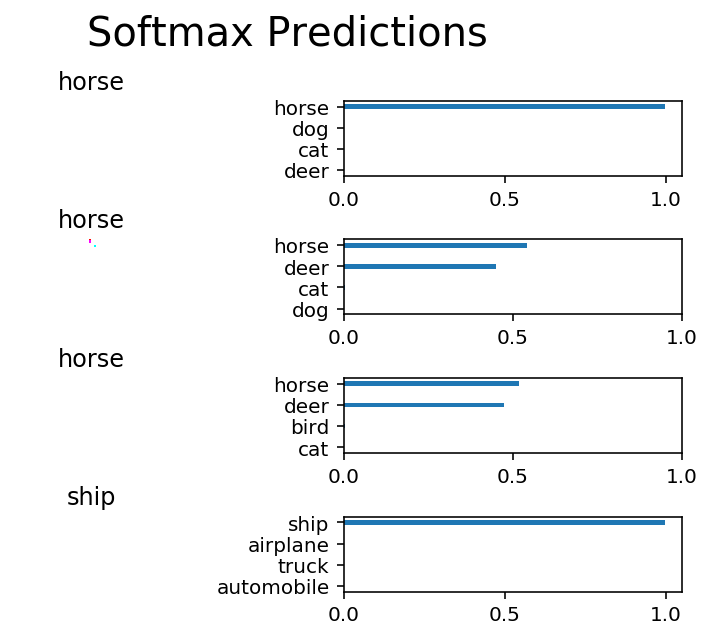

In [30]:
#Calling the function
test_classification_model()

#### By applying simple CNN model on a CIFAR-10 dataset having more than 50000 images, we are able to achive accuracy of more than 60% which is quite good.